# Class 05: Community Detection as Statistical Inference

Goal of today's class:
1. Community detection as inference!
2. Compare and contrast the abilities and syntax of `networkx` and `graph-tool`
3. (further) Highlight shortcomings of modularity

__________


0. **IMPORTANT** -- If you have not already, follow the installation instructions for the `graph-tool` environment we'll be using.
1. Come in. Sit down. Open Teams.
2. Find your notebook in your /Class_05/ folder.
________

**Builds on:** Class 04 (modularity, Girvan-Newman, and why naive community detection fails).  
**Focus today:** How to use `graph-tool` to do *statistical* community detection (SBMs), with a gentle but thorough inference primer.

> `graph-tool` is a high-performance network analysis library (core in C++), with state-of-the-art algorithms for *inference of mesoscopic structure* (communities, hierarchies, overlaps, layers) — largely developed by Tiago Peixoto.

---


## Learning goals

By the end of this notebook, you should be able to:

1. **Introduction to `graph-tool` graphs**
   - Create graphs, add vertices/edges, store attributes with property maps
   - Filter and "view" subgraphs without copying data
   - Draw graphs with good layouts and meaningful styling

2. **Translate common `networkx` code into `graph-tool`**
   - Load data, convert graphs, keep node labels / attributes
   - Compute basic network statistics in both frameworks

3. **Preliminary understanding of the statistical inference viewpoint**
   - Likelihood, prior, posterior, evidence (marginal likelihood)
   - Why community detection can be a *model selection* problem
   - What "description length" (MDL) means and why `graph-tool` uses it

4. **Fit stochastic block models (SBMs) in `graph-tool`**
   - Choose between degree-corrected vs not
   - Use nested SBMs to infer multi-scale structure
   - Quantify uncertainty with MCMC and marginal membership probabilities

---

Feel free to look over the Statistical Inference Primer section for a review.


## Table of contents

0. Notation, logs, and "what counts as a model?"
1. Setup: a dedicated conda environment (graph-tool + NetworkX + Jupyter)
2. Mental model: `networkx` vs `graph-tool`
3. Graph basics: vertices, edges, directedness, multigraphs
4. Property maps: how attributes work in `graph-tool`
5. Building graphs from data (edge lists, pandas)
6. Converting `networkx` ↔ `graph-tool`
7. Graph views & filtering (largest component, masks, subgraphs)
8. Visualization: layouts, styling, exporting
9. Core descriptive stats: degrees, clustering, distances
10. Null models & simulation: Erdős-Rényi and configuration models
11. SBMs: from sociology to modern network inference (plus scaling/runtime comparisons)
12. Statistical inference primer: Bayes, evidence, MDL (with code)
13. SBM inference in `graph-tool`: `minimize_blockmodel_dl` + nested SBMs
14. Uncertainty & MCMC: sampling partitions, marginals
15. Case study: PolBlogs + posterior predictive checks (and exercises)
16. Community detection gallery: a few very different networks, fit-and-draw
17. References and further reading

**Appendices (optional deeper dives)**
- Appendix A: NetworkX ↔ `graph-tool` cheat sheet
- Appendix B: `graph-tool` datasets and Netzschleuder
- Appendix C: Weighted graphs in `graph-tool` (distances and SBM inference)
- Appendix D: Practical tips, performance, and common gotchas
- Appendix E: Modularity, `ModularityState`, and why inference is better
- Appendix F: Overlapping communities with `OverlapBlockState`
- Appendix G: Multilayer (multiplex) networks with `LayeredBlockState`
- Appendix H: Link prediction with SBMs (and a path to uncertain networks)
- Appendix I: Network dynamics in `graph-tool` — SIS epidemics + spectral thresholds
- Appendix J: Graph algorithms every network scientist should know (with `graph-tool`)
- Appendix K: Centrality (PageRank, betweenness, closeness, eigenvector) in `graph-tool`
- Appendix L: Motifs and motif significance (triangles are just the start)

## 0. Notation, logs, and "what counts as a model?"

We'll use a small amount of notation throughout the notebook so we can connect code + math.

### 0.1 Graph notation (you already know this, but just so this notebook can stand alone as a resource!)

A (simple) graph is:

$$G = (V, E)$$

- $V$: set of vertices (nodes), $|V| = N$
- $E$: set of edges, $|E| = M$

We often represent a graph with an adjacency matrix $A$:

$$A_{ij} =
\begin{cases}
1 & \text{if there is an edge } i\to j \\
0 & \text{otherwise}
\end{cases}$$

For undirected graphs, $A$ is symmetric.

### 0.2 Degrees

For an undirected graph, the degree of node $i$ is

$$k_i = \sum_{j} A_{ij}.$$

For a directed graph, we distinguish:

$$k_i^{\text{out}} = \sum_j A_{ij},\qquad k_i^{\text{in}}  = \sum_j A_{ji}.$$

### 0.3 Partitions / "communities"

A (non-overlapping) community assignment is a function

$$b: V \to \{1,2,\dots,B\}$$

where $b_i$ is the block/community label for node $i$.

> **Important:** The numeric labels $1,2,\dots,B$ have *no meaning* by themselves (label switching). Only the grouping structure matters.

### 0.4 Probabilities vs logs (nats vs bits)

`graph-tool` reports many objective functions in **natural log units** ("nats").

- Natural log: $\ln(\cdot)$  
- Log base 2: $\log_2(\cdot)$ ("bits")

Conversion: $\log_2 x = \frac{\ln x}{\ln 2}.$

So if `graph-tool` gives you a **description length** $\Sigma$ in nats, you can convert to bits with: $\Sigma_{\text{bits}} = \frac{\Sigma}{\ln 2}.$

### 0.5 What is a "model" in this notebook?

A model is:

- a generative story for graphs, like an SBM (stochastic block model)
- plus a choice of priors / hyperpriors
- plus a choice of which parameters are learned vs fixed (e.g., degree-corrected vs not)

Different modeling assumptions can lead to different inferred "communities".
________

In [1]:
import numpy as np

# log conversion demo (pure math; independent of graph-tool)
x = 10.0
print("ln(x) =", np.log(x))
print("log2(x) =", np.log2(x))
print("ln(x)/ln(2) =", np.log(x) / np.log(2))

ln(x) = 2.302585092994046
log2(x) = 3.321928094887362
ln(x)/ln(2) = 3.3219280948873626


## 1. Setup: a dedicated conda environment (graph-tool + NetworkX + Jupyter)

This notebook assumes `graph-tool` is installed and importable.

Because `graph-tool` is a compiled C++/Python library, **the safest path is to put it in its own Conda environment** (so you don't accidentally mix binary dependencies from different sources).

---

### 1.1 What we're trying to avoid

If you've ever seen errors like:

- `ImportError: ... undefined symbol ...`
- `libstdc++.so.6: version GLIBCXX_... not found`
- `libgomp... version GOMP_... not found`
- `Segmentation fault (core dumped)` *right after an import*

...those are almost always **binary dependency conflicts**.

The fix is boring but reliable:

1. Create a **fresh** environment
2. Install from **conda-forge**
3. Don't "pile" unrelated heavy stacks into the same env unless you really need them

---

### 1.2 Recommended installer: Miniforge (Conda + conda-forge)

`graph-tool` is easiest to install from **conda-forge** (binary builds; no compilation).

- macOS (Intel + Apple Silicon): supported
- Linux (x86_64 + ARM): supported
- Windows: **no native build** → use WSL2 (or Docker)

**Install Miniforge** (recommended) or another Conda distribution, then use `mamba` (faster solver).

---

### 1.3 "One environment for the course" (macOS / Linux)

In a terminal:

```bash
# 0) (optional but recommended) make sure conda-forge has priority
conda config --add channels conda-forge
conda config --set channel_priority strict

# 1) Create a fresh environment
mamba create -n gtcnet5052 python=3.11

# 2) Install what we need for this course
mamba install -n gtcnet5052 graph-tool networkx numpy pandas scipy matplotlib jupyterlab ipykernel tqdm

# 3) Activate
conda activate gtcnet5052
```

If you don't have `mamba`, you can replace `mamba` with `conda` (it's just slower).


**macOS note (Apple Silicon):** make sure your terminal is running as `arm64`:

```bash
uname -m
```

If it prints `arm64`, you're good. If it prints `x86_64`, you're running an Intel/Rosetta shell (it can work, but you'll be mixing architectures).


---

### 1.4 Windows (recommended): WSL2 + Ubuntu + conda-forge

On Windows, the cleanest path is to run `graph-tool` inside **WSL2** (Linux subsystem).

**Step A — install WSL2 (PowerShell as Administrator):**
```powershell
wsl --install
```

Reboot if prompted, then open your Ubuntu terminal.

**Step B — install Miniforge inside WSL2**, then create the same environment as above.

**Step C — how to run notebooks**
You have two good workflows:

1) **VS Code Remote (WSL)**  
   - install VS Code on Windows  
   - install the "Remote - WSL" extension  
   - open the folder from WSL  
   - run Jupyter notebooks using the WSL Python kernel

2) **Run Jupyter in WSL, open it in your Windows browser**
```bash
conda activate gtcnet5052
jupyter lab --no-browser --ip 0.0.0.0 --port 8888
```
Then open the URL Jupyter prints (usually includes a token) in your Windows browser.

---

### 1.5 Register the environment as a Jupyter kernel (recommended)

This makes sure your notebook is running the right Python.

```bash
conda activate gtcnet5052
python -m ipykernel install --user --name gtcnet5052 --display-name "Python (gtcnet5052 / graph-tool)"
```

Then, in Jupyter: **Kernel → Change Kernel → Python (gtcnet5052 / graph-tool)**.

---

### 1.6 Reproducibility checklist (quick sanity test)

From the activated environment:

```bash
python -c "import graph_tool.all as gt; import networkx as nx; import numpy as np; print('graph-tool OK')"
```

If that succeeds, you are ready.

---

### 1.7 A fully reproducible `environment.yml` (copy/paste)

You can also create environments from an `environment.yml` file:

```yaml
name: gtcnet5052
channels:
  - conda-forge
dependencies:
  - python=3.11
  - graph-tool
  - networkx
  - numpy
  - pandas
  - scipy
  - matplotlib
  - jupyterlab
  - ipykernel
  - tqdm
```

Then run:

```bash
mamba env create -f environment.yml
conda activate gtcnet5052
```

---

### 1.8 Troubleshooting heuristics that actually work

If installs fail or imports crash:

- **Start fresh**: delete the env and recreate it  
  `conda env remove -n gtcnet5052`
- **Stay on conda-forge** (avoid mixing "defaults" + conda-forge for compiled stacks)
- **Avoid installing PyTorch + graph-tool into the same env** unless you know how to debug OpenMP / `libgomp` issues  
  (make a second env for deep learning)


- **Permission errors on macOS** (e.g., `PermissionError: ... /.condatmp`) often happen when your base Conda install lives in a protected location like `/usr/local/anaconda3`.  
  Two reliable fixes are:
  1) Put Conda's temp + package cache under your home directory:
     ```bash
     mkdir -p ~/.conda/tmp ~/.conda/pkgs ~/.conda/envs
     conda config --add envs_dirs ~/.conda/envs
     conda config --add pkgs_dirs ~/.conda/pkgs
     export TMPDIR="$HOME/.conda/tmp"
     ```
     Then retry the install.
  2) Install Miniforge under your home directory (recommended for a clean slate).

- **macOS Homebrew vs Conda library collisions** can cause warnings like "Class ... implemented in both ...libgio...".  
  If imports work but you see scary warnings (or occasional crashes), prefer the Conda env's libraries:
  ```bash
  mkdir -p "$CONDA_PREFIX/etc/conda/activate.d" "$CONDA_PREFIX/etc/conda/deactivate.d"

  cat > "$CONDA_PREFIX/etc/conda/activate.d/00-dyld-fallback.sh" << 'EOF'
  export _OLD_DYLD_FALLBACK_LIBRARY_PATH="$DYLD_FALLBACK_LIBRARY_PATH"
  export DYLD_FALLBACK_LIBRARY_PATH="$CONDA_PREFIX/lib:${DYLD_FALLBACK_LIBRARY_PATH:-}"
  EOF

  cat > "$CONDA_PREFIX/etc/conda/deactivate.d/00-dyld-fallback.sh" << 'EOF'
  export DYLD_FALLBACK_LIBRARY_PATH="$_OLD_DYLD_FALLBACK_LIBRARY_PATH"
  unset _OLD_DYLD_FALLBACK_LIBRARY_PATH
  EOF

  conda deactivate
  conda activate gtcnet5052
  ```

- **If your base Conda is very old**, a simple workaround is to make a tiny "boot" environment that contains a modern `mamba`, and use it only to create the course env:
  ```bash
  conda create -n mamba_boot -c conda-forge python=3.11 mamba
  conda activate mamba_boot
  mamba env create -f environment.yml
  ```

If all else fails, the official `graph-tool` Docker image is a reliable fallback.


---

### 1.9 Fallback: Docker image (if your local install is blocked)

If you are in an environment where you *cannot* install Conda packages (or you're debugging a gnarly binary issue), the project maintains a Docker image.

At a minimum, you can pull it with:

```bash
docker pull tiagopeixoto/graph-tool
```

From there you can mount your course folder into the container and run Python/Jupyter inside it.


In [2]:
# Core Python / scientific stack
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import math
import itertools
from scipy import special
from scipy.sparse import linalg as spla

# NetworkX for translation examples
import networkx as nx

# graph-tool (this notebook assumes it is installed)
import graph_tool
import graph_tool.all as gt

In [3]:
# Reproducibility
np.random.seed(5)
gt.seed_rng(5)

print("Python:", sys.version.split()[0])
print("NumPy:", np.__version__)
print("Pandas:", pd.__version__)
print("NetworkX:", nx.__version__)
print("graph-tool:", getattr(graph_tool, "__version__", "unknown"))

Python: 3.11.14
NumPy: 2.4.2
Pandas: 3.0.0
NetworkX: 3.6.1
graph-tool: 2.98 (commit , )


## 2. Mental model: `networkx` vs `graph-tool`

Both libraries let you represent graphs, but they make different design tradeoffs.

### 2.1 Key differences between the packages

| Idea | `networkx` | `graph-tool` |
|---|---|---|
| Main goal | flexibility, readability | performance + inference algorithms |
| Vertex identity | any hashable Python object (strings, ints, tuples, ...) | vertices are integer indices `0..N-1` |
| Attributes | stored in nested Python dicts | stored in "typed" property maps (`vp`, `ep`, `gp`) |
| Subgraphs | often copied (unless you build views yourself) | GraphView (cheap "views" via filters) |
| Graph type | simple graph by default | multigraph by default (parallel edges allowed) |
| Sweet spot | small-medium graphs, fast prototyping | medium-large graphs, inference + speed |


`graph-tool` expects you to think a bit more like a systems programmer:
- keep a clean separation between structure (e.g. edges) and data (e.g. properties)
- be explicit about types (int/float/string/...)
- use views/filters to avoid copying

### 2.2 Why this matters for community detection

In Class 04, we learned that modularity maximization can hallucinate, in a sense, communities and/or suffer from resolution issues.

`graph-tool` takes a different approach:
- define a **generative model** for the graph (e.g., an SBM)
- infer the best explanation *and its complexity* from data
- quantify uncertainty via Markov-chain Monte Carlo

We'll build up to that slowly, starting with the fundamentals.

---

### 2.3 Your first translation: a tiny graph in both libraries


In [4]:
# NetworkX: tiny undirected graph with labels
G_nx = nx.Graph()
G_nx.add_edges_from([("alice", "bob"), ("bob", "carlos"), ("alice", "carlos"), ("carlos", "dana")])
print("NetworkX nodes:", list(G_nx.nodes()))
print("NetworkX edges:", list(G_nx.edges()))


NetworkX nodes: ['alice', 'bob', 'carlos', 'dana']
NetworkX edges: [('alice', 'bob'), ('alice', 'carlos'), ('bob', 'carlos'), ('carlos', 'dana')]


In [5]:
# graph-tool: same graph
g_gt = gt.Graph(directed=False)

# graph-tool vertices are integers. We'll keep labels in a vertex property map.
name = g_gt.new_vertex_property("string")

# Make a mapping from label -> vertex
label_to_v = {}
for lbl in list(G_nx.nodes()):
    v = g_gt.add_vertex()
    label_to_v[lbl] = v
    name[v] = lbl

# Add edges using the mapping
for u, v in G_nx.edges():
    g_gt.add_edge(label_to_v[u], label_to_v[v])

g_gt.vp["name"] = name  # store under a nice key

print("\ngraph-tool vertices:", g_gt.num_vertices())
print("graph-tool edges:", g_gt.num_edges())
# show labels
print("vertex labels:", [g_gt.vp.name[v] for v in g_gt.vertices()])


graph-tool vertices: 4
graph-tool edges: 4
vertex labels: ['alice', 'bob', 'carlos', 'dana']


________
### 2.5 Modularity

#### Recall: Modularity can be high *simply due to random chance!*

In Class 04, we saw an important observation

> Even *random graphs* can have surprisingly high maximum modularity.  
> So "high modularity" alone is not strong evidence of meaningful communities.

Let's reproduce the idea quickly with a small simulation:
- compute the best Louvain modularity on the Karate Club graph
- compute the best Louvain modularity on many random graphs with the same N and E
- compare the distributions

**When in doubt**:
- always compare to a null model
- don't confuse an optimization objective with "truth"

_____
> Within-group edges minus what we would expect within-group if edges were placed "at random", *given the degrees*.

Let:

- $A_{ij}$ = adjacency matrix (1 if edge between $i$ and $j$, else 0)
- $k_i = \sum_j A_{ij}$ = degree of node $i$
- $m$ = number of edges (so $2m = \sum_i k_i$ in an undirected graph)
- $C_i$ = community assignment of node $i$

A common modularity definition (undirected, unweighted) is:

$$
Q(\mathbf{C}) = \frac{1}{2m}\sum_{i,j}
\left(A_{ij} - \frac{k_i k_j}{2m}\right)\,\mathbf{1}\{C_i=C_j\}.
$$

Tjhe $\frac{k_i k_j}{2m}$ comes from the *configuration-model* baseline:

- Imagine node $i$ has $k_i$ "stubs" (half-edges)
- In total, there are $2m$ stubs
- A rough approximation: the chance that a randomly chosen stub attaches to node $j$ is $k_j/(2m)$

So the expected number of $i\leftrightarrow j$ connections under random stub-matching is proportional to:

$$
\mathbb{E}[A_{ij}] \approx \frac{k_i k_j}{2m}.
$$

Modularity is therefore attempting to compare observed vs degree-preserving random expectation.

#### Why high modularity can be misleading

Even if the graph is random, you can often find *some* partition that makes the within-group count larger than expected — not because the graph has real communities, but because you are optimizing over a huge space of possible partitions and/or the best partition is apt to over-fit on the noise.

That's why we compare to null models and/or use statistical inference (SBMs) instead of treating $Q$ as a ground-truth score.
_________

## Your turn! (Refresher) -- 10 minutes

Use `networkx` to measure the modularity of the Karate Club graph.

1. Run the Louvain algorithm, and store the modularity of the partition it outputs.
2. Write a function to randomize your network in two ways (with an input keyword):
    * First: Random network, same $n$ and $m$
    * Second: Degree-preserving random network.
3. For a loop of 500 times, randomize your original network, under both approaches. Each time, run the Louvain community detection algorithm, and store the modularity.
4. Plot the two distributions of modularities, along with a vertical line corresponding to the original graph's modularity.

In [6]:
pass

____________

In [7]:
from networkx.algorithms.community.quality import modularity
from networkx.algorithms.community import louvain_communities

def best_louvain_modularity(G, seed=0):
    parts = louvain_communities(G, seed=seed)
    return modularity(G, parts)


G_obs = nx.karate_club_graph()
n = G_obs.number_of_nodes()
m = G_obs.number_of_edges()
deg_seq = [d[1] for d in G_obs.degree]

In [8]:
q_obs = best_louvain_modularity(G_obs, seed=0)
print("Observed Karate modularity (Louvain):", round(q_obs, 3))

Observed Karate modularity (Louvain): 0.444


In [9]:
# Null distribution: random graphs with same N and E
qs_r = []
qs_c = []
for i in range(1000):
    G_rand = nx.gnm_random_graph(n, m, seed=i)
    qs_r.append(best_louvain_modularity(G_rand, seed=i))
    G_conf = nx.configuration_model(deg_seq)
    qs_c.append(best_louvain_modularity(G_conf, seed=i))

qs_r = np.array(qs_r)
qs_c = np.array(qs_c)

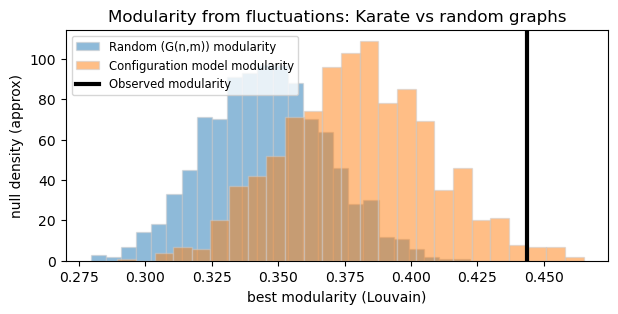

In [10]:
plt.figure(figsize=(7,3),dpi=100)

plt.hist(qs_r, bins=25, ec='.8', label='Random (G(n,m)) modularity', alpha=0.5)
plt.hist(qs_c, bins=25, ec='.8', label='Configuration model modularity', alpha=0.5)
plt.axvline(q_obs, linewidth=3, color='k', label='Observed modularity')

plt.xlabel("best modularity (Louvain)")
plt.ylabel("null density (approx)")
plt.title("Modularity from fluctuations: Karate vs random graphs")
plt.legend(fontsize='small', loc=2)

plt.show()

#### 2.6 In case you're interested... we can compute modularity from scratch like in Class 04.

We'll take the Louvain partition on Karate and compute:

$$
Q(C) = \frac{1}{2m}\sum_{i,j}
\left(A_{ij} - \frac{k_i k_j}{2m}\right)\,\mathbf{1}\{C_i=C_j\}
$$

in plain NumPy, then verify it matches `networkx.algorithms.community.quality.modularity()`.

In [11]:
# Pull the Louvain partition explicitly
parts = louvain_communities(G_obs, seed=0)
q_nx = modularity(G_obs, parts)

nodes = list(G_obs.nodes())
idx = {node: i for i, node in enumerate(nodes)}

A = nx.to_numpy_array(G_obs, nodelist=nodes)
k = A.sum(axis=1)
m = k.sum() / 2.0

# community labels aligned to our matrix ordering
g = np.empty(len(nodes), dtype=int)
for ci, group in enumerate(parts):
    for node in group:
        g[idx[node]] = ci

B = A - np.outer(k, k) / (2 * m)           # modularity matrix
S = (g[:, None] == g[None, :]).astype(float)  # same-block indicator
q_manual = (1 / (2 * m)) * np.sum(B * S)

print("NetworkX modularity:", q_nx)
print("Manual modularity  :", q_manual)
print("Absolute diff      :", abs(q_nx - q_manual))

NetworkX modularity: 0.4438541256723075
Manual modularity  : 0.4438541256723075
Absolute diff      : 0.0


______

### Recap done / check-in

1. What is the biggest *practical* difference between a `networkx` graph and a `graph-tool` graph?
2. Why does `graph-tool` use property maps for attributes instead of storing them directly on Python objects?
3. Suppose you need to compute a heavy statistic (like betweenness) on a graph with millions of edges. What parts of the stack become the bottleneck in pure-Python workflows?
4. When might `networkx` still be the right choice even if it's slower?
_____

## 3. Graph basics in `graph-tool`

### 3.1 Creating graphs

In `graph-tool`, the central object is `gt.Graph`.

```python
g = gt.Graph(directed=False)   # undirected
g = gt.Graph(directed=True)    # directed
```

A few gotchas:
- A `Graph` is a **multigraph by default** (parallel edges allowed).
- Vertices are always indexed contiguously from `0` to `N-1`.
- Vertices and edges are "descriptors" — lightweight handles that refer into the graph.

### 3.2 Adding vertices and edges

- `v = g.add_vertex()` adds one vertex
- `g.add_edge(u, v)` adds an edge
- You can add many edges quickly via `g.add_edge_list(...)`

### 3.3 Iterating

- `for v in g.vertices(): ...`
- `for e in g.edges(): ...`
- `for u in v.out_neighbors(): ...` (directed graphs)
- `v.out_degree()` / `v.in_degree()` / `v.all_neighbors()`

### 3.4 Parallel edges and self-loops

Because graphs are multigraphs by default, the following are possible unless you remove them:
- multiple edges between the same pair of vertices
- edges from a vertex to itself

You can remove them with:
```python
gt.remove_self_loops(g)
gt.remove_parallel_edges(g)
```

---

### 3.5 Hands-on: build a directed graph and inspect it


In [12]:
g = gt.Graph(directed=True)
g.add_vertex(5)  # add 5 vertices: indices 0..4

<generator object Graph.add_vertex.<locals>.<genexpr> at 0x1de407840>

In [13]:
# add some directed edges
g.add_edge(g.vertex(0), g.vertex(1))
g.add_edge(g.vertex(0), g.vertex(2))
g.add_edge(g.vertex(2), g.vertex(1))
g.add_edge(g.vertex(1), g.vertex(3))
g.add_edge(g.vertex(3), g.vertex(3))  # self-loop

<Edge object with source '3' and target '3' at 0x1de4312d0>

In [14]:
# parallel edge (same endpoints)
g.add_edge(g.vertex(0), g.vertex(1))

<Edge object with source '0' and target '1' at 0x1de431480>

In [15]:
print("directed?", g.is_directed())
print("V =", g.num_vertices(), "E =", g.num_edges())

directed? True
V = 5 E = 6


In [16]:
# degrees
for v in g.vertices():
    print(int(v), "out-degree =", v.out_degree(), "in-degree =", v.in_degree())

print("\nAll edges:")
for e in g.edges():
    print(int(e.source()), "->", int(e.target()))

0 out-degree = 3 in-degree = 0
1 out-degree = 1 in-degree = 3
2 out-degree = 1 in-degree = 1
3 out-degree = 1 in-degree = 2
4 out-degree = 0 in-degree = 0

All edges:
0 -> 1
0 -> 2
0 -> 1
1 -> 3
2 -> 1
3 -> 3


In [17]:
# clean up
gt.remove_self_loops(g)
gt.remove_parallel_edges(g)

print("\nAfter removing self-loops + parallel edges:")
print("E =", g.num_edges())


After removing self-loops + parallel edges:
E = 4


## 4. Property maps: how attributes work in `graph-tool`

In `networkx`, attributes live in Python dictionaries:

```python
G.nodes["alice"]["age"] = 19
G.edges["alice", "bob"]["weight"] = 0.7
```

In `graph-tool`, attributes live in **property maps**, which are:
- typed (e.g., `"int"`, `"double"`, `"string"`, `"bool"`, `"vector<double>"`)
- stored *separately* from the adjacency structure (for speed)
- accessible via:
  - `g.vp` (vertex properties)
  - `g.ep` (edge properties)
  - `g.gp` (graph properties)

### 4.1 Create property maps

```python
age   = g.new_vertex_property("int")
name  = g.new_vertex_property("string")
w     = g.new_edge_property("double")
label = g.new_graph_property("string")
```

Then assign values by indexing with a vertex/edge descriptor:
```python
age[v] = 19
w[e]   = 0.7
```

### 4.2 Store property maps inside the graph

You can keep property maps as standalone variables, **and/or** store them in the graph:

```python
g.vp["age"] = age
g.ep["weight"] = w
g.gp["dataset"] = label
```

Then you can access them as:
- `g.vp.age` (if the key is a valid Python identifier)
- `g.vp["age"]` (always works)

### 4.3 Fast numpy access (`.a` and `.fa`)

Many property maps expose numpy arrays for speed:
- `prop.a` is typically a numpy array view of the values
- `prop.fa` is a "fast array" optimized for internal storage (often the one to use)

You'll see this in graph-tool examples like:
```python
deg = g.degree_property_map("total").a
```

---

### 4.4 Hands-on: attach names to vertices and weights to edges


In [18]:
g = gt.Graph(directed=False)
g.add_vertex(4)

<generator object Graph.add_vertex.<locals>.<genexpr> at 0x1de4073e0>

In [19]:
# make edges
edges = [(0, 1), (1, 2), (2, 3), (0, 2)]
g.add_edge_list(edges)

In [20]:
# vertex properties
name = g.new_vp("string")
for i, v in enumerate(g.vertices()):
    name[v] = ["alice", "bob", "carlos", "dana"][i]

In [21]:
# edge properties
w = g.new_ep("double")
for e in g.edges():
    w[e] = np.random.rand()

In [22]:
# store them
g.vp["name"] = name
g.ep["weight"] = w
g.gp["dataset"] = g.new_gp("string", val="toy_example")

In [23]:
print("Graph property dataset:", g.gp["dataset"])
for e in g.edges():
    print(g.vp.name[e.source()], "--", g.vp.name[e.target()], " weight =", round(g.ep.weight[e], 3))

Graph property dataset: toy_example
alice -- bob  weight = 0.222
alice -- carlos  weight = 0.871
bob -- carlos  weight = 0.207
carlos -- dana  weight = 0.919


### Check-in:

1. What is the type of `g.vp["name"]` (a **property map**) versus the type of `g.vp["name"][v]` (a **value**)?
2. `deg = g.degree_property_map("total")` gives a property map. What does `deg.a` return, and why is that convenient?
3. What happens to vertex/edge property maps when you create a `GraphView`? (Think: *view* vs *copy*.)
4. If you filter a graph and then call `gt.Graph(view, prune=True)`, what changes, and what stays the same?


__________
## 5. Building graphs from data (edge lists, pandas, file formats)

### 5.1 Edge lists are the universal "exchange format"

Most real-world network datasets can be reduced to something like:

| source | target | weight | timestamp | ... |
|---|---|---:|---|---|
| alice | bob | 0.2 | 2024-01-01 | ... |
| bob | carlos | 1.1 | 2024-01-02 | ... |

In `graph-tool`, the most efficient way to build a graph from data is usually:

- turn your edge list into a numpy array or list of tuples
- call `g.add_edge_list(...)`

### 5.2 `add_edge_list(..., hashed=True)` for string node IDs

If your nodes are strings, you can let `graph-tool` build the mapping automatically:

```python
g = gt.Graph(directed=False)
vprop_id = g.add_edge_list(edge_array, hashed=True, hash_type="string")
g.vp["id"] = vprop_id
```

This creates:
- vertices with integer indices `0..N-1`
- a vertex property map that stores the original IDs

### 5.3 Reading and writing graphs

`graph-tool` supports multiple formats:
- `.gt` (native binary, fast)
- `.graphml` / `.xml`
- `.gml`, `.dot`

```python
g.save("mygraph.gt")
g2 = gt.load_graph("mygraph.gt")
```

---

### 5.4 Hands-on: make a graph from a pandas edge list


In [24]:
# Make a tiny "realistic" edge list as a DataFrame
df_edges = pd.DataFrame({
    "src": ["alice", "alice", "bob", "carlos", "carlos", "dana"],
    "dst": ["bob", "carlos", "carlos", "dana", "alice", "bob"],
    "weight": [1.0, 0.2, 0.8, 2.0, 0.5, 1.3],
})

df_edges

src     dst  weight
0   alice     bob     1.0
1   alice  carlos     0.2
2     bob  carlos     0.8
3  carlos    dana     2.0
4  carlos   alice     0.5
5    dana     bob     1.3

In [25]:
# Edge list as list of tuples (src, dst, weight)
edge_list = list(df_edges.itertuples(index=False, name=None))
edge_list

[('alice', 'bob', 1.0),
 ('alice', 'carlos', 0.2),
 ('bob', 'carlos', 0.8),
 ('carlos', 'dana', 2.0),
 ('carlos', 'alice', 0.5),
 ('dana', 'bob', 1.3)]

In [26]:
g = gt.Graph(directed=False)

In [27]:
# We will store weights in an edge property map.
eweight = g.new_ep("double")

In [28]:
# add_edge_list can fill edge properties if we pass eprops=[...]
# IMPORTANT: When hashed=True, it will map string IDs -> vertex indices.
vprop_id = g.add_edge_list(edge_list, hashed=True, hash_type="string", eprops=[eweight])

In [29]:
# store properties
g.vp["id"] = vprop_id
g.ep["weight"] = eweight

In [30]:
print("V =", g.num_vertices(), "E =", g.num_edges())
print("Some vertex IDs:", [g.vp.id[v] for v in list(g.vertices())[:5]])

V = 4 E = 6
Some vertex IDs: ['alice', 'bob', 'carlos', 'dana']


In [31]:
# show first few edges with weights
for e in list(g.edges())[:5]:
    print(g.vp.id[e.source()], "-", g.vp.id[e.target()], "w =", g.ep.weight[e])

alice - bob w = 1.0
alice - carlos w = 0.2
bob - carlos w = 0.8
carlos - dana w = 2.0
carlos - alice w = 0.5


________
## 6. Converting `networkx` ↔ `graph-tool` (interoperability)

You will often:
- prototype in `networkx` (quick + flexible)
- scale or infer structure in `graph-tool` (fast + statistical inference)
- export results back to `networkx` for compatibility with other tooling

### 6.1 The core challenge: node labels

- In `networkx`, nodes can be strings, ints, tuples, etc.
- In `graph-tool`, vertices are **integer indices**.

So any conversion needs a mapping. A common pattern:
- store original node labels in a vertex property map named `"id"` or `"name"`

### 6.2 Practical conversion utilities

Below is a conversion function that:
- preserves node labels (as `vp["id"]`)
- carries over node/edge attributes when possible

> These are "teaching implementations", not industrial-strength ETL.  
> For messy real datasets, you'll want to be explicit about which columns/attributes you keep.


In [32]:
def _infer_gt_type(value):
    # Infer a graph-tool property type for common Python values.
    if isinstance(value, bool):
        return "bool"
    if isinstance(value, int) and not isinstance(value, bool):
        return "int"
    if isinstance(value, float):
        return "double"
    if isinstance(value, str):
        return "string"
    # fallback: stores arbitrary Python objects (less portable)
    return "object"

def nx_to_gt(G_nx, node_id_key="id"):
    '''
    Convert a NetworkX graph -> graph-tool Graph.

    - Keeps original node labels in vertex property `node_id_key`.
    - Copies node and edge attributes when possible.
    '''
    g = gt.Graph(directed=G_nx.is_directed())

    # --- Collect attribute keys
    node_attr_keys = set()
    edge_attr_keys = set()

    for _, data in G_nx.nodes(data=True):
        node_attr_keys |= set(data.keys())
    for _, _, data in G_nx.edges(data=True):
        edge_attr_keys |= set(data.keys())

    # Create vertex property maps
    vp = {}
    vp[node_id_key] = g.new_vp("string")  # always keep labels as strings
    for k in sorted(node_attr_keys):
        sample = None
        for _, data in G_nx.nodes(data=True):
            if k in data:
                sample = data[k]
                break
        vp[k] = g.new_vp(_infer_gt_type(sample) if sample is not None else "string")

    # Create edge property maps
    ep = {}
    for k in sorted(edge_attr_keys):
        sample = None
        for _, _, data in G_nx.edges(data=True):
            if k in data:
                sample = data[k]
                break
        ep[k] = g.new_ep(_infer_gt_type(sample) if sample is not None else "string")

    # --- Add vertices and mapping
    nxnode_to_v = {}
    for n, data in G_nx.nodes(data=True):
        v = g.add_vertex()
        nxnode_to_v[n] = v

        vp[node_id_key][v] = str(n)

        for k, pmap in vp.items():
            if k == node_id_key:
                continue
            if k in data:
                try:
                    pmap[v] = data[k]
                except Exception:
                    pmap[v] = str(data[k])

    # --- Add edges
    for u, v, data in G_nx.edges(data=True):
        e = g.add_edge(nxnode_to_v[u], nxnode_to_v[v])
        for k, pmap in ep.items():
            if k in data:
                try:
                    pmap[e] = data[k]
                except Exception:
                    pmap[e] = str(data[k])

    # Attach property maps
    for k, pmap in vp.items():
        g.vp[k] = pmap
    for k, pmap in ep.items():
        g.ep[k] = pmap

    return g

def gt_to_nx(g, node_id_key="id"):
    '''
    Convert graph-tool Graph -> NetworkX graph.

    If g.vp[node_id_key] exists, uses it as NetworkX node labels.
    Otherwise uses integer vertex indices.
    '''
    G_nx = nx.DiGraph() if g.is_directed() else nx.Graph()

    use_id = (node_id_key in g.vp)
    v_to_label = {}

    for v in g.vertices():
        lbl = g.vp[node_id_key][v] if use_id else int(v)
        v_to_label[v] = lbl
        G_nx.add_node(lbl)

        # copy vertex properties (excluding id)
        for k, pmap in g.vp.items():
            if k == node_id_key:
                continue
            try:
                G_nx.nodes[lbl][k] = pmap[v]
            except Exception:
                G_nx.nodes[lbl][k] = str(pmap[v])

    # edges + properties
    for e in g.edges():
        u = v_to_label[e.source()]
        v = v_to_label[e.target()]
        G_nx.add_edge(u, v)

        for k, pmap in g.ep.items():
            try:
                G_nx.edges[u, v][k] = pmap[e]
            except Exception:
                G_nx.edges[u, v][k] = str(pmap[e])

    return G_nx


### 6.3 Demo: convert the Karate Club graph

1. load the classic Zachary Karate Club network in NetworkX
2. convert to `graph-tool`
3. compute a layout and draw it (graph-tool)
4. convert back to NetworkX (so you can keep using your old workflows)


In [33]:
G_k = nx.karate_club_graph()
print("NetworkX karate:", G_k.number_of_nodes(), "nodes,", G_k.number_of_edges(), "edges")

g_k = nx_to_gt(G_k, node_id_key="id")
print("graph-tool karate:", g_k.num_vertices(), "vertices,", g_k.num_edges(), "edges")

NetworkX karate: 34 nodes, 78 edges
graph-tool karate: 34 vertices, 78 edges


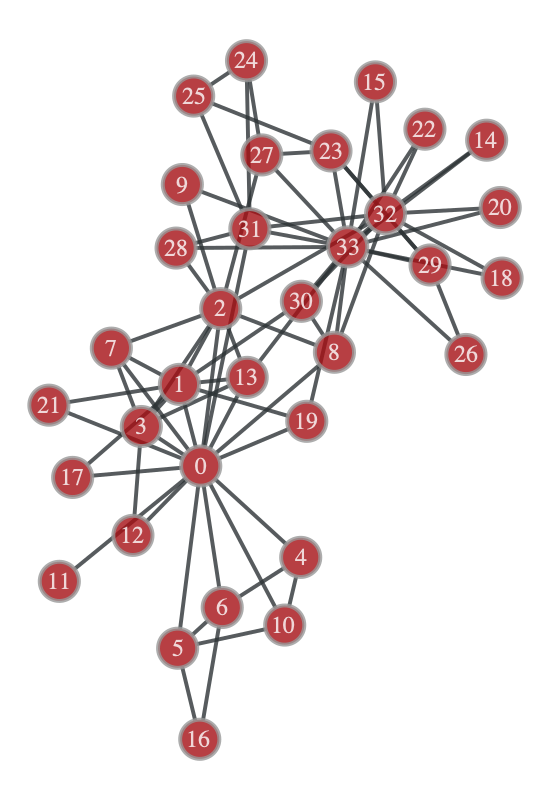

In [34]:
pos = gt.sfdp_layout(g_k)
gt.graph_draw(
    g_k, pos=pos,
    vertex_text=g_k.vp.id,
    vertex_font_size=12,
    output_size=(400, 400)
);

In [35]:
# convert back
G_back = gt_to_nx(g_k, node_id_key="id")
print("Back to NetworkX:", G_back.number_of_nodes(), "nodes,", G_back.number_of_edges(), "edges")

Back to NetworkX: 34 nodes, 78 edges


## 7. Graph views & filtering (largest component, masks, subgraphs)

One of the most powerful ideas in `graph-tool` is the **GraphView**:

- You can create a *view* of a subset of vertices/edges
- Most algorithms operate on the view transparently
- This avoids expensive copying

### 7.1 The two-step pattern

1) Create a boolean filter (a property map of type `"bool"`):
```python
vfilt = g.new_vp("bool")
vfilt[v] = True  # keep
vfilt[v] = False # hide
```

2) Create a view:
```python
gv = gt.GraphView(g, vfilt=vfilt)
```

If you later need an independent graph (no filters), you can copy/prune:
```python
g2 = gt.Graph(gv, prune=True)
```

### 7.2 Largest connected component

Community detection and inference are usually best done on the **giant component**.

Two common patterns:
- `gt.extract_largest_component(g, directed=False)` (quick)
- `GraphView + label_largest_component()` (more control)

---

### 7.3 Hands-on: filter to the largest component and to "high-degree" vertices


In [36]:
# Let's use a built-in dataset (Karate Club)
g = nx_to_gt(nx.karate_club_graph())

In [37]:
print("Original: V =", g.num_vertices(), "E =", g.num_edges())

Original: V = 34 E = 78


In [38]:
# Largest component (Karate is connected, but this is the pattern)
g_lcc = gt.extract_largest_component(g, directed=False)
print("Largest component: V =", g_lcc.num_vertices(), "E =", g_lcc.num_edges())

Largest component: V = 34 E = 78


In [39]:
# Filter: keep only vertices with degree >= 4
deg = g_lcc.degree_property_map("total")
vfilt = g_lcc.new_vp("bool")
vfilt.a = deg.a >= 4  # vectorized assignment

In [40]:
gv = gt.GraphView(g_lcc, vfilt=vfilt)
g_deg4 = gt.Graph(gv, prune=True)

print("Degree>=4 view (pruned): V =", g_deg4.num_vertices(), "E =", g_deg4.num_edges())

Degree>=4 view (pruned): V = 16 E = 39


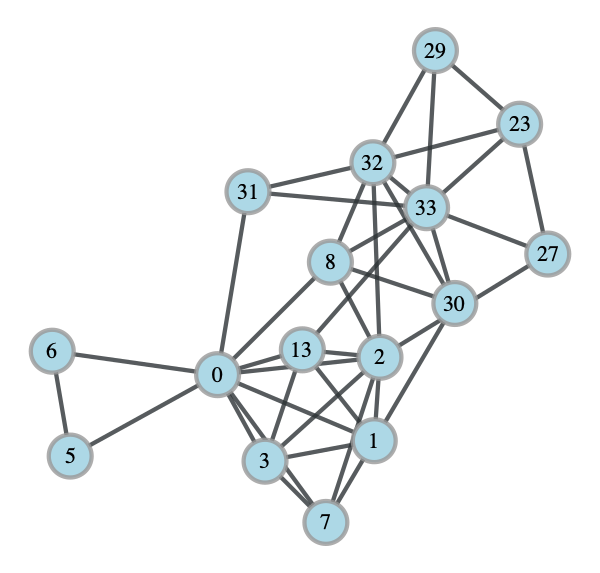

In [41]:
pos = gt.sfdp_layout(g_deg4)
gt.graph_draw(
    g_deg4, pos=pos,
    vertex_text=g_deg4.vp.id,
    vertex_font_size=11,
    output_size=(300, 300),
    vertex_fill_color='lightblue'
);

## 8. Visualization: layouts, styling, exporting

`graph-tool` can draw graphs *directly* (via Cairo), and its layout algorithms are excellent.

### 8.1 Layouts (where do nodes go?)

A layout is usually a **vertex property map** with a 2D position per node:
- type often looks like `"vector<double>"` under the hood

A common default:
```python
pos = gt.sfdp_layout(g)
```

### 8.2 Styling (colors, sizes, labels)

Most style parameters can be:
- a constant (e.g., `vertex_size=10`)
- **or** a property map (e.g., size proportional to degree)

Example:
```python
deg = g.degree_property_map("total")
vsize = gt.prop_to_size(deg, mi=5, ma=20)
gt.graph_draw(g, pos=pos, vertex_size=vsize)
```

### 8.3 Exporting

You can render directly to a file:
```python
gt.graph_draw(g, pos=pos, output="figure.svg")
```

---

### 8.4 Hands-on: draw the Karate Club graph with degree-based sizing


In [42]:
g = nx_to_gt(nx.karate_club_graph())

# layout
pos = gt.sfdp_layout(g)

In [43]:
# degree -> size
deg = g.degree_property_map("total")
vsize = gt.prop_to_size(deg, mi=10, ma=30)

In [44]:
# color by degree (continuous)
vcolor = gt.prop_to_size(deg, mi=0.1, ma=0.9)  # values mapped to [0.1,0.9] for colormap usage

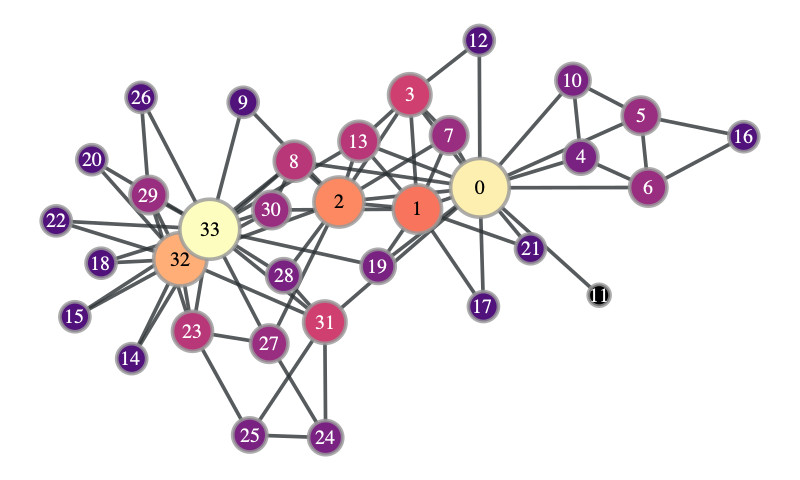

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x1de3e0810, at 0x1de48c8d0>

In [45]:
gt.graph_draw(
    g, pos=pos,
    vertex_size=vsize,
    vertex_fill_color=vcolor,
    vertex_text=g.vp.id if "id" in g.vp else g.vertex_index,
    vertex_font_size=10,
    output_size=(400, 400)
)

## Your turn! (15 minutes)
In pairs*, explore the graph-tool cookbook, and try pasting in an interesting routine / module / analysis.

https://graph-tool.skewed.de/static/docs/stable/demos/index.html

At the end, each group will share screen and show off their technique.

## 9. Core descriptive stats: degrees, clustering, distances

Before we infer communities, we should be comfortable with basic network summaries.

We'll use the Karate Club network as a running example.

> Why this matters: when you later fit an SBM, you should *always* sanity-check the result against basic summaries (degree distribution, clustering, path lengths, assortativity, etc.).
> 
> Otherwise, you can end up "discovering" communities that are really just artifacts of degree heterogeneity, disconnected components, or measurement issues.

---


### 9.1 Degree (distribution and averages)

For an undirected simple graph with adjacency matrix $A$:

$$k_i = \sum_j A_{ij}.$$

For a directed graph:

$$k_i^{\text{out}} = \sum_j A_{ij},\qquad k_i^{\text{in}} = \sum_j A_{ji}.$$


**NetworkX**
- `dict(G.degree())`
- `np.mean([d for _, d in G.degree()])`

**graph-tool**
- `deg = g.degree_property_map("total").a`
- `gt.vertex_average(g, "total")`
- `gt.vertex_hist(g, "total")`

---

### 9.2 Clustering coefficient (triangles)

A triangle is a 3-cycle: $i\to j\to k\to i$.

A common definition of the **local clustering coefficient** is:

$$C_i = \frac{\text{number of triangles touching } i}{\text{number of triples centered at } i}
= \frac{2T_i}{k_i(k_i-1)},$$

where $T_i$ is the number of triangles incident to $i$, and $k_i$ is the degree.

A common **global** clustering / transitivity is:

$$C = \frac{3\times\text{\# triangles}}{\text{\# connected triples}}.$$


**NetworkX**
- `nx.clustering(G)` (local)
- `nx.average_clustering(G)` (global average of local $C_i$)

**graph-tool**
- `gt.local_clustering(g)` (local)
- `gt.global_clustering(g)` (global transitivity)

---


### 9.3 Shortest-path distance

The shortest path distance between $i$ and $j$ is:

$$d(i,j) = \min_{\pi:i\to j} |\pi|,$$

i.e., the minimum number of edges along any path $\pi$ from $i$ to $j$.


**NetworkX**
- `nx.shortest_path_length(G, source, target)`

**graph-tool**
- `gt.shortest_distance(g, source=v)` returns distances to all vertices
- `gt.shortest_distance(g, source=v, target=u)` returns one distance

---

### 9.4 Betweenness centrality

Betweenness of a vertex $v$ measures how often it lies on shortest paths:

$$\mathrm{BC}(v) = \sum_{s\neq v\neq t}\frac{\sigma_{st}(v)}{\sigma_{st}},$$

where:
- $\sigma_{st}$ is the number of shortest paths from $s$ to $t$
- $\sigma_{st}(v)$ is the number of those paths that pass through $v$


**NetworkX**
- `nx.betweenness_centrality(G)` (can be slow for large graphs)

**graph-tool**
- `vb, eb = gt.betweenness(g)` (optimized; can use OpenMP)

---

<!-- #### 9.0 (Optional) A tiny "by hand" check of the formulas

Before we use library functions, it can be helpful to sanity-check the definitions on a toy graph.

We'll build a 4-node graph consisting of:
- a triangle on nodes $\{0,1,2\}$
- plus a "tail" edge $(2,3)$

Then we'll compute:
- degrees from $k_i = \sum_j A_{ij}$
- triangles via $(A^3)_{ii}$
- local clustering via $C_i = 2T_i / (k_i(k_i-1))$

> This is **not** the fastest way to do things — it's a pedagogical check that the code matches the math. -->

<!-- ##### 9.0.1 Why does $A^3$ "know about" triangles?

This is one of the most useful linear-algebra facts in network science.

Start with an adjacency matrix $A$ for an **undirected simple** graph.

**Claim 1:** $(A^2)_{ij}$ counts the number of length-2 walks from $i$ to $j$.

Proof sketch:

$$
(A^2)_{ij} = \sum_k A_{ik}A_{kj}.
$$

A term $A_{ik}A_{kj}$ equals 1 exactly when:

- $i$ is connected to $k$
- and $k$ is connected to $j$

So each intermediate node $k$ that forms a 2-step path $i\to k\to j$ contributes 1.

**Claim 2:** $(A^3)_{ii}$ counts the number of length-3 closed walks that start and end at $i$.

$$
(A^3)_{ii} = \sum_{j,k} A_{ij}A_{jk}A_{ki}.
$$

Now look at a triangle $(i,j,k)$.

In an undirected triangle, you can traverse the triangle and return to $i$ in **two** distinct 3-step directions:

- $i\to j\to k\to i$
- $i\to k\to j\to i$

So **each triangle incident to $i$ contributes 2** to $(A^3)_{ii}$.

Therefore:

$$
T_i = \frac{(A^3)_{ii}}{2}
$$

where $T_i$ is the number of triangles that touch vertex $i$.

Finally, if you sum over all vertices:

- each triangle has 3 vertices
- at each vertex, it contributes 2 closed walks

So the total triangle count is:

$$
\#\text{triangles} = \frac{\mathrm{tr}(A^3)}{6}.
$$ -->


In [46]:
# Toy graph: triangle + tail
G_tiny = nx.Graph()
G_tiny.add_edges_from([(0, 1), (1, 2), (2, 0), (2, 3)])

In [47]:
# Adjacency matrix (node order: 0,1,2,3)
A = nx.to_numpy_array(G_tiny, nodelist=sorted(G_tiny.nodes()))

In [48]:
# Degree by definition: k_i = sum_j A_ij
k = A.sum(axis=1)
print("Degrees k:", k.astype(int))

Degrees k: [2 2 3 1]


In [49]:
# Triangle counts in an undirected simple graph:
# (A^3)_{ii} counts twice the number of triangles incident to i.
A3 = np.linalg.matrix_power(A, 3)
T = np.diag(A3) / 2
print("Triangles incident to node i (T_i):", T.astype(int))

Triangles incident to node i (T_i): [1 1 1 0]


In [50]:
# Local clustering: C_i = 2T_i / (k_i (k_i - 1)), with C_i = 0 if k_i < 2
C = np.zeros(len(k), dtype=float)
for i in range(len(k)):
    if k[i] >= 2:
        C[i] = (2 * T[i]) / (k[i] * (k[i] - 1))
print("Local clustering (by formula):", np.round(C, 3))

Local clustering (by formula): [1.    1.    0.333 0.   ]


In [51]:
# Compare to NetworkX
print("NetworkX clustering:", nx.clustering(G_tiny))

# Total number of triangles = tr(A^3) / 6 (undirected simple graphs)
num_triangles = np.trace(A3) / 6
print("Total triangles (trace formula):", int(num_triangles))

NetworkX clustering: {0: 1.0, 1: 1.0, 2: 0.3333333333333333, 3: 0}
Total triangles (trace formula): 1


In [52]:
G = nx.karate_club_graph()

# NetworkX degrees
deg_nx = np.array([d for _, d in G.degree()])
print("NetworkX mean degree:", deg_nx.mean())

g = nx_to_gt(G)

deg_gt = g.degree_property_map("total").a
print("graph-tool mean degree:", deg_gt.mean())

NetworkX mean degree: 4.588235294117647
graph-tool mean degree: 4.588235294117647


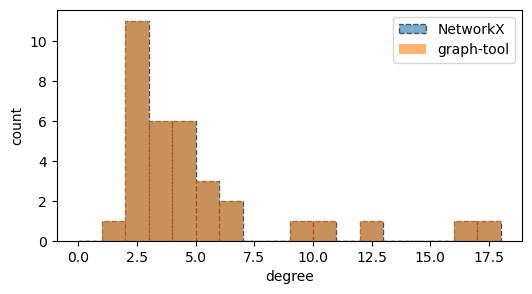

In [53]:
# Compare full distributions
plt.figure(figsize=(6,3),dpi=100)

plt.hist(deg_nx, bins=range(deg_nx.max()+2), alpha=0.6, label="NetworkX", ls='--', ec='k')
plt.hist(deg_gt, bins=range(int(deg_gt.max())+2), alpha=0.6, label="graph-tool")
plt.xlabel("degree")
plt.ylabel("count")
plt.legend()

plt.show()

In [54]:
g = nx_to_gt(nx.karate_club_graph())

# Clustering
c_local = gt.local_clustering(g)       # vertex property map
c_global = gt.global_clustering(g)     # (value, std) by default

print("graph-tool global clustering (estimate):", c_global)

# Distances from a source vertex
source = g.vertex(0)
dist = gt.shortest_distance(g, source=source)  # vertex property map of distances
print("Distances from vertex 0 (first 10):", dist.a[:10])

graph-tool global clustering (estimate): (0.2556818181818182, 0.06314746595079679)
Distances from vertex 0 (first 10): [0 1 1 1 1 1 1 1 1 2]


Top 5 betweenness vertices: [ 0 33 32  2 31]


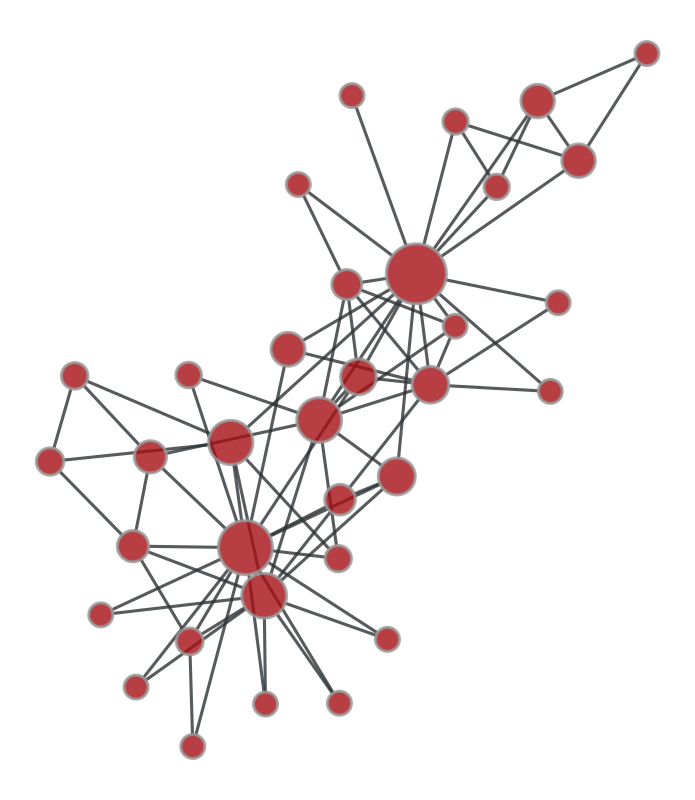

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x1db30f450, at 0x1bcb4af10>

In [55]:
# Betweenness
vb, eb = gt.betweenness(g)
print("Top 5 betweenness vertices:", np.argsort(vb.a)[-5:][::-1])

# Visualize betweenness as node size
pos = gt.sfdp_layout(g)
vsize = gt.prop_to_size(vb, mi=12, ma=30)
gt.graph_draw(g, pos=pos, vertex_size=vsize, output_size=(400,400))

## 10. Null models & simulation: Erdős-Rényi vs configuration models in `graph-tool`

A **null model** answers:

> *"What patterns would we expect even if nothing interesting is happening?"*

This is absolutely central to statistical thinking:
- we observe a statistic $T(G)$ on the real graph $G$
- we compare it to the distribution of $T(\tilde G)$ for graphs $\tilde G$ generated from a null model

---


### 10.1 Erdős-Rényi $G(N,p)$ / $G(N,E)$

Two common ER variants:

1) **$G(N,p)$**: each possible edge is present independently with probability $p$.  
2) **$G(N,E)$**: choose exactly $E$ edges uniformly at random from all $\binom{N}{2}$ possibilities.

For an undirected $G(N,p)$:

$$\mathbb{E}[k_i] = p(N-1),
\qquad
k_i \sim \mathrm{Binomial}(N-1, p).$$

A common "plug-in" estimate for $p$ given an observed graph with $N$ nodes and $E$ edges is:

$$\hat p = \frac{2E}{N(N-1)}.$$

In `graph-tool`, the fast way to sample something like $G(N,E)$ while keeping $N$ and $E$ fixed is rewiring:

```python
gt.random_rewire(g, model="erdos")
```

---


### 10.2 Configuration model (degree sequence preserved)

Many network statistics are heavily influenced by the degree sequence $\{k_i\}$. A stronger null model keeps degrees fixed while randomizing everything else. A configuration-model null preserves the degrees but randomizes the pairing of "stubs" (half-edges). In `graph-tool`, you can sample from a configuration-model-like ensemble via:

```python
gt.random_rewire(g, model="configuration")
```

Btw:

A quick back of the envelope derivation:

- Node $i$ has $k_i$ stubs.
- There are $2m$ stubs in total.
- Pick one stub from $i$. The probability it connects to a stub at node $j$ is roughly $k_j/(2m-1) \approx k_j/(2m)$.

Since $i$ has $k_i$ stubs, the expected number of $i\leftrightarrow j$ connections is approximately:

$$
\mathbb{E}[A_{ij}] \approx \frac{k_i k_j}{2m}.
$$

(This is the baseline term inside modularity!)

If you compare a real graph only to ER, you might mistake "heavy-tailed degrees" for "community structure". Configuration-model comparisons help you ask a sharper question:

> "Does this graph have structure beyond what degrees alone would produce?"


### 10.3 A simple hypothesis test by simulation (permutation test)

Let $T(G)$ be a statistic (e.g., global clustering).

- **Null hypothesis:** the graph was generated from a null model (ER or configuration)
- **Test statistic:** $T$
- **Monte Carlo p-value:**

$$\hat p = \frac{1 + \sum_{s=1}^{S} \mathbb{1}\{T(\tilde G_s) \ge T(G)\}}{S+1}.$$

We add 1 in numerator and denominator for a small-sample correction (avoids $p=0$).

---

### 10.4 Hands-on: compare clustering after rewiring

We'll start with one rewire (quick intuition), then do a simulation-based p-value.

In [56]:
# Start from the Karate Club graph
g0 = nx_to_gt(nx.karate_club_graph())

# Copy graphs before rewiring
g_erdos = gt.Graph(g0)
g_conf  = gt.Graph(g0)

gt.random_rewire(g_erdos, model="erdos", n_iter=10, edge_sweep=True)
gt.random_rewire(g_conf,  model="configuration", n_iter=10, edge_sweep=True)

459

In [57]:
# Degree sanity-check: configuration rewiring preserves degrees (ER does not)
deg0 = g0.degree_property_map("total").a
degE = g_erdos.degree_property_map("total").a
degC = g_conf.degree_property_map("total").a
print("Degrees preserved under configuration rewire?", np.all(deg0 == degC))
print("Degrees preserved under ER rewire?           ", np.all(deg0 == degE))

Degrees preserved under configuration rewire? True
Degrees preserved under ER rewire?            False


In [58]:
# Compare global clustering
c0 = gt.global_clustering(g0)[0]
cE = gt.global_clustering(g_erdos)[0]
cC = gt.global_clustering(g_conf)[0]

print("Global clustering:")
print("  original        :", round(c0, 3))
print("  ER (G(N,E))     :", round(cE, 3))
print("  configuration   :", round(cC, 3))

Global clustering:
  original        : 0.256
  ER (G(N,E))     : 0.117
  configuration   : 0.205


In [59]:
g0 = nx_to_gt(nx.karate_club_graph())
c_obs = gt.global_clustering(g0)[0]

S = 10000
c_erdos = []
c_conf  = []

In [60]:
for _ in range(S):
    gE = gt.Graph(g0)
    gt.random_rewire(gE, model="erdos", n_iter=10, edge_sweep=True)
    c_erdos.append(gt.global_clustering(gE)[0])

    gC = gt.Graph(g0)
    gt.random_rewire(gC, model="configuration", n_iter=10, edge_sweep=True)
    c_conf.append(gt.global_clustering(gC)[0])

In [61]:
c_erdos = np.array(c_erdos)
c_conf  = np.array(c_conf)

In [62]:
def mc_pvalue(null_samples, obs):
    return (1 + np.sum(null_samples >= obs)) / (len(null_samples) + 1)

In [63]:
pE = mc_pvalue(c_erdos, c_obs)
pC = mc_pvalue(c_conf,  c_obs)

print(f"Observed global clustering: {c_obs:.4f}")
print(f"Monte Carlo p-value under ER rewiring         : {pE:.4f}")
print(f"Monte Carlo p-value under configuration model : {pC:.4f}")

Observed global clustering: 0.2557
Monte Carlo p-value under ER rewiring         : 0.0003
Monte Carlo p-value under configuration model : 0.1232


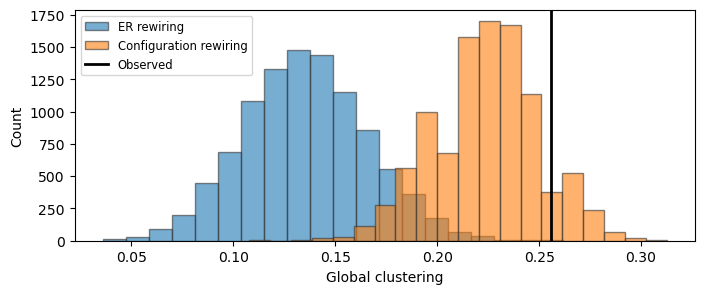

In [64]:
# Visualize the null distributions
plt.figure(figsize=(8,3), dpi=100)

plt.hist(c_erdos, bins=20, alpha=0.6, label="ER rewiring", ec='.2')
plt.hist(c_conf,  bins=20, alpha=0.6, label="Configuration rewiring", ec='.2')
plt.axvline(c_obs, linewidth=2, label="Observed", color='k')

plt.xlabel("Global clustering")
plt.ylabel("Count")
plt.legend(fontsize='small')

plt.show()

### Check-in

1. In the Erdős-Rényi $G(n,p)$ model, what do we match when we choose $p$ from an observed graph?
2. In the configuration model (degree-preserving rewiring), what *structure* is explicitly preserved, and what is allowed to change?
3. If you compute a community score (like modularity) on an observed graph, what is the right baseline question to ask before interpreting it?
4. When you choose a null model, what is the trade-off between "too simple" and "too constrained"?


## Break!

<p>
<img src="images/graphtool.png" width="2000">
</p>

________
## 11. Stochastic block models (SBMs): from sociology to modern inference

Before we talk about *inference*, we need a clear mental model of what an SBM is.

### 11.1 The core idea

An SBM assumes:
1. Each node belongs to a latent group (block) $b_i \in \{1,2,\dots,B\}$
2. Edge probabilities depend on groups: $P(A_{ij}=1 \mid b_i=r, b_j=s) = p_{rs}$
3. We infer the partition $\mathbf{b}$ (and sometimes $B$) from the observed graph.

That is: communities are parameters in a generative model, not just "clusters".

### 11.2 A short sociology history (why this is a social science model!)

SBMs originated in social science and statistics to model *roles* and *positions*:
- not only "assortative communities" (dense within groups),
- but also:
  - core-periphery
  - bipartite structure
  - hierarchical roles
  - disassortative mixing

### 11.3 Why nested SBMs?

Real networks often have structure at *multiple scales*:
- a few big clusters, each containing subclusters, etc.

Nested SBMs encode this with a hierarchy.

![](images/nested_sbm.png)

### 11.4 The canonical SBM likelihood (edges independent given blocks)

For this, it'll helps to write down the likelihood explicitly. Assume an undirected simple graph with adjacency matrix $A$ and a block assignment $b_i \in \{1,\dots,B\}$. A (canonical) SBM says:

- For each pair $i<j$, the edge indicator $A_{ij}$ is Bernoulli
- The Bernoulli parameter depends only on the blocks $(b_i, b_j)$

$$
P(A_{ij}=1 \mid b_i=r, b_j=s) = p_{rs}.
$$

Assuming conditional independence across pairs $(i,j)$, the likelihood is:

$$
P(A \mid \mathbf{b}, \mathbf{p})
= \prod_{i<j} p_{b_i b_j}^{A_{ij}}\,(1-p_{b_i b_j})^{1-A_{ij}}.
$$

#### Sufficient statistics: edge counts between blocks

Define:

- $m_{rs}$ = number of observed edges between blocks $r$ and $s$
- $n_{rs}$ = number of *possible* pairs between blocks $r$ and $s$

For an undirected graph with block sizes $n_r$:

- if $r \neq s$: $n_{rs} = n_r n_s$
- if $r = s$: $n_{rr} = \binom{n_r}{2}$

Then the log-likelihood can be written (up to constants) as:

$$
\log P(A \mid \mathbf{b}, \mathbf{p})
= \sum_{r\le s} \Bigl[
m_{rs}\log p_{rs} + (n_{rs}-m_{rs})\log(1-p_{rs})
\Bigr].
$$

#### MLE of $p_{rs}$

Differentiate w.r.t. $p_{rs}$ and set to zero:

$$
\frac{\partial}{\partial p_{rs}}
\Bigl[m_{rs}\log p_{rs} + (n_{rs}-m_{rs})\log(1-p_{rs})\Bigr]
= \frac{m_{rs}}{p_{rs}} - \frac{n_{rs}-m_{rs}}{1-p_{rs}} = 0.
$$

Solve for $p_{rs}$:

$$
\hat p_{rs} = \frac{m_{rs}}{n_{rs}}.
$$

So: given a partition, the best-fitting block probabilities are just the edge density between the blocks.

---

### 11.5 Degree Correction

A "vanilla" SBM can accidentally use blocks to explain degree variation (i.e., hubs become their own communities). A *degree-corrected SBM* adds per-vertex parameters (often written $\theta_i$) so the model can match heavy-tailed degrees without inventing extra blocks. One common formulation (for multigraphs / Poisson edges) is:

$$
A_{ij} \sim \text{Poisson}(\theta_i\theta_j\,\omega_{b_i b_j}),
$$

where $\omega_{rs}$ is a block-level connectivity parameter and $\theta_i$ is a node-specific propensity.

The high-level point is simple:

- $\theta_i$ explains "how active" node $i$ is
- blocks explain "who connects to whom beyond degree effects"

`graph-tool` supports degree correction and (crucially) uses MDL to decide whether the extra complexity is worth it.

A **degree-corrected SBM** separates:
- community/block structure
- individual node degree propensity

In `graph-tool`, degree correction is commonly controlled with:
```python
state_args=dict(deg_corr=True)   # degree-corrected SBM
state_args=dict(deg_corr=False)  # non-degree-corrected SBM
```

---


### 11.6 Hands-on: generate a synthetic SBM with `graph-tool`

We'll generate a 3-block assortative network and visualize it.


**Important implementation detail (graph-tool vs "Class 04" SBM from last week):**

`gt.generate_sbm()` does *not* take a matrix of Bernoulli probabilities $p_{rs}$. Instead, its `probs[r, s]` parameter is an **edge propensity**: the *expected number of edges* between blocks $r$ and $s$ under a Poisson/multigraph SBM. If you want the familiar Bernoulli SBM probabilities $p_{rs}$, you can still use them — you just convert them to expected edge counts using the group sizes. Let $n_r$ be the number of vertices in block $r$.

- For $r \neq s$ (between blocks), the number of possible pairs is $n_r n_s$, so $\mathbb{E}[m_{rs}] = p_{rs}\,n_r n_s$. You should pass `probs[r, s] = p_rs * n_r * n_s`.

- For $r = s$ (within a block), the number of possible pairs is $\binom{n_r}{2}$, so $\mathbb{E}[m_{rr}] = p_{rr}\,\binom{n_r}{2}.$ In the `graph-tool` convention for undirected graphs, you pass **twice** that value on the diagonal: $\texttt{probs[r, r]} = 2\,\mathbb{E}[m_{rr}] = p_{rr}\,n_r(n_r-1).$

For sparse graphs (small $p_{rs}$), the Poisson and Bernoulli formulations behave very similarly. If you push $p_{rs}$ into the dense regime, the Poisson model can generate multi-edges (which `graph-tool` can represent). If you need a strictly simple graph, you can use the `condensed=True` option or sample from a microcanonical model (see Appendix A).

In [65]:
# Create a planted partition: 3 blocks of equal size
n_per_block = 50
b = np.repeat(np.arange(3), n_per_block)

p_in_pair  = 0.125   # per-pair within-block probability
p_out_pair = 0.005   # per-pair between-block probability

n = n_per_block

p_in  = p_in_pair  * n * (n - 1)   # = 2 * E[m_rr] for undirected
p_out = p_out_pair * n * n         # = E[m_rs] for r != s

probs = np.array([
    [p_in,  p_out, p_out],
    [p_out, p_in,  p_out],
    [p_out, p_out, p_in ],
], dtype=float)


In [66]:
g = gt.generate_sbm(b, probs, directed=False)
g.vp["block_true"] = g.new_vp("int", vals=b)

print("Generated SBM: V =", g.num_vertices(), "E =", g.num_edges())

Generated SBM: V = 150 E = 469


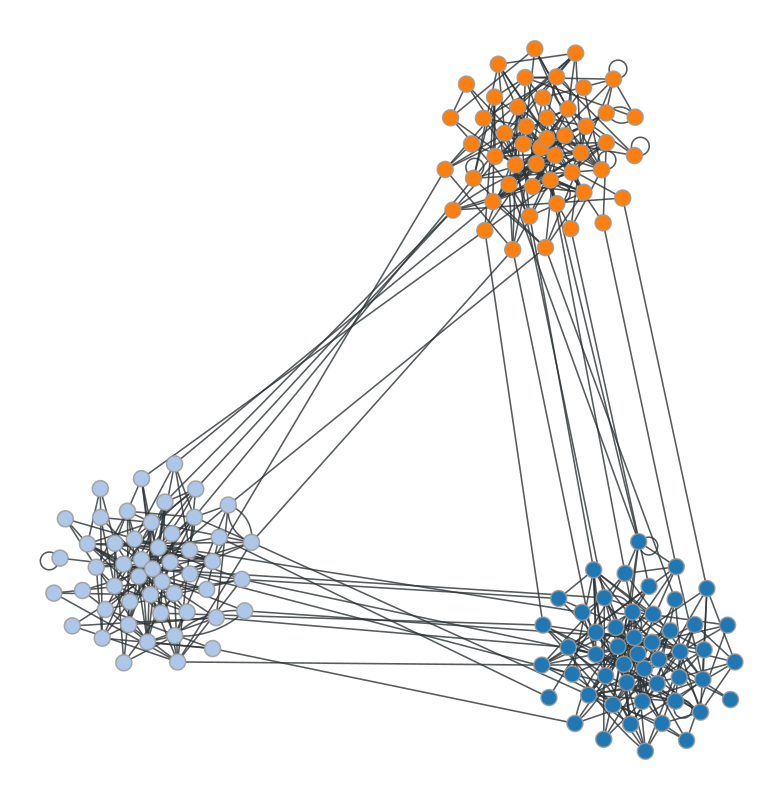

In [67]:
# Layout guided by true groups (helps drawing)
pos = gt.sfdp_layout(g, groups=g.vp.block_true)

gt.graph_draw(
    g, pos=pos,
    vertex_fill_color=g.vp.block_true,
    vertex_size=8,
    output_size=(400, 400)
);

### 11.6 Estimate $\hat p_{rs} = m_{rs}/n_{rs}$ from a generated SBM

We generated the graph using a known block probability matrix `probs`.

Now we'll treat the graph as "observed data" and (pretending we know the true partition) compute:

- $m_{rs}$: edge counts between blocks
- $n_{rs}$: possible pairs between blocks
- $\hat p_{rs} = m_{rs}/n_{rs}$: the canonical SBM MLE

This is a nice sanity check that the math and code agree.


In [68]:
# Count edges between blocks in the generated graph
b_true = g.vp["block_true"].a
B = int(b_true.max() + 1)

In [69]:
# Block sizes
n_r = np.array([(b_true == r).sum() for r in range(B)])

In [70]:
# Possible pairs n_rs
n_rs = np.zeros((B, B), dtype=float)
for r in range(B):
    for s in range(B):
        if r == s:
            n_rs[r, s] = n_r[r] * (n_r[r] - 1) / 2
        else:
            n_rs[r, s] = n_r[r] * n_r[s]

In [71]:
# Observed edges m_rs (undirected, count each edge once)
m_rs = np.zeros((B, B), dtype=float)
for e in g.edges():
    r = int(b_true[int(e.source())])
    s = int(b_true[int(e.target())])
    m_rs[r, s] += 1
    m_rs[s, r] += 1  # symmetric fill

In [72]:
# For undirected graphs, the diagonal was double-counted above (because r==s adds twice).
for r in range(B):
    m_rs[r, r] /= 2.0

p_hat = m_rs / n_rs

In [73]:
print("True p matrix used to generate:")
print(np.round(probs, 3))
print("\nEstimated p_hat = m_rs / n_rs:")
print(np.round(p_hat, 3))

True p matrix used to generate:
[[306.25  12.5   12.5 ]
 [ 12.5  306.25  12.5 ]
 [ 12.5   12.5  306.25]]

Estimated p_hat = m_rs / n_rs:
[[0.122 0.005 0.004]
 [0.005 0.113 0.003]
 [0.004 0.003 0.123]]


### 11.7 Runtime and scaling: which community detection algorithms you can actually run

When people say "community detection," they often mean *very different* computational problems.

It helps to sort algorithms into a few big families:

1. **Edge-removal / divisive methods** (classic Girvan-Newman)
2. **Objective maximization heuristics** (modularity: greedy, Louvain, Leiden)
3. **Flow / coding methods** (Infomap / map equation)
4. **Spectral relaxations** (eigenvectors of Laplacians / modularity matrices)
5. **Generative-model inference** (SBMs: canonical/microcanonical, nested, overlapping)

These families differ in:
- what they optimize (a score? a likelihood? a code length?)
- what they assume (null models, flow models, generative models)
- and very practically: **what graph sizes they can handle**.

#### A rough scaling comparison (rule-of-thumb, sparse graphs)

Let $n$ = number of nodes and $m$ = number of edges.

| Method family | Typical goal | Scaling intuition | What it's good for | What breaks |
|---|---|---:|---|---|
| Girvan-Newman (edge betweenness removal) | "cut" bridges between groups | **very expensive** (repeated betweenness computations) | teaching + tiny networks | anything beyond a few thousand edges |
| Modularity heuristics (Louvain/Leiden) | maximize $Q$ | **fast** in practice (often near-linear in $m$ per pass) | very large graphs, quick partitions | resolution limit, degeneracy, "high $Q$ by chance," no uncertainty |
| Spectral clustering | relax discrete partition into eigenvectors | sparse eigensolvers can scale well, but still heavier than Louvain | clean blocky structure, embeddings | must choose $B$; can be brittle in noisy graphs |
| Infomap / map equation | compress random-walk flow | typically fast in practice | flow-based communities | sensitive to dynamics assumptions |
| SBM inference (`graph-tool`) | maximize posterior / minimize description length | often scales well in $m$, but with larger constant factors | principled model selection; uncertainty; "no communities" is allowed | model mismatch; heavier than pure heuristics |

#### "Explicit" big-$O$ intuition (don't take these as promises)

These are the most common back-of-the-envelope statements you'll see:

- **Girvan-Newman (edge betweenness):**  
  computing edge betweenness via Brandes is $O(nm)$ for unweighted graphs.  
  If you recompute it after each edge removal for up to $m$ removals, you get roughly $O(nm^2)$ in the worst case.

- **Greedy modularity (agglomerative):**  
  can be around $O(m\log n)$ to $O(mn)$ depending on implementation details (and how much bookkeeping is maintained).  
  In practice it's often "fine" for medium graphs and then suddenly not fine.

- **Louvain / Leiden:**  
  usually described as approximately $O(m)$ per pass for sparse graphs (with a small number of passes), which is why they're popular at scale.

- **Spectral methods:**  
  computing the top $k$ eigenvectors of a sparse matrix can be about $O(km)$ per iteration of Lanczos/Arnoldi, times the number of iterations to converge.

- **SBM inference (graph-tool):**  
  the inference moves are designed so that many operations scale roughly with the number of affected edges, and a full sweep is often described as "about $O(m)$" (again: with constant factors and convergence time that depend on the data and the move set).

Two things to internalize:

- **There is no free lunch.** A method that returns uncertainty, chooses $B$, and avoids overfitting *must* do more work than a simple greedy score maximizer.
- **Implementation matters.** `graph-tool` is fast because the heavy lifting is in C++ and the inference moves are carefully engineered.

#### Micro-benchmark: how runtimes grow with graph size

Below is a classroom-scale benchmark.  
It is not a "publishable benchmark," but it will give you a feel for how runtimes respond to $n$ and $m$.

> If this runs slowly on your machine, reduce `sizes` or reduce the number of trials.


In [74]:
import time

# -------------------------
# Helper: generate a planted SBM in NetworkX
# (We keep average degree roughly constant as n grows.)
# -------------------------
def planted_sbm_nx(n, B=4, c_in=12, c_out=2, seed=0):
    rng = np.random.default_rng(seed)
    sizes = [n // B] * B
    for i in range(n - sum(sizes)):
        sizes[i] += 1

    # Probabilities scale like 1/n to keep expected degree O(1)
    p_in  = c_in / n
    p_out = c_out / n
    p = [[p_in if r == s else p_out for s in range(B)] for r in range(B)]

    G = nx.stochastic_block_model(sizes, p, seed=seed)
    return G

# -------------------------
# Timing wrappers
# -------------------------
def time_call(fn, *args, **kwargs):
    t0 = time.perf_counter()
    out = fn(*args, **kwargs)
    t1 = time.perf_counter()
    return (t1 - t0), out

def nx_louvain_partition(G):
    # NetworkX built-in Louvain (if available); returns list of sets
    parts = louvain_communities(G, seed=0)
    return parts

def nx_greedy_partition(G):
    # Greedy modularity (Clauset-Newman-Moore style)
    parts = list(nx.algorithms.community.greedy_modularity_communities(G))
    return parts

def nx_girvan_one_split(G):
    # Girvan-Newman is expensive; here we only compute the FIRST split.
    gen = nx.algorithms.community.girvan_newman(G)
    first = next(gen)
    return list(first)

def gt_nested_sbm(g_gt):
    state = gt.minimize_nested_blockmodel_dl(g_gt, state_args=dict(deg_corr=True))
    return state

In [75]:
# -------------------------
# Benchmark settings
# -------------------------
sizes = [300, 600, 1200]
sizes = np.logspace(2,4.2,11).astype(int)
results = []

for n in sizes:
    print(n)
    G = planted_sbm_nx(n, B=4, c_in=12, c_out=2, seed=0)
    m = G.number_of_edges()

    row = dict(n=n, m=m)

    t, _ = time_call(nx_louvain_partition, G)
    row["nx_louvain_sec"] = t

    # Greedy modularity (usually slower than Louvain, still OK for moderate n)
    t, _ = time_call(nx_greedy_partition, G)
    row["nx_greedy_mod_sec"] = t

    # Girvan-Newman (very expensive): only run on the smallest size
    if n == min(sizes):
        t, _ = time_call(nx_girvan_one_split, G)
        row["nx_girvan_firstsplit_sec"] = t
    else:
        row["nx_girvan_firstsplit_sec"] = np.nan
    # graph-tool nested SBM inference (convert graph first)
    g_gt = nx_to_gt(G)
    t, _ = time_call(gt_nested_sbm, g_gt)
    row["gt_nested_sbm_sec"] = t
    results.append(row)

100
165
275
457
758
1258
2089
3467
5754
9549
15848


In [76]:
df_bench = pd.DataFrame(results)
df_bench

n      m  nx_louvain_sec  nx_greedy_mod_sec  nx_girvan_firstsplit_sec  \
0     100    227        0.003877           0.008788                   0.45717   
1     165    380        0.008322           0.015947                       NaN   
2     275    665        0.013468           0.031309                       NaN   
3     457   1071        0.033863           0.057222                       NaN   
4     758   1739        0.049559           0.111910                       NaN   
5    1258   2870        0.149229           0.230443                       NaN   
6    2089   4675        0.230197           0.364013                       NaN   
7    3467   7749        0.483637           0.841206                       NaN   
8    5754  13012        1.034566           1.727181                       NaN   
9    9549  21578        7.369839           3.465299                       NaN   
10  15848  35647        3.419398           6.380410                       NaN   

    gt_nested_sbm_sec  
0            0.159801  
1            0.208915  
2            0.303977  
3            0.476273  
4            0.846667  
5            1.537314  
6            3.343968  
7            5.056874  
8            5.347795  
9            8.966233  
10          17.006851

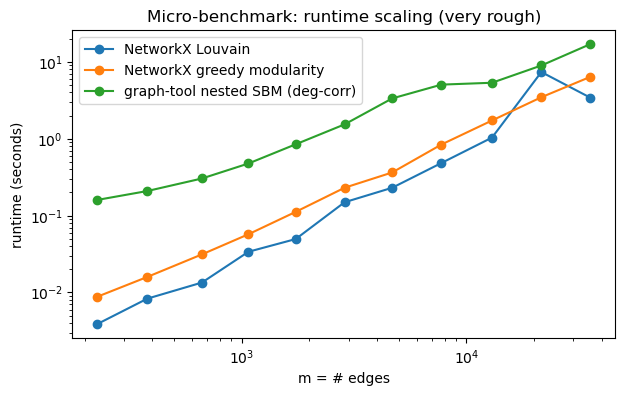

In [77]:
# Quick log-log plot (runtime vs edges)
plt.figure(figsize=(7,4),dpi=100)

plt.plot(df_bench["m"], df_bench["nx_louvain_sec"], marker="o", label="NetworkX Louvain")
plt.plot(df_bench["m"], df_bench["nx_greedy_mod_sec"], marker="o", label="NetworkX greedy modularity")
plt.plot(df_bench["m"], df_bench["gt_nested_sbm_sec"], marker="o", label="graph-tool nested SBM (deg-corr)")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("m = # edges")
plt.ylabel("runtime (seconds)")
plt.title("Micro-benchmark: runtime scaling (very rough)")
plt.legend()


plt.show()

## 12. Statistical inference primer: Bayes, evidence, and MDL (with code)

This section is intentionally **slow and explicit**.  
If you've never taken a statistics class, that's okay — read carefully and run the code.

We'll build an intuition that transfers directly to SBMs in `graph-tool`.

---

### 12.1 A data-generating story (a.k.a. a model)

A statistical model is a **story** for how data are generated.

- Data: $D$ (for networks, typically the adjacency matrix $A$ or edge list)
- Parameters: $\theta$ (numbers we don't know)
- Model class: $M$ (assumptions + which distributions are used)

The model gives you probabilities like:

$$P(D \mid \theta, M).$$

---


### 12.2 Likelihood and log-likelihood

The **likelihood function** is:

$$L(\theta) = P(D \mid \theta, M).$$

We often work with the **log-likelihood**:

$$\ell(\theta) = \log L(\theta),$$

because:
- products of probabilities become sums
- underflow is avoided
- gradients are easier

---


### 12.3 Maximum likelihood (MLE)

The MLE is:

$$\hat \theta_{\mathrm{MLE}} = \arg\max_\theta P(D \mid \theta, M)
= \arg\max_\theta \ell(\theta).$$

**Big idea:** MLE focuses on *fit* only (can overfit).

---


### 12.4 Prior beliefs (Bayesian modeling)

A Bayesian model adds a **prior**:

$$P(\theta \mid M).$$

This encodes what values of $\theta$ are plausible *before seeing data*.

---


### 12.5 Posterior (Bayes' rule)

After observing data $D$, we update our beliefs:

$$P(\theta \mid D, M) = \frac{P(D \mid \theta, M)\,P(\theta \mid M)}{P(D \mid M)}.$$

Where the denominator $P(D \mid M)$ is the **evidence**.

---


### 12.6 Evidence (marginal likelihood)

$$P(D \mid M) = \int P(D \mid \theta, M)\,P(\theta \mid M)\,d\theta.$$

Evidence is the probability your model assigns to the data *after averaging over parameter uncertainty*.

A flexible model can fit many datasets, but that means its probability mass is spread thinly → evidence can be small unless the data truly support the complexity.

This is one formalization of "Occam's razor".

---


### 12.7 Model comparison (Bayes factors)

For two models $M_0, M_1$:

$$\mathrm{BF}_{10} = \frac{P(D \mid M_1)}{P(D \mid M_0)}.$$

If $\mathrm{BF}_{10} \gg 1$, the data support $M_1$ over $M_0$ (assuming equal prior odds).

---


### 12.8 Bits, nats, and description length

Information-theoretic coding says:

- a probability $P$ corresponds to a code length $-\log P$

If we use natural logs:

$$\text{code length (nats)} = -\ln P.$$

If we use base-2 logs:

$$\text{code length (bits)} = -\log_2 P.$$

Conversion:

$$\text{bits} = \frac{\text{nats}}{\ln 2}.$$

---


### 12.9 Minimum description length (MDL): inference as compression

MDL reframes inference as compression:

> The best model is the one that lets you describe the data in the fewest bits.

A useful mental model:

$$\Sigma(M, \theta, D) \approx -\log P(D, \theta \mid M)
= -\log P(D\mid\theta, M) - \log P(\theta\mid M),$$

and if the model also has latent structure (like communities) you include that too:

$$-\log P(D, \theta, b \mid M).$$

So:
- smaller description length ↔ higher posterior probability
- choosing $B$ (number of blocks) becomes **model selection**

In `graph-tool`, you will see this directly:

- `state.entropy()` returns a description length $\Sigma$ (in nats)
- `minimize_blockmodel_dl()` searches for partitions minimizing $\Sigma$

---

<p>
<img src="images/mdl_spectrum.png" width="650">
</p>

### 12.10 A toy Bayesian inference problem: coin flips

We'll now do a fully worked example with equations and code.


### 12.10.1 Note: likelihood is not a probability distribution (and why conjugate priors feel magical)

One cthing that often trips people up:
- A *likelihood* $L(p) = P(D \mid p)$ is a function of $p$ given fixed data $D$.
- A *probability distribution* over $p$ must integrate to 1.

These are not the same object. For coin flips, the likelihood is:

$$
L(p) = P(k \mid p) \propto p^k (1-p)^{n-k}.
$$

If you *normalize* that function over $p \in [0,1]$, you get a proper density over $p$. With a uniform prior $p \sim \mathrm{Beta}(1,1)$, the *posterior density over $p$ is proportional to the likelihood*. 

So "posterior = normalized likelihood" is literally true *in that special case*.

We can show this!

In [78]:
from scipy.stats import beta as beta_dist

# Fix some fake coin flip data:
n = 20
k = 13

In [79]:
p_grid = np.linspace(1e-4, 1-1e-4, 2000)

In [80]:
# Likelihood as a function of p (up to a constant binomial coefficient)
L = (p_grid**k) * ((1 - p_grid)**(n - k))

In [81]:
# This is NOT a probability distribution over p:
area_L = np.trapezoid(L, p_grid)
print("Integral of likelihood over p (not 1):", area_L)

Integral of likelihood over p (not 1): 6.14280800039314e-07


In [82]:
# Normalize it by hand
L_norm = L / area_L
area_L_norm = np.trapezoid(L_norm, p_grid)
print("Integral after normalization:", area_L_norm)

Integral after normalization: 0.9999999999999999


In [83]:
# Under a uniform prior Beta(1,1), posterior is Beta(k+1, n-k+1)
post_pdf = beta_dist.pdf(p_grid, k + 1, n - k + 1)

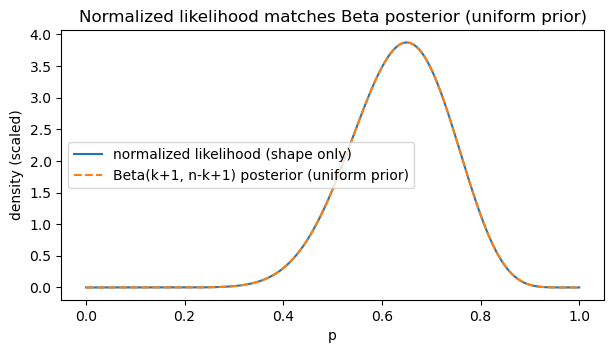

In [84]:
# Compare shapes
plt.figure(figsize=(7, 3.5),dpi=100)

plt.plot(p_grid, L_norm, label="normalized likelihood (shape only)")
plt.plot(p_grid, post_pdf, label="Beta(k+1, n-k+1) posterior (uniform prior)", ls='--')
plt.xlabel("p")
plt.ylabel("density (scaled)")
plt.title("Normalized likelihood matches Beta posterior (uniform prior)")
plt.legend()

plt.show()

In [85]:
# MLE is k/n
print("MLE p_hat = k/n =", k/n)

MLE p_hat = k/n = 0.65


### 12.11 Worked example: coin flips (Bernoulli + Beta)

This example is deliberately simple, but the logic transfers to SBMs. We observe flips $x_1, \dots, x_n$ with $x_i \in \{0,1\}$.

Let:
- $k = \sum_i x_i$ be the number of heads
- $n-k$ be the number of tails

#### Model (likelihood)

$$x_i \sim \mathrm{Bernoulli}(p)$$

So the likelihood is:

$$P(x \mid p) = \prod_{i=1}^n p^{x_i}(1-p)^{1-x_i}
= p^k (1-p)^{n-k}.$$

This is basically the Binomial likelihood written in "product form". A small but important move: take logs.

$$
\ell(p) = \log P(x\mid p)
= k\log p + (n-k)\log(1-p).
$$

This turns a product into a sum, and it also makes the geometry visible:
- $\ell(p)$ is *concave* (one hump, easier to find the max)
- the maximum occurs at $\hat p = k/n$ (we'll show this in code)

#### Prior: why a Beta prior?

Use a Beta prior:

$$p \sim \mathrm{Beta}(\alpha, \beta),
\qquad
P(p) = \frac{1}{B(\alpha,\beta)}\,p^{\alpha-1}(1-p)^{\beta-1}.$$


Why this prior shows up constantly:

1. Right support. $p$ lives on $[0,1]$, and Beta lives on $[0,1]$.
2. Conjugacy. The Bernoulli/Binomial likelihood has the form $p^k(1-p)^{n-k}$, and the Beta prior has the form $p^{\alpha-1}(1-p)^{\beta-1}$.  
   When you multiply them, you just add exponents → the posterior is Beta again.
3. Pseudo-count interpretation. A useful mental model:
   - $\alpha$ behaves like "prior heads + 1"
   - $\beta$ behaves like "prior tails + 1"
   - $\alpha+\beta$ controls how strongly the prior pulls on the posterior (an "equivalent sample size")
4. Convenient evidence. The Beta prior makes the evidence integral doable in closed form (Beta-Binomial). You want this when doing model selection.

Two common "default" choices:
- **Uniform** prior: $\mathrm{Beta}(1,1)$ (flat on $[0,1]$)
- **Jeffreys** prior: $\mathrm{Beta}(1/2, 1/2)$ (often used as a reparameterization-invariant default)

#### Posterior (conjugacy)

Multiply likelihood × prior:

$$P(p\mid x) \propto p^{k+\alpha-1}(1-p)^{(n-k)+\beta-1}$$

So:

$$p \mid x \sim \mathrm{Beta}(\alpha + k,\; \beta + n - k).$$


#### Other posterior summaries

Posterior mean:

$$\mathbb{E}[p\mid x] = \frac{\alpha+k}{\alpha+\beta+n}.$$

Posterior mode (MAP), when $\alpha+k>1$ and $\beta+n-k>1$:

$$p_{\mathrm{MAP}} = \frac{\alpha+k-1}{\alpha+\beta+n-2}.$$

Posterior predictive for a new flip:

$$P(x_{\mathrm{new}}=1 \mid x) = \mathbb{E}[p\mid x].$$

Next we compute all of these in code, and then we'll play with different priors to see what changes.

In [86]:
# Simulate coin flips (synthetic data)
rng = np.random.default_rng(3)

n = 40
p_true = 0.65
x = rng.binomial(1, p_true, size=n)

k = int(x.sum())
print(f"{k} heads out of {n} flips (true p={p_true})")

27 heads out of 40 flips (true p=0.65)


In [87]:
# ---------------------------
# 1) Frequentist MLE
# ---------------------------
p_mle = k / n
print("MLE p_hat = k/n =", round(p_mle, 3))

MLE p_hat = k/n = 0.675


In [88]:
# ---------------------------
# 2) Bayesian prior + posterior
# ---------------------------
alpha, beta = 1, 1  # Beta(1,1) = uniform prior on [0,1]
alpha_post = alpha + k
beta_post  = beta + (n - k)

# Posterior mean
p_mean = alpha_post / (alpha_post + beta_post)

# Posterior MAP (mode), defined only if alpha_post>1 and beta_post>1
if alpha_post > 1 and beta_post > 1:
    p_map = (alpha_post - 1) / (alpha_post + beta_post - 2)
else:
    p_map = np.nan

# Posterior variance
p_var = (alpha_post * beta_post) / (((alpha_post + beta_post) ** 2) * (alpha_post + beta_post + 1))

print("Posterior mean E[p|x] =", round(p_mean, 3))
print("Posterior MAP  p_MAP  =", round(p_map, 3))
print("Posterior sd          =", round(np.sqrt(p_var), 3))

Posterior mean E[p|x] = 0.667
Posterior MAP  p_MAP  = 0.675
Posterior sd          = 0.072


In [89]:
# ---------------------------
# 3) Posterior credible interval
# ---------------------------
p_samps = rng.beta(alpha_post, beta_post, size=50_000)
ci = np.quantile(p_samps, [0.025, 0.975])
print("95% credible interval:", tuple(np.round(ci, 3)))

95% credible interval: (np.float64(0.518), np.float64(0.8))


In [90]:
# ---------------------------
# 4) Posterior predictive check
# ---------------------------
# Predict number of heads in m future flips by sampling p ~ posterior, then Binomial(m,p)
m = 40
p_post = rng.beta(alpha_post, beta_post, size=20_000)
k_future = rng.binomial(m, p_post)

print("Posterior predictive: E[#heads in next 40 flips] ≈", round(k_future.mean(), 1))

Posterior predictive: E[#heads in next 40 flips] ≈ 26.7


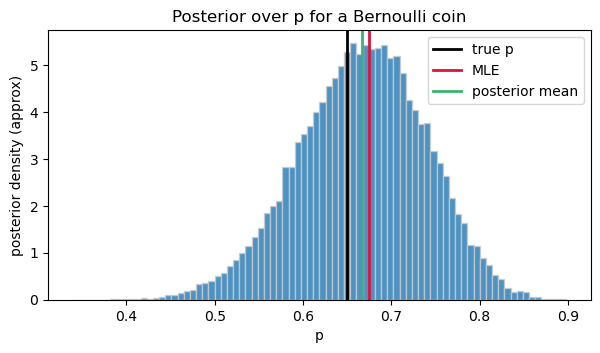

In [91]:
# ---------------------------
# Plot posterior over p
# ---------------------------
plt.figure(figsize=(7, 3.5), dpi=100)

plt.hist(p_samps, bins=80, density=True, alpha=0.8, ec='.8')
plt.axvline(p_true, linewidth=2, label="true p", color='k')
plt.axvline(p_mle,  linewidth=2, label="MLE", color='crimson')
plt.axvline(p_mean, linewidth=2, label="posterior mean", color='mediumseagreen')

plt.xlabel("p")
plt.ylabel("posterior density (approx)")
plt.title("Posterior over p for a Bernoulli coin")
plt.legend()

plt.show()

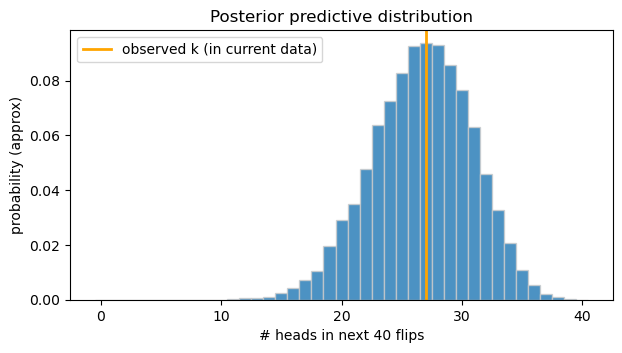

In [92]:
# Plot posterior predictive distribution over future heads
plt.figure(figsize=(7, 3.5), dpi=100)

plt.hist(k_future, bins=np.arange(m+2)-0.5, density=True, alpha=0.8, ec='.8')
plt.axvline(k, linewidth=2, label="observed k (in current data)", color='orange')

plt.xlabel(f"# heads in next {m} flips")
plt.ylabel("probability (approx)")
plt.title("Posterior predictive distribution")
plt.legend()

plt.show()

#### 12.11.1 Note: priors as pseudo-counts (and how "strong" a prior is)

In Beta-Bernoulli models, $\alpha$ and $\beta$ can be read as *pseudo-counts*:

- prior "heads" $\approx \alpha - 1$
- prior "tails" $\approx \beta - 1$
- prior strength $\approx \alpha + \beta$ (bigger means the prior matters more)

Let's keep the same data and compare several priors.

In [93]:
from scipy.stats import beta as beta_dist

# We'll re-use the observed k and n from the previous cell.
priors = [
    ("Uniform  Beta(1,1)", 1, 1),
    ("Jeffreys Beta(1/2,1/2)", 0.5, 0.5),
    ("Mild     Beta(2,2)", 2, 2),
    ("Strong   Beta(20,20)", 20, 20),
    ("Skewed   Beta(10,2)", 10, 2),
]

p_grid = np.linspace(1e-4, 1 - 1e-4, 2000)

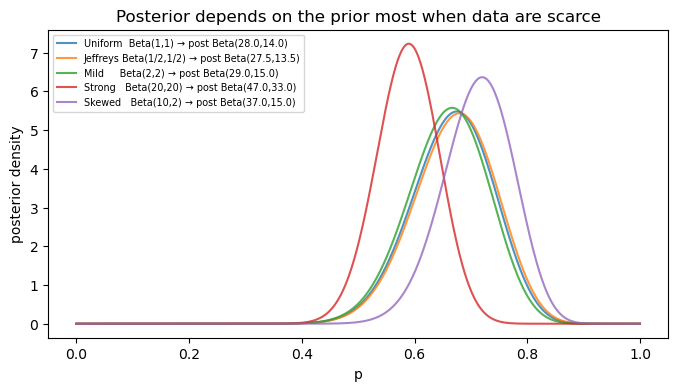

In [94]:
plt.figure(figsize=(8, 4), dpi=100)
for label, a, b in priors:
    a_post = a + k
    b_post = b + (n - k)

    pdf = beta_dist.pdf(p_grid, a_post, b_post)
    plt.plot(p_grid, pdf, label=f"{label} → post Beta({a_post:.1f},{b_post:.1f})", alpha=0.8)

plt.xlabel("p")
plt.ylabel("posterior density")
plt.title("Posterior depends on the prior most when data are scarce")
plt.legend(fontsize='x-small')


plt.show()

In [95]:
# Show posterior means numerically
rows = []
for label, a, b in priors:
    a_post = a + k
    b_post = b + (n - k)
    post_mean = a_post / (a_post + b_post)
    prior_mean = a / (a + b)
    rows.append(dict(prior=label, prior_mean=prior_mean, post_mean=post_mean, prior_strength=a+b))

pd.DataFrame(rows)

prior  prior_mean  post_mean  prior_strength
0      Uniform  Beta(1,1)    0.500000   0.666667             2.0
1  Jeffreys Beta(1/2,1/2)    0.500000   0.670732             1.0
2      Mild     Beta(2,2)    0.500000   0.659091             4.0
3    Strong   Beta(20,20)    0.500000   0.587500            40.0
4     Skewed   Beta(10,2)    0.833333   0.711538            12.0

### 12.12 Evidence and "Occam's razor" in a tiny model comparison

We'll compare two models:

- $M_0$: fair coin, fixed $p_0 = 0.5$ (no free parameters)
- $M_1$: unknown $p$, with prior $p \sim \mathrm{Beta}(\alpha,\beta)$

Let $k$ be the number of heads out of $n$ flips.

#### Evidence under the fair-coin model $M_0$

The probability of observing exactly $k$ heads is:

$$P(k \mid M_0) = \binom{n}{k} p_0^k (1-p_0)^{n-k}.$$

(If you treat the full sequence $x_1,\dots,x_n$ as the data, you can drop the $\binom{n}{k}$ term. Using $k$ as a sufficient statistic keeps it clean.)

#### Evidence under the unknown-$p$ model $M_1$

Start with:

$$P(k \mid p) = \binom{n}{k} p^k (1-p)^{n-k}, \qquad p \sim \mathrm{Beta}(\alpha,\beta).$$

Then integrate out $p$:

$$P(k \mid M_1) = \int_0^1 P(k \mid p)\,P(p)\,dp.$$

Because the Beta is conjugate to the Binomial, this integral has a closed form:

$$P(k \mid M_1) = \binom{n}{k}\,\frac{B(k+\alpha,\; n-k+\beta)}{B(\alpha,\beta)},$$

where the Beta function is:

$$B(a,b)=\frac{\Gamma(a)\Gamma(b)}{\Gamma(a+b)}.$$

#### Bayes factor

$$\mathrm{BF}_{10} = \frac{P(k\mid M_1)}{P(k\mid M_0)}.$$

A useful habit: compute this in log space:

$$\log \mathrm{BF}_{10} = \log P(k\mid M_1) - \log P(k\mid M_0).$$

_______
Now we compute these quantities in code, and interpret the Bayes factor as an "Occam factor". $M_1$ has flexibility, but it only wins if the data *demand* that flexibility.

#### 12.12.1 (Math breakaway) Doing the evidence integral step by step

We claimed (for the unknown-$p$ model):

$$ P(k \mid M_1) = \binom{n}{k}\,\frac{B(k+\alpha,\; n-k+\beta)}{B(\alpha,\beta)}.$$

Here is the algebra that gets you there.

Start with:

- Likelihood: $P(k\mid p) = \binom{n}{k} p^k (1-p)^{n-k}$
- Prior: $P(p) = \frac{1}{B(\alpha,\beta)}p^{\alpha-1}(1-p)^{\beta-1}$

Evidence is the integral:

$$
\begin{aligned}
P(k\mid M_1)
&= \int_0^1 P(k\mid p)P(p)\,dp \\
&= \int_0^1 \binom{n}{k} p^k (1-p)^{n-k}
\cdot \frac{1}{B(\alpha,\beta)}p^{\alpha-1}(1-p)^{\beta-1}\,dp \\
&= \binom{n}{k}\,\frac{1}{B(\alpha,\beta)}
\int_0^1 p^{k+\alpha-1}(1-p)^{n-k+\beta-1}\,dp.
\end{aligned}
$$

But the Beta function is defined as:

$$
B(a,b) = \int_0^1 t^{a-1}(1-t)^{b-1}\,dt.
$$


So our integral is exactly:

$$
\int_0^1 p^{k+\alpha-1}(1-p)^{n-k+\beta-1}\,dp
= B(k+\alpha,\; n-k+\beta).
$$

Plug it back in and we're done:

$$
P(k \mid M_1) = \binom{n}{k}\,\frac{B(k+\alpha,\; n-k+\beta)}{B(\alpha,\beta)}.
$$

We can verify the closed form with a numerical integral in code.

In [96]:
from scipy import integrate

# Small example (use the same notation as above)
n = 20
k = 13
alpha, beta = 2.0, 2.0

binom = special.comb(n, k, exact=False)
B_ab = special.beta(alpha, beta)

In [97]:
def integrand(p):
    prior = (p**(alpha - 1) * (1 - p)**(beta - 1)) / B_ab
    like  = binom * (p**k) * ((1 - p)**(n - k))
    return like * prior

num_int, num_err = integrate.quad(integrand, 0, 1)

closed_form = binom * special.beta(k + alpha, n - k + beta) / B_ab

print("Numerical integral:", num_int, "(±", num_err, ")")
print("Closed form      :", closed_form)
print("Absolute diff    :", abs(num_int - closed_form))

Numerical integral: 0.0632411067193676 (± 4.261971533342252e-13 )
Closed form      : 0.06324110671936757
Absolute diff    : 2.7755575615628914e-17


In [98]:
# We'll compute log-evidences to avoid underflow.

def log_choose(n, k):
    # log binomial coefficient using Gamma functions
    return special.gammaln(n + 1) - special.gammaln(k + 1) - special.gammaln(n - k + 1)

def log_evidence_fair(n, k, p0=0.5):
    # P(k | M0) = C(n,k) p0^k (1-p0)^(n-k)
    return log_choose(n, k) + k * np.log(p0) + (n - k) * np.log(1 - p0)

def log_evidence_beta_binomial(n, k, alpha=1, beta=1):
    # P(k | M1) = C(n,k) * B(k+alpha, n-k+beta) / B(alpha,beta)
    return (
        log_choose(n, k)
        + special.betaln(k + alpha, n - k + beta)
        - special.betaln(alpha, beta)
    )

In [99]:
# Use the k, n from the previous cell (coin flips)
le0 = log_evidence_fair(n, k, p0=0.5)
le1 = log_evidence_beta_binomial(n, k, alpha=1, beta=1)

log_bf_10 = le1 - le0
bf_10 = float(np.exp(log_bf_10))

print("log evidence M0 (fair):", round(le0, 3))
print("log evidence M1 (unknown p with Beta(1,1)):", round(le1, 3))
print("log Bayes factor log BF_10 =", round(log_bf_10, 3))
print("Bayes factor BF_10 =", round(bf_10, 3))

log evidence M0 (fair): -2.605
log evidence M1 (unknown p with Beta(1,1)): -3.045
log Bayes factor log BF_10 = -0.44
Bayes factor BF_10 = 0.644


In [100]:
# Convert log BF to bits (sometimes easier to interpret as "compression gain")
log_bf_bits = log_bf_10 / np.log(2)
print("log BF_10 in bits =", round(log_bf_bits, 3))

log BF_10 in bits = -0.635


### 12.13 Translating this to SBMs (networks)

For SBMs, the "coin flip" example generalizes like this:

- **Data** $D$: the graph $G$, often represented by an adjacency matrix $A$
- **Latent structure** $b$: a partition of nodes into blocks/communities
- **Parameters** $\theta$: quantities controlling edge probabilities/rates between blocks, and (sometimes) node propensities


A very simple **(canonical) SBM** story for an undirected simple graph:

1. Each node $i$ belongs to a block $b_i \in \{1,\dots,B\}$
2. For each pair $(i,j)$, generate an edge: $A_{ij} \sim \mathrm{Bernoulli}(p_{b_i b_j})$ such that $i<j$

so the likelihood is:

$$P(A \mid b, p) = \prod_{i<j} p_{b_i b_j}^{A_{ij}} (1-p_{b_i b_j})^{1-A_{ij}}.$$

A common (and important) extension is the **degree-corrected SBM (DC-SBM)**, which introduces node-level propensities so high-degree nodes don't force spurious communities. One convenient DC-SBM form uses Poisson edges:

$$A_{ij} \sim \mathrm{Poisson}(\theta_i \theta_j \,\omega_{b_i b_j}).$$

(There are several equivalent formulations; `graph-tool` uses microcanonical ensembles under the hood.)

---

### 12.14 Evidence and MDL in SBMs

The Bayesian goal is conceptually:

$$P(b \mid G, M) \propto P(G \mid b, M)\,P(b \mid M),$$

where

$$P(G \mid b, M) = \int P(G \mid b, \theta, M)\,P(\theta \mid M)\,d\theta.$$

In SBMs, the parameter space $\theta$ can be large, so `graph-tool` uses an MDL/Bayesian formulation where it minimizes a **description length**.

A useful heuristic you will use constantly with `graph-tool`:

- `state.entropy()` returns a description length $\Sigma$ (in nats)
- smaller $\Sigma$ means a more plausible partition/model

For comparing two modeling choices $M_1$ vs $M_0$ (e.g., degree-corrected vs not):

$$\frac{P(G\mid M_1)}{P(G\mid M_0)} \approx \exp\bigl(-(\Sigma_1-\Sigma_0)\bigr).$$

So a difference $\Delta\Sigma = \Sigma_1-\Sigma_0$ translates directly into an evidence ratio.

### 12.15 Quick connection: canonical SBM is "many coin flips" 
(and the Beta prior comes back in!) In the simple (canonical) SBM we wrote:

$$
P(A \mid b, p) = \prod_{i<j} p_{b_i b_j}^{A_{ij}} (1-p_{b_i b_j})^{1-A_{ij}}.
$$

A useful re-expression groups terms by block pairs. Let $N_r$ be the number of nodes in block $r$. Define the number of *possible* edges between blocks:
- if $r \neq s$: $n_{rs} = N_r N_s$
- if $r = s$: $n_{rr} = \binom{N_r}{2}$

and the number of *observed* edges between blocks:

$$m_{rs} = \sum_{i<j} A_{ij}\,\mathbf{1}\{b_i=r,\;b_j=s\}.$$

Then the likelihood can be rewritten as:

$$
P(A \mid b, p)
= \prod_{r \le s} p_{rs}^{m_{rs}} (1-p_{rs})^{n_{rs}-m_{rs}}.
$$

Now you can see the analogy:

- For each block pair $(r,s)$, you have $n_{rs}$ Bernoulli trials
- with $m_{rs}$ successes
- and unknown success probability $p_{rs}$

So it's literally "coin flips," repeated for every block pair.

#### Why the Beta prior is a natural default here

If we set independent priors

$$p_{rs} \sim \mathrm{Beta}(\alpha,\beta),$$

then for each block pair the integral

$$
\int_0^1 p_{rs}^{m_{rs}}(1-p_{rs})^{n_{rs}-m_{rs}} \,\frac{p_{rs}^{\alpha-1}(1-p_{rs})^{\beta-1}}{B(\alpha,\beta)}\,dp_{rs}
$$

has a closed form:

$$
\frac{B(m_{rs}+\alpha,\; n_{rs}-m_{rs}+\beta)}{B(\alpha,\beta)}.
$$

This is the same conjugacy story as the coin flip example — just repeated many times. Let's compute a toy version of this "integrated likelihood score" for two different partitions of the *same* graph.

In [101]:
# Toy canonical-SBM scoring function:
# - compute block-pair counts (m_rs and n_rs)
# - compute an integrated likelihood under Beta priors (log scale)

from collections import defaultdict

def block_pair_counts_undirected(G, b, B=None):
    """Return (m_rs, n_rs) for an undirected simple graph under partition b.

    - G: NetworkX graph with nodes 0..n-1
    - b: list/array of block labels length n (values 0..B-1)
    """
    n = G.number_of_nodes()
    if B is None:
        B = int(np.max(b)) + 1

    # block sizes
    N = np.bincount(np.asarray(b), minlength=B)

    # n_rs: number of potential edges between block pairs
    n_rs = np.zeros((B, B), dtype=int)
    for r in range(B):
        for s in range(r, B):
            if r == s:
                n_rs[r, s] = N[r] * (N[r] - 1) // 2
            else:
                n_rs[r, s] = N[r] * N[s]

    # m_rs: observed edges between block pairs
    m_rs = np.zeros((B, B), dtype=int)
    for u, v in G.edges():
        r = int(b[u]); s = int(b[v])
        if r > s:
            r, s = s, r
        m_rs[r, s] += 1

    return m_rs, n_rs

def log_marginal_canonical_sbm(G, b, alpha=1.0, beta=1.0):
    """Log P(A | b) under a canonical SBM with independent Beta(alpha,beta) priors on p_rs.
    This uses the *exact graph likelihood* (no binomial coefficient), grouped by block pairs.
    """
    m_rs, n_rs = block_pair_counts_undirected(G, b)
    B = m_rs.shape[0]

    # log marginal = sum_{r<=s} log B(m+alpha, n-m+beta) - log B(alpha,beta)
    total = 0.0
    for r in range(B):
        for s in range(r, B):
            m = m_rs[r, s]
            n = n_rs[r, s]
            if n == 0:
                continue
            total += special.betaln(m + alpha, (n - m) + beta) - special.betaln(alpha, beta)
    return float(total)

def log_likelihood_mle_canonical_sbm(G, b, eps=1e-12):
    """Plug-in log-likelihood using MLE p_hat = m_rs/n_rs for each block pair."""
    m_rs, n_rs = block_pair_counts_undirected(G, b)
    B = m_rs.shape[0]

    ll = 0.0
    for r in range(B):
        for s in range(r, B):
            m = m_rs[r, s]
            n = n_rs[r, s]
            if n == 0:
                continue

            # MLE p_hat = m/n, handle boundary cases carefully
            if m == 0:
                p = 0.0
            elif m == n:
                p = 1.0
            else:
                p = m / n

            # Contribution: m log p + (n-m) log(1-p)
            # (with careful handling of 0*log(0))
            if 0 < p < 1:
                ll += m * np.log(p) + (n - m) * np.log(1 - p)
            elif p == 0.0:
                ll += 0.0  # since m=0 and log(1)=0
            elif p == 1.0:
                ll += 0.0  # since n-m=0 and log(1)=0

    return float(ll)

In [102]:
# -------------------------
# Generate a small SBM graph with a known partition
# -------------------------
n1, n2 = 30, 30
sizes = [n1, n2]
p_in, p_out = 0.25, 0.02
p = [[p_in, p_out],
     [p_out, p_in]]

G = nx.stochastic_block_model(sizes, p, seed=1)

# True partition (2 blocks)
b_true = np.array([0]*n1 + [1]*n2)

# An over-split partition (4 blocks): split each true block in half
b_over = np.array([0]*(n1//2) + [1]*(n1 - n1//2) + [2]*(n2//2) + [3]*(n2 - n2//2))

print("Graph: n =", G.number_of_nodes(), "m =", G.number_of_edges())

Graph: n = 60 m = 229


In [103]:
# Compare plug-in log-likelihoods (fit only)
ll_true = log_likelihood_mle_canonical_sbm(G, b_true)
ll_over = log_likelihood_mle_canonical_sbm(G, b_over)

# Compare integrated log marginal likelihoods (fit + complexity penalty)
lm_true = log_marginal_canonical_sbm(G, b_true, alpha=1, beta=1)
lm_over = log_marginal_canonical_sbm(G, b_over, alpha=1, beta=1)

In [104]:
print("\nPlug-in log-likelihood (MLE p_rs):")
print("  2 blocks:", round(ll_true, 2))
print("  4 blocks:", round(ll_over, 2), "(should be >= 2-block, since it's more flexible)")


Plug-in log-likelihood (MLE p_rs):
  2 blocks: -583.68
  4 blocks: -579.11 (should be >= 2-block, since it's more flexible)


In [105]:
print("\nIntegrated log marginal likelihood (Beta priors on p_rs):")
print("  2 blocks:", round(lm_true, 2))
print("  4 blocks:", round(lm_over, 2), "(may go up or down; this is the Occam effect)")


Integrated log marginal likelihood (Beta priors on p_rs):
  2 blocks: -593.94
  4 blocks: -608.23 (may go up or down; this is the Occam effect)


In [106]:
print("\nDifference (4 - 2):")
print("  Δ log-likelihood:", round(ll_over - ll_true, 2))
print("  Δ log-marginal  :", round(lm_over - lm_true, 2))


Difference (4 - 2):
  Δ log-likelihood: 4.56
  Δ log-marginal  : -14.29


<!-- ### Checks for understanding (after §12)

1. In Bayes' rule $P(\theta\mid D) \propto P(D\mid \theta) P(\theta)$, which term is the likelihood and which is the prior? What does the proportionality hide?
2. Why does the evidence $P(D)$ tend to penalize overly flexible models, even when they can fit the data well?
3. In the Beta-Bernoulli example, interpret $(\alpha,\beta)$ as pseudo-counts. What changes when you make $(\alpha,\beta)$ very large?
4. "Likelihood is not a probability distribution." What does that sentence mean, concretely, in the coin-flip micro-example? -->


## 13. SBM inference in `graph-tool`: `minimize_blockmodel_dl` and nested SBMs

Now we do the thing that modularity *wanted* to do, but in a statistically grounded way.

`graph-tool` treats community detection as **latent-variable inference**.

- latent variable: partition $b$
- observed data: graph $G$ (adjacency $A$)
- model class: SBM (with options like degree correction, overlap, layers, hierarchy)

---

### 13.1 The one line of code to rule them all

```python
state = gt.minimize_blockmodel_dl(g)
```

This returns a `BlockState` object that contains:
- a partition of vertices into blocks (`state.get_blocks()`)
- inferred block structure (e.g., a block matrix via `state.get_matrix()`)
- a description length / entropy score (`state.entropy()`)


### 13.2 What is the objective function?

The goaal is to maximize:

$$P(b \mid G, M) \propto P(G \mid b, M)P(b\mid M).$$

In the MDL view, we minimize a description length:

$$\Sigma(b) \approx -\ln P(G, b \mid M)
= -\ln P(G\mid b,M) - \ln P(b\mid M).$$

So:
- **lower $\Sigma$** = better (higher posterior probability)
- the method automatically balances "fit" vs "complexity"
- the number of blocks $B$ is *selected* rather than fixed


### 13.2.1 Interpreting description length differences as evidence (a practical trick)

A `graph-tool` SBM fit gives you a description length (in nats) via:

```python
Sigma = state.entropy()
```

The key exponential relationship is:

$$
P(b \mid G) \propto \exp(-\Sigma(b)).
$$

So if you have two candidate partitions $b_1$ and $b_2$ (or two model variants), their posterior odds satisfy:

$$
\frac{P(b_1\mid G)}{P(b_2\mid G)}
\approx \exp\bigl(-[\Sigma(b_1)-\Sigma(b_2)]\bigr).
$$

That means:

- If $\Delta\Sigma = \Sigma_1-\Sigma_2 = 10$, then $b_1$ is downweighted by a factor of $e^{-10} \approx 0.000045$ relative to $b_2$.
- If you want **bits** instead of nats: $\Delta\Sigma_{\text{bits}} = \Delta\Sigma/\ln 2$.

This is the same logic as Bayes factors in Section 12 — just expressed in the MDL coding language.

We'll use this repeatedly:
- comparing `deg_corr=True` vs `deg_corr=False`
- comparing nested vs non-nested SBMs
- comparing "model explains the data" vs "model is overfitting"

### 13.3 What does the result mean?

- The partition is not "the truth" — it's a model-based explanation.
- The inferred $B$ is the model's *preferred complexity* given the priors.
- Many partitions may have similar posterior probability → uncertainty is real.

### 13.4 Degree-corrected vs non-degree-corrected

A practical workflow is:

1. fit with `deg_corr=True`
2. fit with `deg_corr=False`
3. compare description lengths

Lower description length (entropy) usually indicates the better explanation.

> In many empirical networks, degree correction is crucial: without it, "communities" can become proxies for "high-degree vs low-degree".

---

### 13.5 Hands-on: recover planted communities in a synthetic SBM

We start with a synthetic graph where the "ground truth" is known.

In [107]:
def posterior_odds_from_delta_sigma(delta_sigma):
    """Return odds = P(model1|data) / P(model2|data) given ΔΣ = Σ1 - Σ2 (nats)."""
    return math.exp(-delta_sigma)

# Example: interpret some common ΔΣ values
for dS in [0, 1, 2, 5, 10]:
    odds = posterior_odds_from_delta_sigma(dS)
    print(f"ΔΣ={dS:>2} nats -> odds ≈ e^(-ΔΣ) = {odds:.6f}")


ΔΣ= 0 nats -> odds ≈ e^(-ΔΣ) = 1.000000
ΔΣ= 1 nats -> odds ≈ e^(-ΔΣ) = 0.367879
ΔΣ= 2 nats -> odds ≈ e^(-ΔΣ) = 0.135335
ΔΣ= 5 nats -> odds ≈ e^(-ΔΣ) = 0.006738
ΔΣ=10 nats -> odds ≈ e^(-ΔΣ) = 0.000045


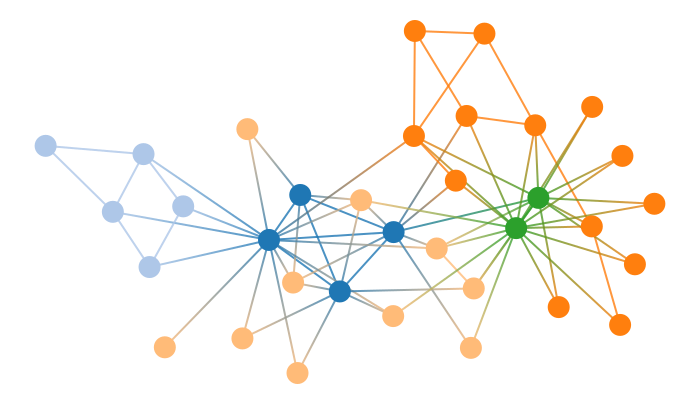

In [108]:
g = gt.collection.data['karate']
state = gt.minimize_blockmodel_dl(g, state_args=dict(deg_corr=False))

pos = gt.sfdp_layout(g)
state.draw(pos=pos, output_size=(350, 350), vertex_size=10);

In [109]:
rng = np.random.default_rng(1)
# Synthetic planted partition
n_per_block = 50
B = 3
b_true = np.repeat(np.arange(B), n_per_block)

# These are PER-PAIR probabilities (the intuitive thing)
p_in_pair = 0.15
p_out_pair = 0.01

# Convert to graph-tool's "probs" = expected edge counts between blocks
n = n_per_block
p_in  = p_in_pair  * n * (n - 1)   # = 2 * E[m_rr] for undirected
p_out = p_out_pair * n * n         # = E[m_rs] for r != s

probs = np.array([[p_in,  p_out, p_out],
                  [p_out, p_in,  p_out],
                  [p_out, p_out, p_in]], dtype=float)

g = gt.generate_sbm(b_true, probs, directed=False)
g.vp["b_true"] = g.new_vp("int", vals=b_true)


print("Generated SBM: V =", g.num_vertices(), "E =", g.num_edges())

Generated SBM: V = 150 E = 649


Inferred B: 4
Description length (entropy): 2321.32


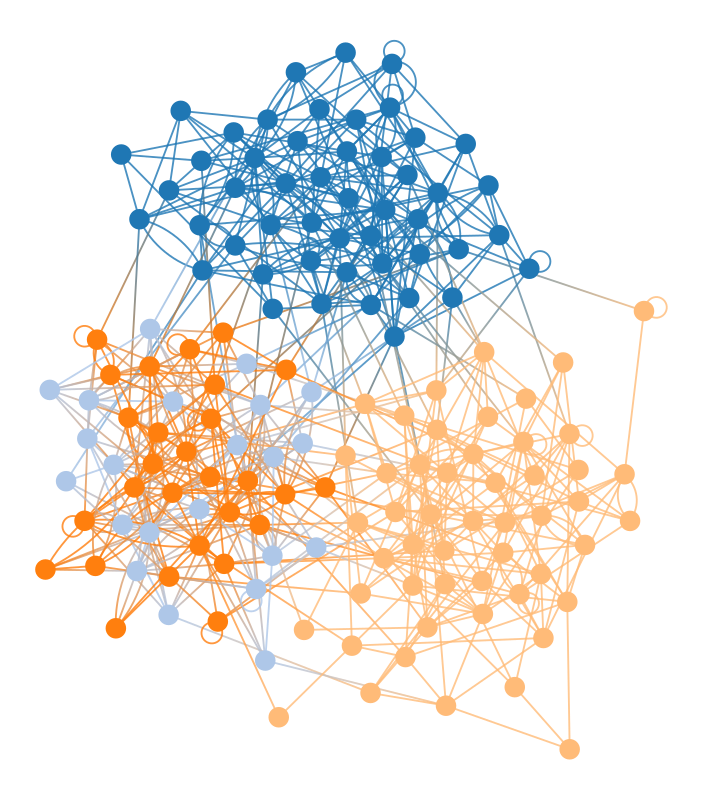

In [110]:
# Inference: non-degree-corrected SBM (fine for this toy)
state = gt.minimize_blockmodel_dl(g, state_args=dict(deg_corr=False))

b_hat = state.get_blocks()
B_hat = state.get_nonempty_B()
dl = state.entropy()

print("Inferred B:", B_hat)
print("Description length (entropy):", round(dl, 2))

pos = gt.sfdp_layout(g)
state.draw(pos=pos, output_size=(400,400));

### 13.5 Comparing degree-corrected vs not

Even on the *same* graph, different SBM variants can yield different explanations.

Let's compare:
- non-degree-corrected SBM
- degree-corrected SBM

and look at description lengths.


In [111]:
state_plain = gt.minimize_blockmodel_dl(g, state_args=dict(deg_corr=False))
state_dc    = gt.minimize_blockmodel_dl(g, state_args=dict(deg_corr=True))

print("Plain SBM:")
print("  B =", state_plain.get_nonempty_B(), "entropy =", round(state_plain.entropy(), 2))
print("Degree-corrected SBM:")
print("  B =", state_dc.get_nonempty_B(), "entropy =", round(state_dc.entropy(), 2))

Plain SBM:
  B = 3 entropy = 2299.96
Degree-corrected SBM:
  B = 6 entropy = 2424.6


### 13.6 Turning description length differences into evidence ratios

A powerful trick: compare two modeling choices (e.g., degree-corrected vs not) via:

$$\Delta \Sigma = \Sigma_1 - \Sigma_0.$$

If $\Sigma$ is a negative log probability (in nats), then:

$$\frac{P(G\mid M_1)}{P(G\mid M_0)} \approx \exp(-\Delta\Sigma).$$

So:

- if $\Delta\Sigma < 0$, model 1 is favored (higher evidence)
- if $\Delta\Sigma > 0$, model 0 is favored

You can also translate $\Delta\Sigma$ into bits:

$$\Delta\Sigma_{\mathrm{bits}} = \frac{\Delta\Sigma}{\ln 2}.$$

A difference of just **10 bits** corresponds to an evidence ratio of about $2^{10} \approx 1000$.

In [112]:
# We assume state_plain and state_dc exist from the previous cell.
S_plain = state_plain.entropy()
S_dc    = state_dc.entropy()

# Evidence ratio P(G|DC) / P(G|plain) ≈ exp(-(S_dc - S_plain))
dS = S_dc - S_plain
bf = float(np.exp(-dS))
dS_bits = dS / np.log(2)

print("Σ_plain =", round(S_plain, 3))
print("Σ_dc    =", round(S_dc, 3))
print("ΔΣ = Σ_dc - Σ_plain =", round(dS, 3), "nats =", round(dS_bits, 3), "bits")
print("Approx evidence ratio  P(G|DC) / P(G|plain) ≈ exp(-ΔΣ) =", round(bf, 3))

# Inspect block matrices
best = state_dc if S_dc < S_plain else state_plain
mat = best.get_matrix()  # sparse matrix of edge counts between blocks

Σ_plain = 2299.955
Σ_dc    = 2424.601
ΔΣ = Σ_dc - Σ_plain = 124.646 nats = 179.826 bits
Approx evidence ratio  P(G|DC) / P(G|plain) ≈ exp(-ΔΣ) = 0.0


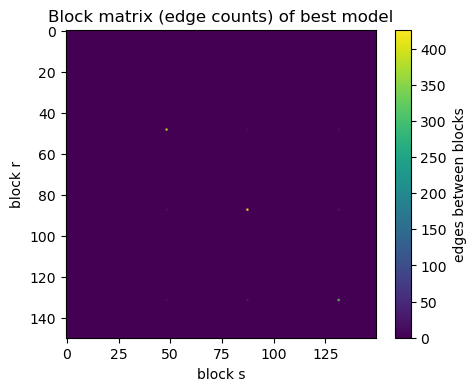

In [113]:
plt.figure(figsize=(5, 4),dpi=100)

plt.imshow(mat.todense(), aspect="auto")
plt.colorbar(label="edges between blocks")
plt.title("Block matrix (edge counts) of best model")
plt.xlabel("block s")
plt.ylabel("block r")

plt.show()

### 13.7 Nested SBMs: multi-scale community structure

For many real networks, a flat partition is not enough.

`graph-tool` can infer nested/hierarchical structure with:
```python
state = gt.minimize_nested_blockmodel_dl(g)
```

This returns a `NestedBlockState`.
You can:
- print a summary
- draw the hierarchy
- access block memberships at each level


In [114]:
# A slightly larger synthetic example with 6 groups (2 super-groups)
n = 300
B = 6
b_true = np.repeat(np.arange(B), n//B)

# Make two super-communities: {0,1,2} and {3,4,5}
p_in  = 0.10
p_mid = 0.03
p_out = 0.005

# Build the PER-PAIR probability matrix p_rs
p = np.full((B, B), p_out, dtype=float)
np.fill_diagonal(p, p_in)

In [115]:
# within each super-group, between different blocks use p_mid
for r in range(3):
    for s in range(3):
        if r != s:
            p[r, s] = p_mid
for r in range(3, 6):
    for s in range(3, 6):
        if r != s:
            p[r, s] = p_mid

In [116]:
# Convert per-pair probabilities p_rs -> graph-tool propensities lambda_rs
sizes = np.array([(b_true == r).sum() for r in range(B)], dtype=int)
lam = np.zeros((B, B), dtype=float)

for r in range(B):
    for s in range(B):
        if r == s:
            # undirected convention: generate_sbm expects lam_rr = 2 * E[m_rr]
            # E[m_rr] = p_rr * C(n_r, 2)
            lam[r, r] = p[r, r] * sizes[r] * (sizes[r] - 1)
        else:
            # E[m_rs] = p_rs * n_r * n_s
            lam[r, s] = p[r, s] * sizes[r] * sizes[s]

In [117]:
g = gt.generate_sbm(b_true, lam, directed=False)
g.vp["b_true"] = g.new_vp("int", vals=b_true)

print("Generated SBM: V =", g.num_vertices(), "E =", g.num_edges())

Generated SBM: V = 300 E = 1262


In [118]:
# Nested inference (degree correction often helps in real graphs)
nstate = gt.minimize_nested_blockmodel_dl(g, state_args=dict(deg_corr=True))

nstate.print_summary()
print("Total hierarchy description length:", round(nstate.entropy(), 2))

l: 0, N: 300, B: 2
l: 1, N: 2, B: 1
l: 2, N: 1, B: 1
Total hierarchy description length: 5615.65


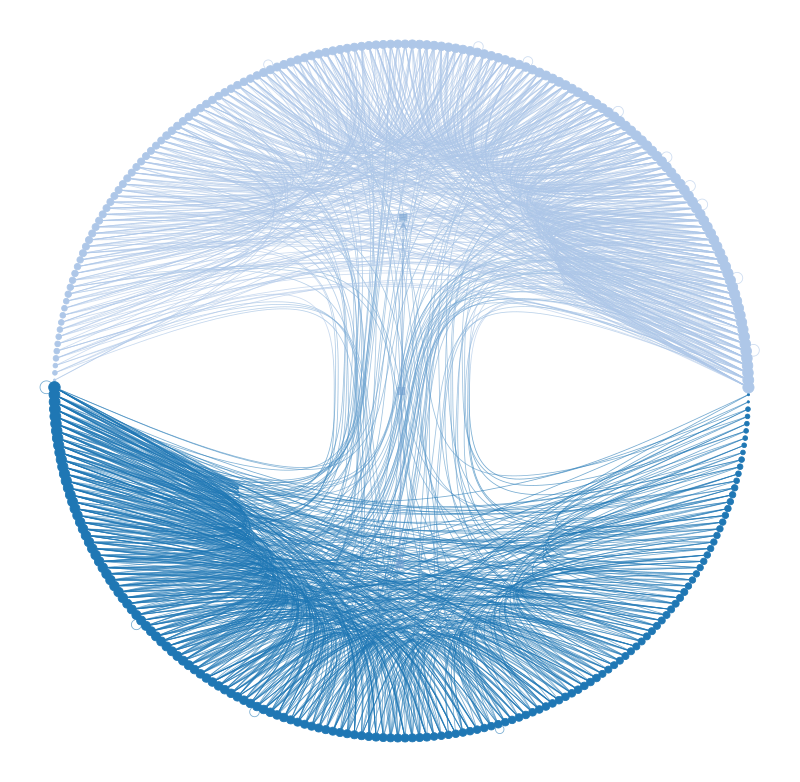

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x1de4ad410, at 0x1e6565350>,
 <GraphView object, directed, with 303 vertices and 302 edges, edges filtered by <EdgePropertyMap object with value type 'bool', for Graph 0x1de2cee90, at 0x1e6581b10>, vertices filtered by <VertexPropertyMap object with value type 'bool', for Graph 0x1de2cee90, at 0x1df73e050>, at 0x1de2cee90>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x1de2cee90, at 0x1de2f4bd0>)

In [119]:
# Draw hierarchy
nstate.draw(output_size=(400, 400))

In [120]:
# Get block memberships at each level
bs = nstate.get_bs()
print("Number of levels:", len(bs))
print("B at level 0:", len(np.unique(bs[0])))
print("B at top level:", len(np.unique(bs[-1])))

Number of levels: 10
B at level 0: 2
B at top level: 1


<!-- ### Checks for understanding (after §13)

1. What does `deg_corr=True` change in an SBM, and why does it matter for heavy-tailed degree distributions?
2. What is the difference between `minimize_blockmodel_dl(...)` and `minimize_nested_blockmodel_dl(...)` in terms of what the model is allowed to represent?
3. In `graph-tool`, why is the quantity $\Sigma$ (description length) a natural model selection score?
4. If the best-fitting model has $B=1$ block (no community structure), how should you interpret that result? -->


## 14. Uncertainty & MCMC: sampling partitions and getting marginals

A single inferred partition (an MDL optimum) can be misleading:

- many partitions may fit almost equally well
- block labels are arbitrary ("label switching")
- you often want *marginal* probabilities, not a single hard assignment

`graph-tool` gives you tools to:

1. **sample** partitions from the posterior (MCMC)
2. **summarize** the posterior:
   - vertex membership marginals ("soft" assignments)
   - consensus partitions ("hard" summaries)
   - uncertainty visualizations (pie charts, entropy, co-assignment matrices)

---

### 14.1 The posterior over partitions (conceptual)

Think of the SBM objective as a (negative log) posterior:

$$P(b \mid G) \propto \exp\bigl(-\Sigma(b)\bigr),$$

where $\Sigma(b)$ is the description length / entropy reported by `state.entropy()`.

---


### 14.2 MCMC and the Metropolis idea (high level)

MCMC constructs a Markov chain whose stationary distribution is the posterior.

A simplified Metropolis acceptance rule is:

$$\text{accept move } b\to b' \text{ with prob } 
\alpha = \min\left(1,\; \exp(-\beta[\Sigma(b')-\Sigma(b)])\right),$$

where:
- $\Delta\Sigma = \Sigma(b')-\Sigma(b)$ is the description-length change
- $\beta$ is an inverse temperature:
  - $\beta=1$: sample from the posterior
  - $\beta\to\infty$: greedy downhill search (optimization)

(Real implementations include proposal probabilities and extra move types, but this captures the core idea.)

---


### 14.3 Label switching (why "block 0" is not meaningful)

If you permute labels (rename blocks), the partition is the same grouping structure.
This means raw MCMC samples can "jump" in label space even when they haven't changed in meaning.

`PartitionModeState` solves this by aligning labels across samples so we can compute meaningful marginals.

---

### 14.4 Hands-on: posterior marginals as "pie charts" (Karate Club)

We will:

1. fit a degree-corrected SBM
2. run MCMC to sample partitions
3. compute vertex marginals
4. visualize uncertainty as pie charts

### 14.2.1 Why Metropolis works (the one equation: detailed balance)

We want our Markov chain to have stationary distribution:

$$
\pi(b) \propto \exp(-\beta\,\Sigma(b)).
$$

A common sufficient condition is **detailed balance**:

$$
\pi(b)\,q(b\to b')\,\alpha(b\to b')
=
\pi(b')\,q(b'\to b)\,\alpha(b'\to b),
$$

where:

- $q(b\to b')$ is the proposal probability
- $\alpha(b\to b')$ is the acceptance probability

If the proposal is symmetric ($q(b\to b')=q(b'\to b)$), detailed balance holds if we choose:

$$
\alpha(b\to b') = \min\left(1, \frac{\pi(b')}{\pi(b)}\right)
= \min\left(1, \exp\bigl(-\beta[\Sigma(b')-\Sigma(b)]\bigr)\right).
$$

That's the Metropolis rule.

---

### 14.2.2 Practical diagnostics: burn-in and autocorrelation

MCMC is powerful, but you should build two habits:

1) **Look at a trace plot** of $\Sigma$ (or some statistic).  
   - early iterations can reflect initialization ("burn-in")
   - later iterations should look like noisy fluctuations around a stable region

2) **Expect autocorrelation.**  
   Successive samples are not independent. If you record every iteration, you'll get many nearly-duplicate samples.

A simple diagnostic is the lag-$\ell$ autocorrelation:

$$
\rho(\ell) = \frac{\mathrm{Cov}(\Sigma_t,\Sigma_{t+\ell})}{\mathrm{Var}(\Sigma_t)}.
$$

When $\rho(\ell)$ decays slowly, you need either:
- more sweeps, or
- thinner samples (record every $k$ sweeps), or
- better proposals (graph-tool handles many of these details for you, but you still need to *think* statistically).


Initial entropy: 222.89 B = 1
Collected samples: 49
Entropy range: 222.89013084344725 to 258.1255776313164


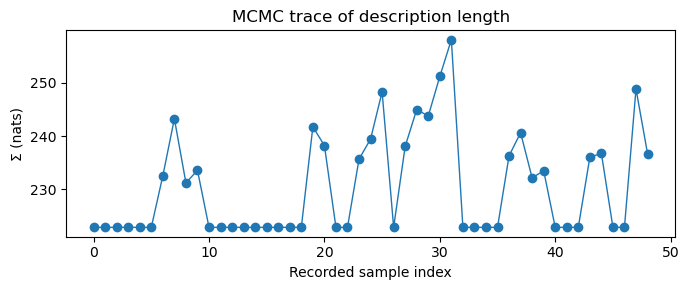

autocorr(lag= 1) ≈ 0.429
autocorr(lag= 2) ≈ 0.066
autocorr(lag= 5) ≈ 0.047
autocorr(lag=10) ≈ -0.054


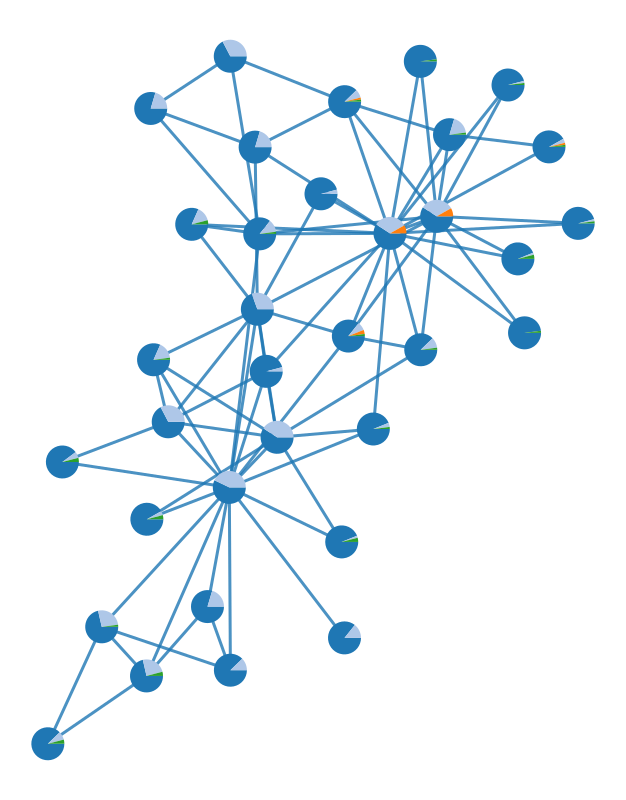

In [121]:
g = nx_to_gt(nx.karate_club_graph())

# Fit a degree-corrected SBM
state = gt.minimize_blockmodel_dl(g, state_args=dict(deg_corr=True))
print("Initial entropy:", round(state.entropy(), 2), "B =", state.get_nonempty_B())

# We'll record both partitions and description lengths along the chain
partitions = []
entropies = []

def record_state(s):
    partitions.append(s.get_blocks().a.copy())
    entropies.append(s.entropy())

# Equilibrate + collect
gt.mcmc_equilibrate(
    state,
    wait=20,               # stop when no new record DL found for this many sweeps (heuristic)
    force_niter=50,         # minimum sweeps before we consider stopping
    mcmc_args=dict(niter=5),# how many sweeps per callback
    callback=record_state,
    verbose=False
)

entropies = np.asarray(entropies)
print("Collected samples:", len(partitions))
print("Entropy range:", float(entropies.min()), "to", float(entropies.max()))

# Trace plot of Σ (description length)
plt.figure(figsize=(7, 3))
plt.plot(entropies, marker="o", linewidth=1)
plt.xlabel("Recorded sample index")
plt.ylabel("Σ (nats)")
plt.title("MCMC trace of description length")
plt.tight_layout()
plt.show()

# A tiny autocorrelation helper (for intuition, not for publication-grade ESS estimates)
def autocorr(x, lag):
    x = np.asarray(x)
    x0 = x[:-lag]
    x1 = x[lag:]
    return np.corrcoef(x0, x1)[0, 1]

for lag in [1, 2, 5, 10]:
    if len(entropies) > lag + 2:
        print(f"autocorr(lag={lag:>2}) ≈ {autocorr(entropies, lag):.3f}")

# Align labels + compute vertex marginals
pmode = gt.PartitionModeState(partitions, relabel=True, converge=True)
pv = pmode.get_marginal(g)  # VertexPropertyMap with vector<int> counts

# Draw: node pie charts show uncertainty (multi-membership probability mass)
pos = gt.sfdp_layout(g)
state.draw(
    pos=pos,
    vertex_shape="pie",
    vertex_pie_fractions=pv,
    vertex_size=15,
    output_size=(400, 400)
);


### 14.5 Quantifying uncertainty: consensus partition, entropy, and co-assignment

Visualizations are great, but you also want **numbers**.

Three common summaries:

1. **Consensus ("max marginal") partition**  
   Assign each node to its most probable block:

   $$\hat b_i = \arg\max_r \; P(b_i=r \mid G).$$

2. **Mean-field entropy of node marginals**  
   If $p_{ir} = P(b_i=r\mid G)$, then one natural uncertainty measure is:

   $$H_{\mathrm{MF}} = -\sum_i \sum_r p_{ir}\log p_{ir}.$$

   This is near 0 when assignments are nearly deterministic, and larger when nodes are ambiguous.

3. **Co-assignment matrix**  
   Define:

   $$C_{ij} = P(b_i=b_j\mid G).$$

   This is a very interpretable object: it tells you which pairs of nodes are "almost always" together vs "often split".

We'll compute all three below.

In [122]:
# --- MCMC sampling settings ---
burnin = 2000          # sweeps to forget initialization
thin = 20              # keep one sample every 'thin' sweeps
n_samples = 200        # number of saved samples

# --- Run burn-in ---
for _ in range(burnin):
    state.mcmc_sweep(beta=1.0)

# --- Collect samples of block assignments ---
samples = []
Bs = []

for t in range(n_samples):
    for _ in range(thin):
        state.mcmc_sweep(beta=1.0)

    b = state.get_blocks().a.copy()   # length N
    samples.append(b)
    Bs.append(len(np.unique(b)))

samples = np.asarray(samples)  # shape (n_samples, N)
Bs = np.asarray(Bs)

print("Sampled B (min/median/max):", Bs.min(), int(np.median(Bs)), Bs.max())
print("Fraction with B=1:", np.mean(Bs == 1))


# Sanity checks (helps if you run cells out of order)
N = samples.shape[1]
print("Sample matrix shape:", samples.shape, "| g.num_vertices() =", g.num_vertices())
assert N == g.num_vertices(), "Mismatch: samples were generated for a different graph than 'g'. Re-run the sampling cell."


Sampled B (min/median/max): 1 1 1
Fraction with B=1: 1.0
Sample matrix shape: (200, 34) | g.num_vertices() = 34


In [123]:
# Co-assignment (co-clustering) matrix from raw MCMC samples.
#
# Definition:
#   C[i,j] = fraction of posterior samples where i and j are assigned to the same block.
#
# This object is *label-invariant*: it does not care what the numeric block labels are,
# only whether two nodes match within each sample.

samples_arr = np.asarray(samples)
N = samples_arr.shape[1]

print("Using samples array with shape:", samples_arr.shape)
assert N == g.num_vertices(), "Mismatch: samples were generated for a different graph than 'g'. Re-run the sampling cell."

C = np.zeros((N, N), dtype=float)
for b in samples_arr:
    C += (b[:, None] == b[None, :]).astype(float)

C /= len(samples_arr)
print("Co-assignment matrix computed from", len(samples_arr), "samples.")

Using samples array with shape: (200, 34)
Co-assignment matrix computed from 200 samples.


Consensus B (nonempty): 1
Mean-field entropy of node marginals: 15.595 (nats)


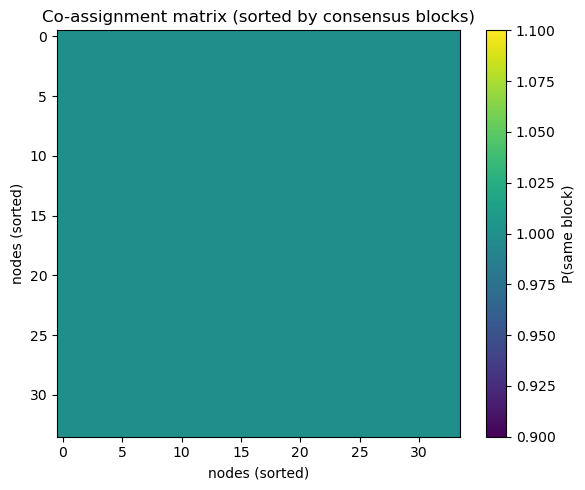

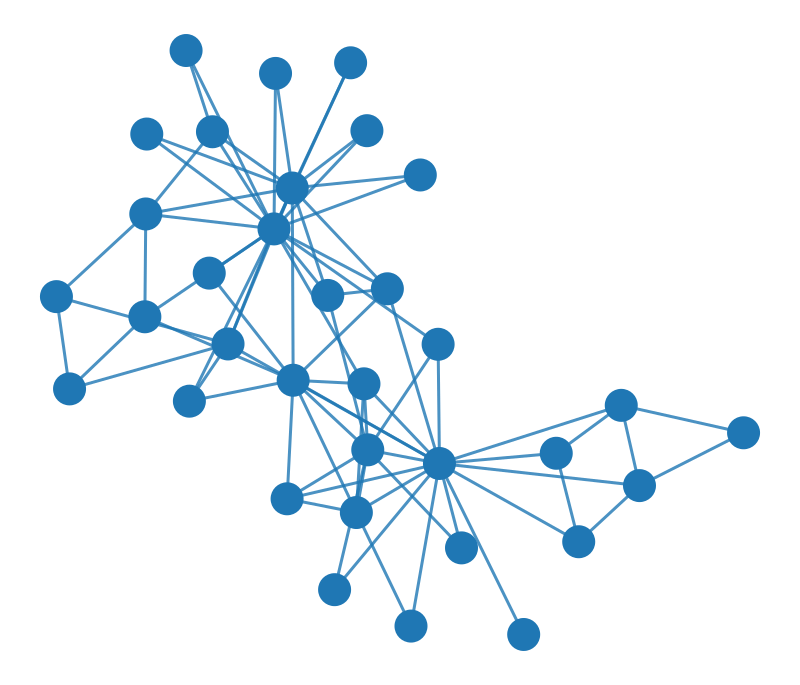

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x1dfc83510, at 0x1dfa03f50>

In [124]:
# 1) Consensus partition (max marginal) via PartitionModeState
#
# pmode is built from the earlier collection of partitions (from gt.mcmc_equilibrate).
# This gives a *label-aligned* view of the posterior and is convenient for marginals.

b_max = pmode.get_max(g)  # int-valued VertexPropertyMap
b_max_arr = np.asarray(b_max.a)
print("Consensus B (nonempty):", len(np.unique(b_max_arr)))

# 2) Mean-field entropy of node marginals (graph-tool convenience)
#
# Intuition:
# - If each node's marginal is concentrated on one block, entropy is low (confident assignments).
# - If many nodes have spread-out marginals, entropy is higher (uncertainty / boundary nodes).

H_mf = gt.mf_entropy(g, pv)
print("Mean-field entropy of node marginals:", round(H_mf, 3), "(nats)")

# 3) Visualize the co-assignment matrix (computed from raw samples)
#
# We sort nodes by the consensus labels so the block structure is easier to see.

# If C isn't in memory (e.g., you ran cells out of order), recompute it from `samples`.
try:
    C
except NameError:
    samples_arr = np.asarray(samples)
    N = samples_arr.shape[1]
    assert N == g.num_vertices(), "Mismatch: samples were generated for a different graph than 'g'. Re-run the sampling cell."
    C = np.zeros((N, N), dtype=float)
    for b in samples_arr:
        C += (b[:, None] == b[None, :]).astype(float)
    C /= len(samples_arr)

order = np.argsort(b_max_arr)

fig, ax = plt.subplots(1, 1, figsize=(6, 5), dpi=100)
im = ax.imshow(C[order][:, order], aspect="auto")
fig.colorbar(im, ax=ax, label="P(same block)")
ax.set_title("Co-assignment matrix (sorted by consensus blocks)")
ax.set_xlabel("nodes (sorted)")
ax.set_ylabel("nodes (sorted)")
plt.tight_layout()
plt.show()

# Draw consensus partition (hard colors, no pie charts)
pos = gt.sfdp_layout(g)
state.draw(pos=pos, vertex_fill_color=b_max, output_size=(400, 400), vertex_size=15)

### 14.6 Reading the pie charts

- A node with a **single dominant color** is confidently assigned to one block.
- A node with a **mixed pie** is uncertain (it plausibly belongs to multiple groups).
- Boundary / bridge nodes often show higher uncertainty.

> **Checkpoint:** Identify the "bridge" nodes in Karate Club and see if their pies look mixed.

---

### 14.7 Alternative: collecting marginals directly from `state`

`state.collect_vertex_marginals()` accumulates membership counts, but you must handle label switching carefully.

`PartitionModeState` is usually the easiest way for beginners.


## 15. Social science case study: PolBlogs polarization + posterior predictive checks

This is a classic dataset in computational social science:
- blogs as nodes
- hyperlinks as edges
- known political orientation (often: liberal vs conservative)
- strong polarization (assortative mixing by ideology)

We'll use it to practice:
1. cleaning and inspecting a real graph-tool dataset
2. choosing a model (degree-corrected vs not) using description length
3. interpreting blocks as social structure
4. checking whether the model captures key features (posterior predictive checks)

> If you cannot load `polblogs` (e.g., offline environment), skip to the "optional" synthetic examples below.

---

### 15.1 Load and prepare the data


In [125]:
# Try built-in collection first (often offline-friendly), then netzschleuder.
g0 = gt.collection.data["polblogs"]
source = "gt.collection.data['polblogs']"
# except Exception:
#     g0 = gt.collection.ns["polblogs"]
#     source = "gt.collection.ns['polblogs']"

# Work on a *copy* we can safely edit (remove edges, prune components, etc.)
g = gt.Graph(g0)
g.set_directed(False)

# Clean up multigraph artifacts (common when data are merged from multiple sources)
gt.remove_parallel_edges(g)
gt.remove_self_loops(g)

# Largest connected component (return a pruned Graph, not just a view)
g = gt.extract_largest_component(g, directed=False, prune=True)

print("Loaded:", source)
print("V =", g.num_vertices(), "E =", g.num_edges())
print("Vertex properties:", list(g.vp.keys()))
print("Edge properties:", list(g.ep.keys()))


Loaded: gt.collection.data['polblogs']
V = 1222 E = 16714
Vertex properties: ['label', 'value', 'pos', 'source']
Edge properties: []


### 15.2 Fit nested SBMs (degree-corrected vs not) and compare description lengths

We'll fit two models:
- **non-degree-corrected** nested SBM
- **degree-corrected** nested SBM

and choose the one with smaller description length.

> This is model selection: "which explanation compresses the network best?"


In [126]:
# Fit models (can take some time depending on machine)
state_ndc = gt.minimize_nested_blockmodel_dl(g, state_args=dict(deg_corr=False))
state_dc  = gt.minimize_nested_blockmodel_dl(g, state_args=dict(deg_corr=True))

dl_ndc = state_ndc.entropy()
dl_dc  = state_dc.entropy()

print("Nested SBM (non-degree-corrected) DL:", round(dl_ndc, 2))
print("Nested SBM (degree-corrected)     DL:", round(dl_dc,  2))

best = state_dc if dl_dc < dl_ndc else state_ndc
print("\nSelected model:", "degree-corrected" if best is state_dc else "non-degree-corrected")

Nested SBM (non-degree-corrected) DL: 51643.26
Nested SBM (degree-corrected)     DL: 51070.81

Selected model: degree-corrected


### 15.3 Visualize the inferred macro-structure

Nested SBMs contain multiple levels.  
For social science interpretation, it's often useful to look at a **coarse** level (few groups).

We'll:
1. inspect the number of groups at each level
2. select the *coarsest* level with, say, 2-10 groups
3. project that partition back onto the original graph
4. draw it


B by level (0 = finest): [21, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Chosen level: 1 with B = 5


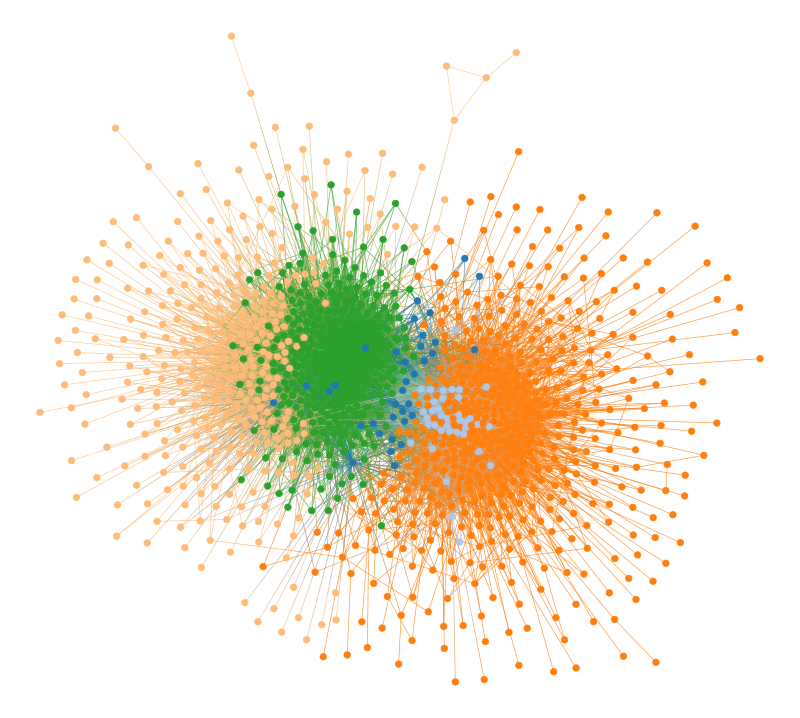

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x1def20dd0, at 0x1e65731d0>

In [127]:
# Choose the best model from previous cell
try:
    best
except NameError:
    best = gt.minimize_nested_blockmodel_dl(g, state_args=dict(deg_corr=True))

# Determine number of groups at each level
bs = best.get_bs()
Bs = [len(np.unique(b)) for b in bs]
print("B by level (0 = finest):", Bs)

# Pick a coarse level with 2..10 groups (fallback: level 0)
candidate_levels = [i for i, B in enumerate(Bs) if 2 <= B <= 10]
level = candidate_levels[-1] if candidate_levels else 0
print("Chosen level:", level, "with B =", Bs[level])

# Project that level to a flat BlockState on the original graph
state_coarse = best.project_level(level)

# Choose positions: dataset often provides g.vp['pos']
pos = g.vp["pos"] if "pos" in g.vp else gt.sfdp_layout(g)

state_coarse.draw(pos=pos, output_size=(400, 400))

### 15.4 Quantify polarization: assortativity by ideology and by inferred blocks

**Assortativity** is a normalized "like connects to like" score.

For a categorical label $x \in \{1,\dots,K\}$, define a mixing matrix:

- $e_{ij}$: fraction of edges from type $i$ to type $j$
- $a_i = \sum_j e_{ij}$, $b_j = \sum_i e_{ij}$

Then the assortativity coefficient (Newman) is:

$$r = \frac{\sum_i e_{ii} - \sum_i a_i b_i}{1-\sum_i a_i b_i}.$$

Interpretation:
- $r \approx 1$: almost all edges are within the same type (strong homophily / polarization)
- $r \approx 0$: connections are close to random mixing (given type frequencies)
- $r < 0$: disassortative mixing (edges tend to go across types)

In the PolBlogs dataset, we can compute assortativity for:
- **inferred blocks** (model-implied polarization / segmentation)
- **known ideology label** (if provided as a vertex property)

We'll use `gt.assortativity()`, which returns $r$ and an estimated variance (via jackknife).

In [128]:
# inferred block labels
b = state_coarse.get_blocks()

r_blocks, var_blocks = gt.assortativity(g, b)
print("Assortativity by inferred blocks:", round(r_blocks, 3), "+/-", round(np.sqrt(var_blocks), 3))

# Try to detect a known ideology property map automatically
label_candidates = ["value", "label", "party", "ideology", "pol", "color"]
known_key = next((k for k in label_candidates if k in g.vp), None)

if known_key is None:
    print("No obvious ideology label found in g.vp. (That's okay.)")
else:
    y = g.vp[known_key]
    r_y, var_y = gt.assortativity(g, y)
    print(f"Assortativity by known label '{known_key}':", round(r_y, 3), "+/-", round(np.sqrt(var_y), 3))

Assortativity by inferred blocks: 0.44 +/- 0.069
Assortativity by known label 'value': 0.811 +/- 0.067


### 15.5 Posterior predictive checks: does the fitted model reproduce key statistics?

A foundational Bayesian habit:

> Fit a generative model → **simulate replicated data** from the fitted model → compare to what you observed.

For a network model with latent structure $(b,\theta)$, the **posterior predictive** distribution is:

$$P(G_{\mathrm{rep}} \mid G)
= \int P(G_{\mathrm{rep}} \mid b,\theta)\;P(b,\theta \mid G)\, db\, d\theta.$$

In practice, we approximate this by:
1. fitting a state (which approximates the posterior)
2. sampling replicated graphs $G_{\mathrm{rep}}$ from the fitted state
3. computing statistics $T(G_{\mathrm{rep}})$ and comparing to $T(G)$

If the observed statistic is consistently extreme under the replicated distribution, the model is missing something.

Below we check several statistics:
- global clustering coefficient
- degree assortativity (by degree)
- approximate average shortest-path length (via sampled pairs)

You can add more: motif counts, rich-club coefficients, reciprocity (directed graphs), etc.

Observed stats:
  global clustering         : 0.226
  degree assortativity      : -0.2213
  avg shortest-path length  : 3.238

Posterior predictive p-values (one-sided: replicate >= observed):
  clustering p-value    : 0.0385
  assortativity p-value : 1.0
  path length p-value   : 1.0


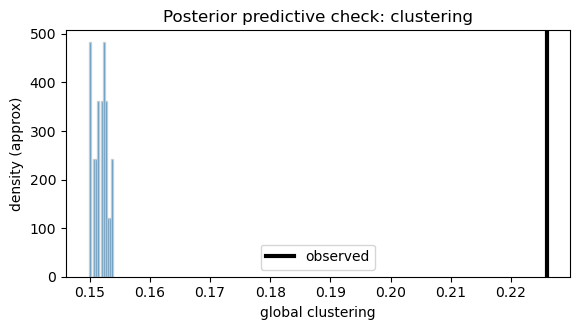

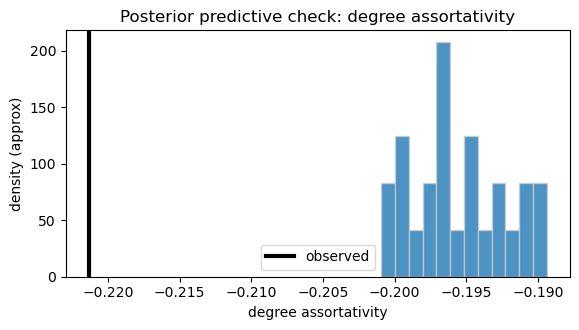

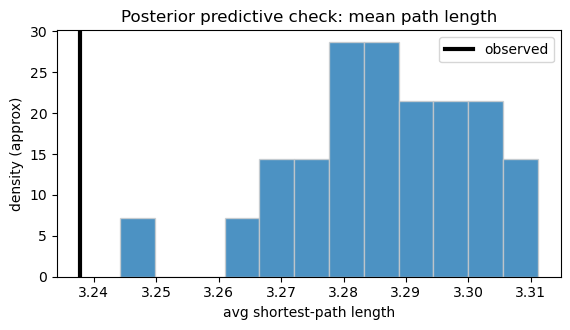

In [129]:
# We'll use the finest level (level 0) for sampling replicated graphs
base_state = best.get_levels()[0]  # BlockState on original graph

# For statistics, we'll treat the graph as undirected
g_obs = gt.GraphView(g, directed=False)

def compute_stats(g_in, dist_samples=500):
    # Return a small vector of network summary statistics.
    # (We keep this tiny, but you can extend it easily.)
    # 1) global clustering
    c = gt.global_clustering(g_in)[0]

    # 2) degree assortativity (scalar assortativity of total degree)
    r_deg = gt.scalar_assortativity(g_in, "total")[0]

    # 3) approximate average shortest-path length via distance histogram
    counts, bins = gt.distance_histogram(g_in, bins=[0, 1], samples=dist_samples)
    mids = (bins[:-1] + bins[1:]) / 2.0

    # drop distance ~ 0 bin (self-pairs)
    mask = mids > 0
    apl = float((mids[mask] * counts[mask]).sum() / counts[mask].sum())

    return c, r_deg, apl

# Observed statistics
c_obs, rdeg_obs, apl_obs = compute_stats(g_obs, dist_samples=1000)
print("Observed stats:")
print("  global clustering         :", round(c_obs, 4))
print("  degree assortativity      :", round(rdeg_obs, 4))
print("  avg shortest-path length  :", round(apl_obs, 3))

# Sample from the fitted model
rng = np.random.default_rng(1)
n_samp = 25
stats = []

for _ in range(n_samp):
    gs = base_state.sample_graph()  # replicate from fitted model
    gt.remove_parallel_edges(gs)
    gt.remove_self_loops(gs)

    gs = gt.GraphView(gs, directed=False)
    stats.append(compute_stats(gs, dist_samples=500))

stats = np.array(stats)
c_samp    = stats[:, 0]
rdeg_samp = stats[:, 1]
apl_samp  = stats[:, 2]

def mc_pvalue(null_samples, obs):
    return (1 + np.sum(null_samples >= obs)) / (len(null_samples) + 1)

print("\nPosterior predictive p-values (one-sided: replicate >= observed):")
print("  clustering p-value    :", round(mc_pvalue(c_samp, c_obs), 4))
print("  assortativity p-value :", round(mc_pvalue(rdeg_samp, rdeg_obs), 4))
print("  path length p-value   :", round(mc_pvalue(apl_samp, apl_obs), 4))

# Plot PPC distributions
def ppc_hist(samples, obs, title, xlabel):
    
    plt.figure(figsize=(6.5, 3.2))

    plt.hist(samples, bins=12, density=True, ec='.8', alpha=0.8)
    plt.axvline(obs, linewidth=3, label="observed", color='k')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("density (approx)")
    plt.legend()

    plt.show()

ppc_hist(c_samp,    c_obs,    "Posterior predictive check: clustering", "global clustering")
ppc_hist(rdeg_samp, rdeg_obs, "Posterior predictive check: degree assortativity", "degree assortativity")
ppc_hist(apl_samp,  apl_obs,  "Posterior predictive check: mean path length", "avg shortest-path length")

### 15.6 Interpretation prompts (for discussion)

1. Does the inferred *coarse* partition look like "two big camps"?
2. Are there smaller subcommunities within camps?
3. Which nodes appear as bridges between groups?
4. In the posterior predictive check:
   - Is the observed clustering typical under the model?
   - If not, what kinds of mechanisms might increase clustering beyond SBM?
     (e.g., triadic closure, geometric constraints, social circles)

---

### 15.7 Exercises + further resources

#### Exercises (suggested)
1. **NetworkX → graph-tool translation drill**  
   Take a NetworkX graph you built in a previous assignment and:
   - convert to graph-tool
   - compute betweenness and clustering in both libraries
   - verify results agree (approximately)

2. **Model comparison**  
   On PolBlogs (or another dataset):
   - compare `deg_corr=True` vs `deg_corr=False`
   - record description lengths and inferred B per level
   - write a short interpretation: *why do you think one wins?*

3. **Uncertainty**  
   For Karate Club:
   - compute marginals with MCMC
   - identify the most uncertain nodes
   - relate uncertainty to graph position (bridges, cut vertices, etc.)

4. **Posterior predictive checks**  
   Pick a statistic (e.g., average path length, assortativity by degree) and test whether the fitted SBM reproduces it.

#### Further reading / references
- graph-tool cookbook: **Inferring modular network structure** (official docs)
- Tiago Peixoto's papers on Bayesian/MDL SBM inference and nested SBMs
- A reminder: generative models are *useful stories*, not "truth machines"



### Checks for understanding (after §15)

1. In the PolBlogs example, what features of the graph are you implicitly asking the SBM to explain?
2. Posterior predictive checks ask: "If the model were true, would data like this be typical?"  
   What did you choose to check here, and what would be a good *additional* check for this dataset?
3. If you have node metadata (e.g., "liberal" / "conservative"), where should it enter the analysis: as **validation**, as **priors**, or as **covariates**? What are the risks of each?


## 16. Community detection gallery: fit SBMs on several networks and compare the pictures

PolBlogs is a great teaching dataset because it has a clear political interpretation.

But one danger in learning any method from a single dataset is that you start thinking the method *always* produces the same kind of output.

So here we do something simple:

- load a few networks with very different structures
- fit the same **degree-corrected nested SBM** workflow
- draw the resulting coarse partition

The goal is not to argue that SBMs are "right" for every dataset.  
The goal is to build **visual intuition** for what these partitions look like across domains.

> If a dataset fails to download on a given machine (network restrictions), skip it and run the ones that work.


In [130]:
from IPython.display import display

def load_dataset(name):
    """Try gt.collection.data first, then gt.collection.ns. Fallback to a few NetworkX built-ins."""
    # graph-tool collections (may download on first use)
    try:
        g0 = gt.collection.data[name]
        return g0, f"gt.collection.data['{name}']"
    except Exception:
        try:
            g0 = gt.collection.ns[name]
            return g0, f"gt.collection.ns['{name}']"
        except Exception:
            pass

    # A few offline fallbacks via NetworkX
    if name == "karate":
        return nx_to_gt(nx.karate_club_graph()), "NetworkX: karate_club_graph() (fallback)"
    if name == "karate_nx":
        return nx_to_gt(nx.karate_club_graph()), "NetworkX: karate_club_graph()"
    if name == "lesmis_nx":
        return nx_to_gt(nx.les_miserables_graph()), "NetworkX: les_miserables_graph()"
    if name == "florentine_nx":
        return nx_to_gt(nx.florentine_families_graph()), "NetworkX: florentine_families_graph()"

    raise KeyError(f"Could not load dataset '{name}'.")

def clean_undirected_simple(g_in):
    """Return a cleaned, simple, undirected graph.

    Steps:
    - copy the input graph (so edits are safe),
    - make it undirected,
    - remove parallel edges and self-loops,
    - keep only the largest connected component.

    This keeps the gallery focused on community structure instead of artifacts.
    """
    g = gt.Graph(g_in)
    g.set_directed(False)

    gt.remove_parallel_edges(g)
    gt.remove_self_loops(g)

    g = gt.extract_largest_component(g, directed=False, prune=True)
    return g

In [131]:
def draw_state(state, g, title, level=0):
    st = state.project_level(level)
    pos = g.vp["pos"] if "pos" in g.vp else gt.sfdp_layout(g)
    print(title)
    print("  vertices:", g.num_vertices(), "edges:", g.num_edges())
    print("  chosen level:", level)
    st.draw(pos=pos, output_size=(400,400))


def fit_nested_sbm_and_choose_level(g, B_min=2, B_max=10, deg_corr=True, mcmc_args={}):
    state = gt.minimize_nested_blockmodel_dl(g, state_args=dict(deg_corr=deg_corr),
                                             multilevel_mcmc_args=mcmc_args)

    # Determine B at each level
    bs = state.get_bs()
    Bs = [len(np.unique(np.asarray(b))) for b in bs]

    # Choose a "teaching level": coarse but not trivial
    candidate_levels = [i for i, B in enumerate(Bs) if B_min <= B <= B_max]
    level = candidate_levels[-1] if candidate_levels else 0

    
    return state, level, Bs

Karate Club (classic social network)  |  gt.collection.data['karate']  |  B by level = [1, 1, 1, 1, 1, 1, 1]
  vertices: 34 edges: 78
  chosen level: 0


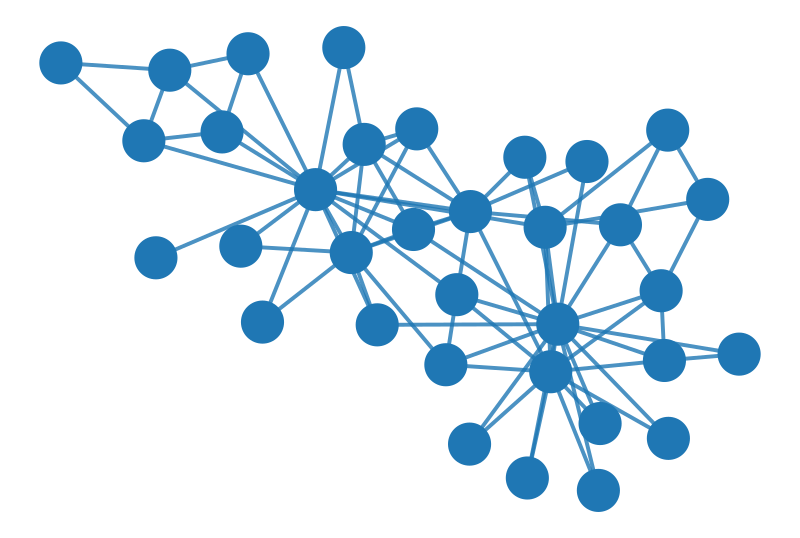

---
Dolphins (animal social network)  |  gt.collection.data['dolphins']  |  B by level = [2, 1, 1, 1, 1, 1, 1]
  vertices: 62 edges: 159
  chosen level: 0


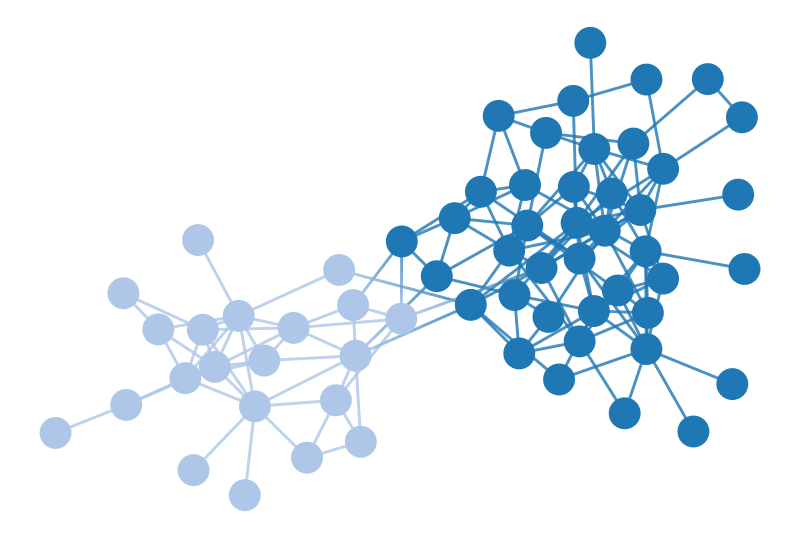

---
College football (games network)  |  gt.collection.data['football']  |  B by level = [10, 2, 1, 1, 1, 1, 1, 1]
  vertices: 115 edges: 613
  chosen level: 1


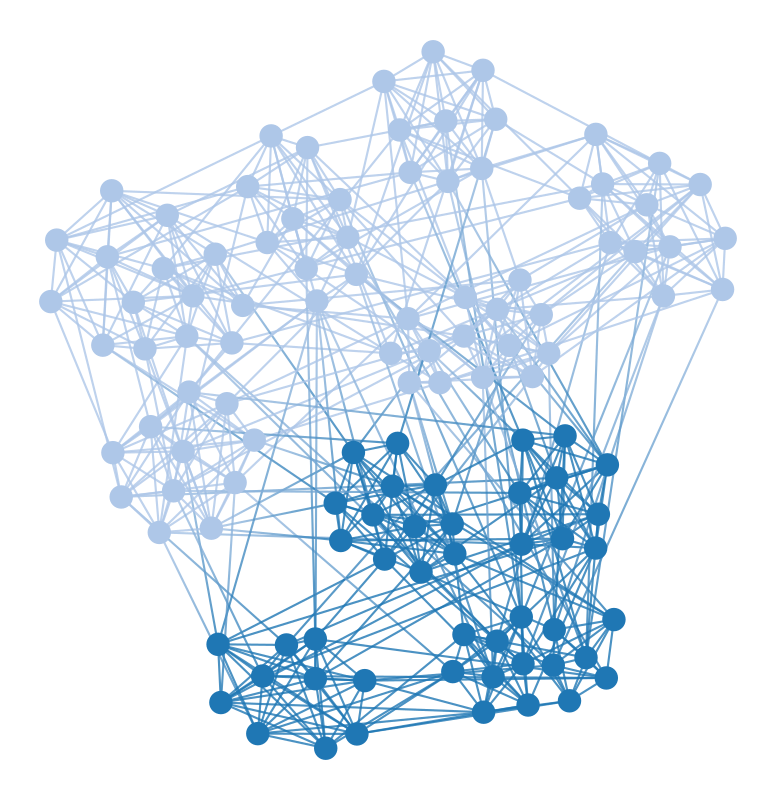

---
Political books (co-purchase network)  |  gt.collection.data['polbooks']  |  B by level = [3, 1, 1, 1, 1, 1, 1, 1]
  vertices: 105 edges: 441
  chosen level: 0


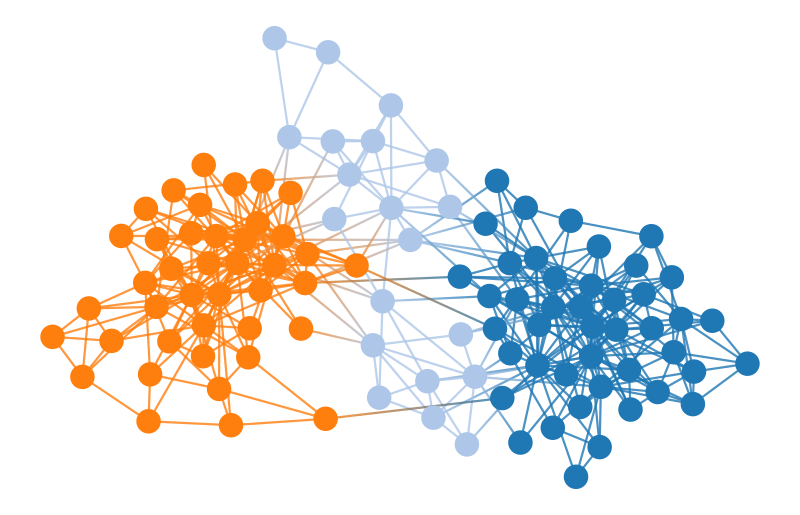

---
Worm brain  |  gt.collection.data['celegansneural']  |  B by level = [14, 3, 1, 1, 1, 1, 1, 1, 1, 1]
  vertices: 297 edges: 2148
  chosen level: 1


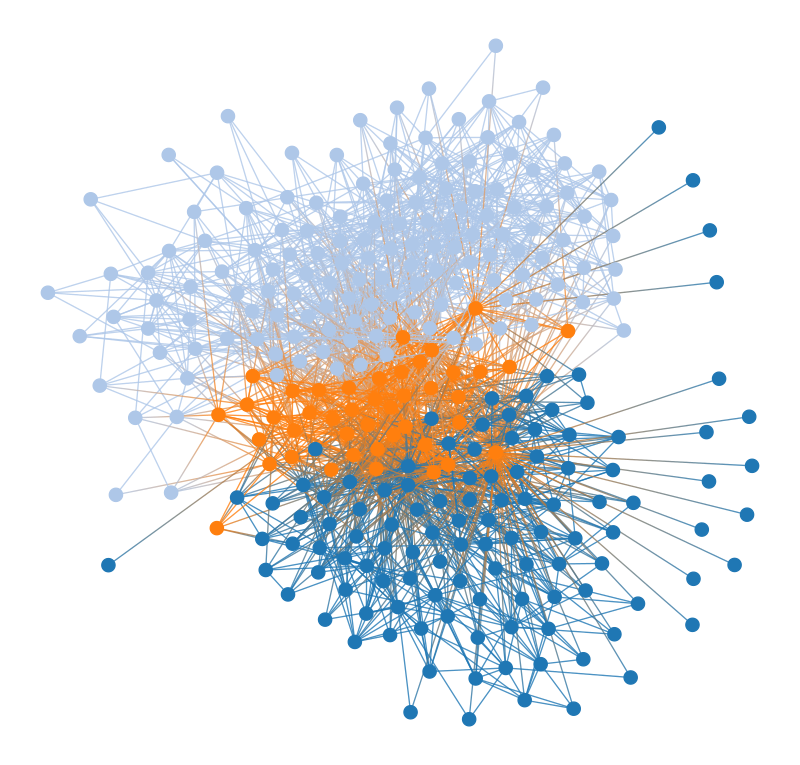

---
Power grid  |  gt.collection.data['power']  |  B by level = [11, 5, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
  vertices: 4941 edges: 6594
  chosen level: 2


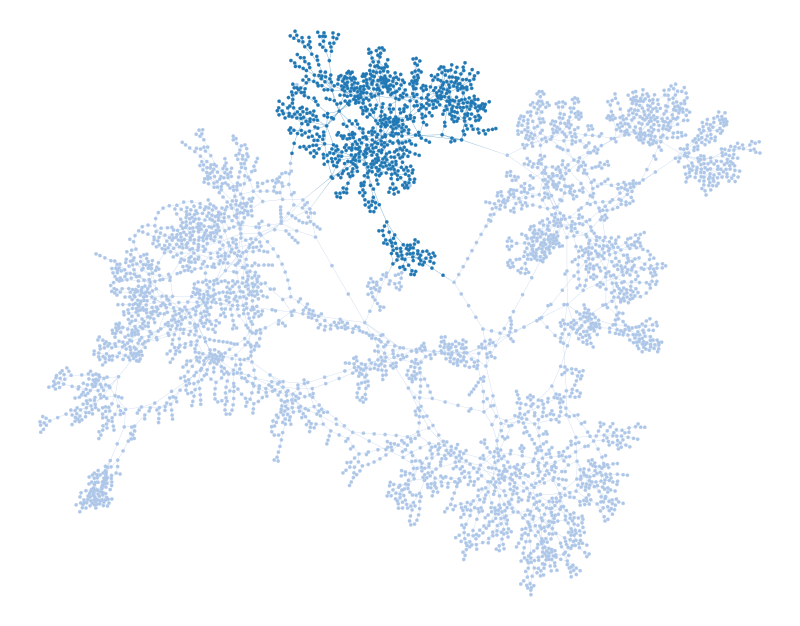

---
Food web  |  gt.collection.data['serengeti-foodweb']  |  B by level = [4, 2, 1, 1, 1, 1, 1, 1, 1]
  vertices: 161 edges: 591
  chosen level: 1


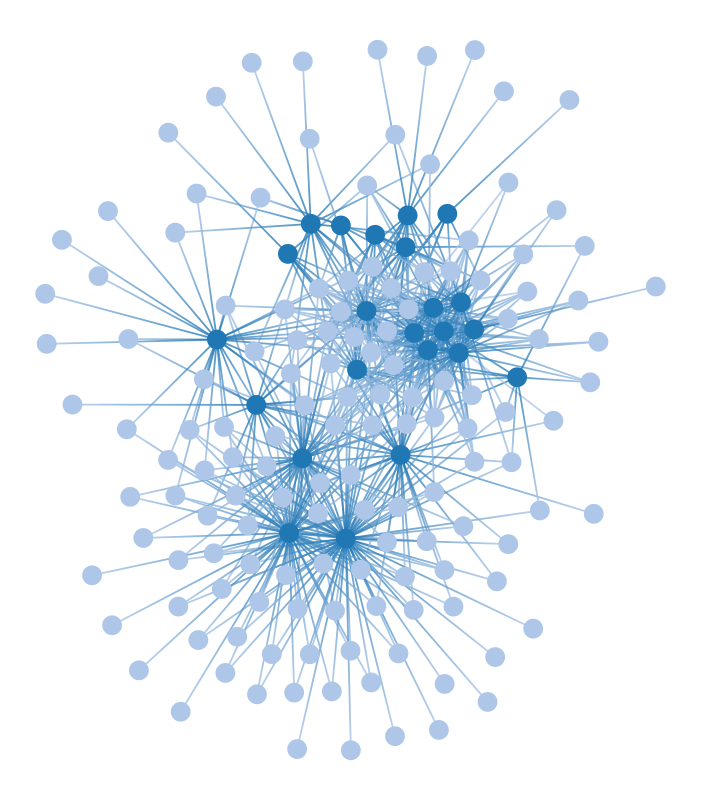

---
Autonomous systems  |  gt.collection.data['as-22july06']  |  B by level = [59, 22, 8, 3, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
  vertices: 22963 edges: 48436
  chosen level: 4


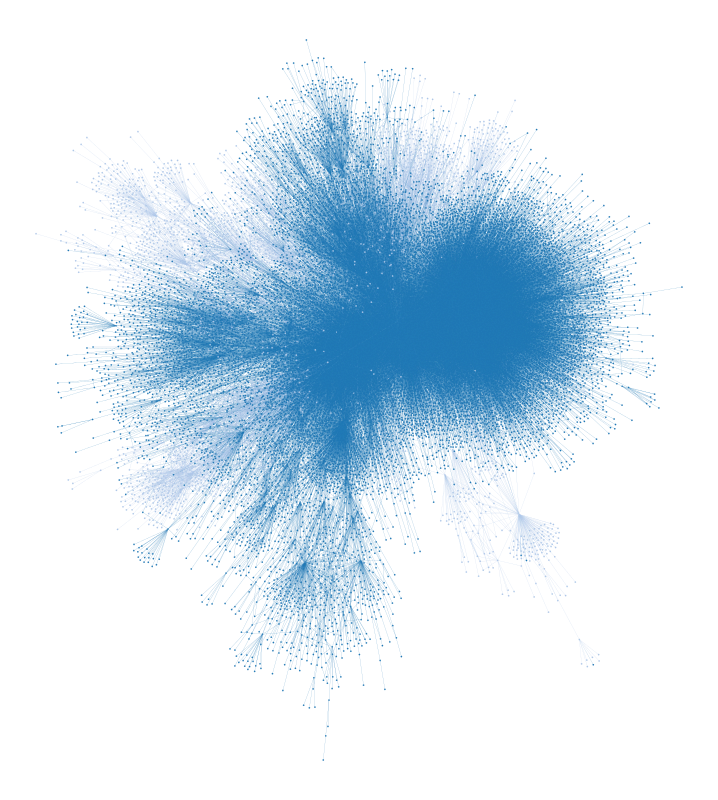

---
Les Misérables (character co-appearance)  |  NetworkX: les_miserables_graph()  |  B by level = [7, 1, 1, 1, 1, 1, 1, 1]
  vertices: 77 edges: 254
  chosen level: 0


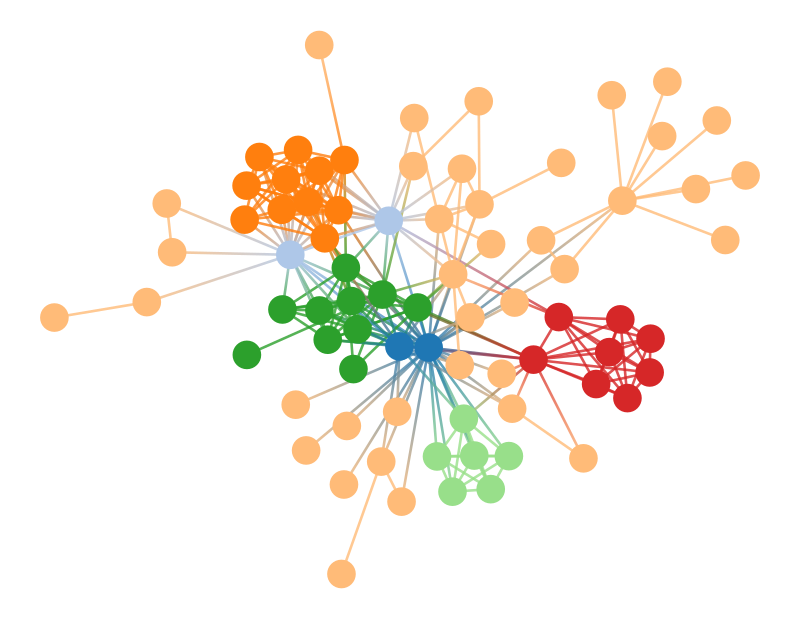

---
Florentine families (marriage/business ties)  |  NetworkX: florentine_families_graph()  |  B by level = [1, 1, 1, 1, 1]
  vertices: 15 edges: 20
  chosen level: 0


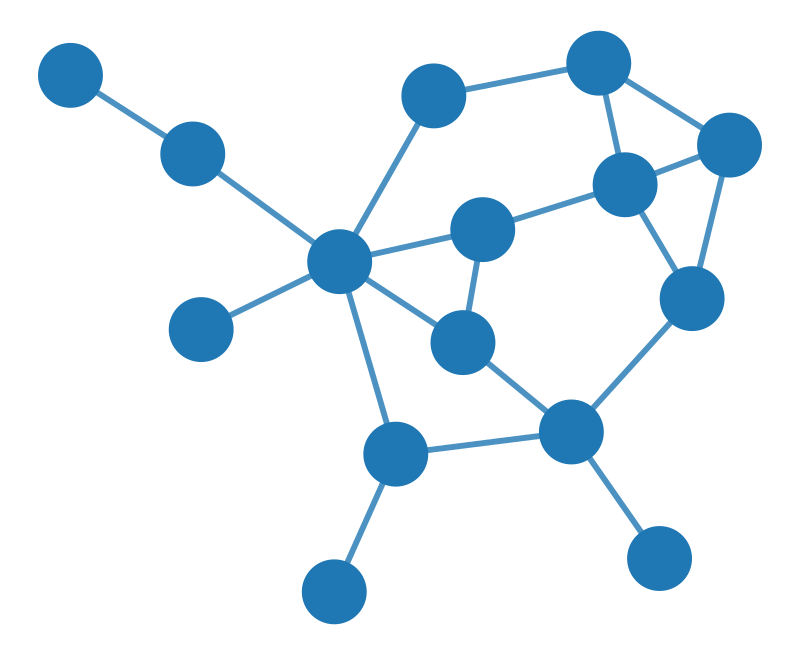

---


In [133]:
# Pick a small gallery. Add/remove items as you like.
gallery = [
    ("karate", "Karate Club (classic social network)"), 
    ("dolphins", "Dolphins (animal social network)"), 
    ("football", "College football (games network)"), 
    ("polbooks", "Political books (co-purchase network)"),
    ("celegansneural", "Worm brain"),
    ("power", "Power grid"),
    ("serengeti-foodweb",'Food web'),
    ('as-22july06', 'Autonomous systems'),
    
    # Offline fallbacks (no download required if NetworkX has them)
    ("lesmis_nx", "Les Misérables (character co-appearance)"), 
    ("florentine_nx", "Florentine families (marriage/business ties)"), 
]

mcmc_args = dict(niter=10,
                 beta=1.0,
                 verbose=False,
                )

for name, label in gallery:
    try:
        g0, src = load_dataset(name)
    except Exception as e:
        print(f"Skipping {name}: {e}")
        print("---")
        continue

    g = clean_undirected_simple(g0)

    state, level, Bs = fit_nested_sbm_and_choose_level(g, B_min=2, B_max=20,
                                                       deg_corr=True, mcmc_args=mcmc_args)

    title = f"{label}  |  {src}  |  B by level = {Bs}"
    draw_state(state, g, title=title, level=level)
    print("---")


### Wraping up

A good mental checklist when you run community detection:

1. **Start with a null model.** Ask what structure you would see "by chance," given what must be preserved (size, degrees, etc.).
2. **Be explicit about assumptions.** Modularity, Infomap, and SBMs answer different questions because they assume different generating stories.
3. **Model selection is part of the problem.** If you must choose the number of communities by hand, you are doing model selection "off to the side."
4. **Uncertainty matters.** A single partition is rarely the full story; look at marginals, stability, and posterior predictive behavior.

__________
## Next time...
Spatial Network Science - `class_06_spatial.ipynb`
_______

## References and further resources:

1. Class Webpages
    - Github: https://github.com/network-science-data-and-models/cnet5052_sp26
    - Syllabus and course details: https://brennanklein.com/cnet5052-spring26
2. The official `graph-tool` documentation. https://graph-tool.skewed.de/
3. Netzschleuder: the dataset repository used by `graph-tool` (via `gt.collection.ns[...]`). https://networks.skewed.de/
4. Girvan, M. & Newman, M. E. J. (2002). *Community structure in social and biological networks*. **PNAS**, 99(12), 7821-7826. DOI: 10.1073/pnas.122653799
5. Newman, M. E. J. & Girvan, M. (2004). *Finding and evaluating community structure in networks*. **Physical Review E**, 69, 026113. DOI: 10.1103/PhysRevE.69.026113
6. Newman, M. E. J. (2006). *Modularity and community structure in networks*. **PNAS**, 103(23), 8577-8582. DOI: 10.1073/pnas.0601602103
7. Blondel, V. D., Guillaume, J.-L., Lambiotte, R., & Lefebvre, E. (2008). *Fast unfolding of communities in large networks* (Louvain). **J. Stat. Mech.**, P10008. DOI: 10.1088/1742-5468/2008/10/P10008
8. Traag, V. A., Waltman, L., & van Eck, N. J. (2019). *From Louvain to Leiden: guaranteeing well-connected communities*. **Scientific Reports**, 9, 5233. DOI: 10.1038/s41598-019-41695-z
9. Rosvall, M. & Bergstrom, C. T. (2008). *Maps of random walks on complex networks reveal community structure* (Infomap / map equation). **PNAS**, 105(4), 1118-1123. DOI: 10.1073/pnas.0706851105
10. Fortunato, S. (2010). *Community detection in graphs*. **Physics Reports**, 486(3-5), 75-174. DOI: 10.1016/j.physrep.2009.11.002
11. Abbe, E. (2018). *Community Detection and Stochastic Block Models: Recent Developments*. **JMLR**, 18(177), 1-86. (Often circulated as a free PDF; search the title.)
12. Fortunato, S. & Barthélemy, M. (2007). *Resolution limit in community detection*. **PNAS**, 104(1), 36-41. DOI: 10.1073/pnas.0605965104
13. Good, B. H., de Montjoye, Y.-A., & Clauset, A. (2010). *The performance of modularity maximization in practical contexts*. **Physical Review E**, 81, 046106. DOI: 10.1103/PhysRevE.81.046106
14. Holland, P. W., Laskey, K. B., & Leinhardt, S. (1983). *Stochastic blockmodels: First steps*. **Social Networks**, 5(2), 109-137. DOI: 10.1016/0378-8733(83)90021-7
15. Karrer, B. & Newman, M. E. J. (2011). *Stochastic blockmodels and community structure in networks* (degree correction). **Physical Review E**, 83, 016107. DOI: 10.1103/PhysRevE.83.016107
16. Peixoto, T. P. (2014). *Hierarchical block structures and high-resolution model selection in large networks*. **Physical Review X**, 4, 011047. DOI: 10.1103/PhysRevX.4.011047
17. Peixoto, T. P. (2014). *Efficient Monte Carlo and greedy heuristic for the inference of stochastic block models*. **Physical Review E**, 89, 012804. DOI: 10.1103/PhysRevE.89.012804
18. Peixoto, T. P. (2017). *Nonparametric Bayesian inference of the microcanonical stochastic block model*. **Physical Review E**, 95, 012317. DOI: 10.1103/PhysRevE.95.012317
19. Funke, T. & Becker, T. (2019). *Stochastic block models: A comparison of variants and inference methods*. **PLOS ONE**, 14(4): e0215296. DOI: 10.1371/journal.pone.0215296
20. Kass, R. E. & Raftery, A. E. (1995). *Bayes factors*. **Journal of the American Statistical Association**, 90(430), 773-795. DOI: 10.1080/01621459.1995.10476572
21. Rissanen, J. (1978). *Modeling by shortest data description*. **Automatica**, 14(5), 465-471. DOI: 10.1016/0005-1098(78)90005-5
22. MacKay, D. J. C. (2003). *Information Theory, Inference, and Learning Algorithms*. Cambridge University Press. ISBN-13: 978-0521642989
23. Gelman, A., et al. (various editions). *Bayesian Data Analysis* (excellent for building intuition around posteriors)

## Appendix A: NetworkX ↔ `graph-tool` cheat sheet

This appendix is meant to be something you can **keep open while coding**.

> In `graph-tool`, the "secret" is: **structure in the Graph, data in property maps**.

---

### A.1 Create a graph

**NetworkX**
```python
G = nx.Graph()
G = nx.DiGraph()
```

**graph-tool**
```python
g = gt.Graph(directed=False)
g = gt.Graph(directed=True)
```

---


### A.2 Add edges

**NetworkX**
```python
G.add_edge("a", "b")
G.add_edges_from([("a","b"), ("b","c")])
```

**graph-tool**
```python
g.add_edge(g.vertex(0), g.vertex(1))
g.add_edge_list([(0,1), (1,2)])
```

If your node IDs are strings:
```python
v_id = g.add_edge_list(edge_list, hashed=True, hash_type="string")
g.vp["id"] = v_id
```

---


### A.3 Node/edge attributes

**NetworkX**
```python
G.nodes["a"]["age"] = 20
G.edges["a","b"]["w"] = 0.7
```

**graph-tool**
```python
age = g.new_vp("int")
w   = g.new_ep("double")

age[v] = 20
w[e]   = 0.7

g.vp["age"] = age
g.ep["w"]   = w
```

---


### A.4 Subgraphs

**NetworkX**
```python
H = G.subgraph(nodes_to_keep).copy()
```

**graph-tool**
```python
vfilt = g.new_vp("bool")
vfilt.a = ...  # boolean mask of length N
gv = gt.GraphView(g, vfilt=vfilt)
H = gt.Graph(gv, prune=True)  # optional: make a real copy
```

---


### A.5 Degrees

**NetworkX**
```python
deg = dict(G.degree())
```

**graph-tool**
```python
deg = g.degree_property_map("total").a  # numpy array
```

---


### A.6 Clustering

**NetworkX**
```python
nx.average_clustering(G)
```

**graph-tool**
```python
gt.global_clustering(g)  # returns (value, std)
```

---

### A.7 Shortest paths

**NetworkX**
```python
nx.shortest_path_length(G, source, target)
```

**graph-tool**
```python
gt.shortest_distance(g, source=v, target=u)
```

Weighted:
```python
gt.shortest_distance(g, source=v, weights=g.ep.weight)
```

---


### A.8 Community detection

- NetworkX comm detection often ends at: partition that maximizes modularity
- graph-tool comm detection often starts at: generative model → infer partition + uncertainty

**NetworkX (Louvain)**
```python
from networkx.algorithms.community import louvain_communities
parts = louvain_communities(G, seed=0)
```

**graph-tool (SBM inference)**
```python
state = gt.minimize_nested_blockmodel_dl(g, state_args=dict(deg_corr=True))
state.draw()
```

---

### A.9 Saving/loading

**NetworkX**
```python
nx.write_graphml(G, "g.graphml")
G = nx.read_graphml("g.graphml")
```

**graph-tool**
```python
g.save("g.gt")
g = gt.load_graph("g.gt")
```


## Appendix B: `graph-tool` datasets and Netzschleuder

`graph-tool` ships with a small built-in collection (`gt.collection.data`) and can also download many more graphs from **Netzschleuder** (`gt.collection.ns`). This is super convenient.

Why this matters for learning:
- You can grab real graphs in 1 line
- You can reproduce experiments easily

<p>
<img src="images/netzschleuder.png" width="850">
</p>

---

### B.1 Built-in datasets (`gt.collection.data`)

These typically work offline once installed.

Example:
```python
g = gt.collection.data["polbooks"]
```


### B.2 Netzschleuder datasets (`gt.collection.ns`)

Netzschleuder access requires internet the first time; graphs are cached locally afterward.

Example:
```python
g = gt.collection.ns["ego_social/facebook_combined"]  # example dataset
```


### B.3 Hands-on: list dataset keys and load an example


In [ ]:
print("Some built-in datasets:", list(gt.collection.data.keys())[:20])

# This prints a dictionary-like structure with available collections.
print("\nNetzschleuder example keys (may take a moment):")
print(list(gt.collection.ns.keys())[:10])

In [ ]:
# Example: Facebook combined ego network (requires internet for first download)
g_fb = gt.collection.ns["ego_social/facebook_combined"]
print("Loaded facebook_combined:", g_fb.num_vertices(), "V,", g_fb.num_edges(), "E")
print("Vertex properties:", list(g_fb.vp.keys())[:10])

# positions are sometimes stored as an internal property map
pos = g_fb.vp["_pos"] if "_pos" in g_fb.vp else gt.sfdp_layout(g_fb)
gt.graph_draw(g_fb, pos=pos, output_size=(400, 400))

In [ ]:
# quick SBM inference (warning: can be computationally heavy)
st = gt.minimize_blockmodel_dl(g_fb, state_args=dict(deg_corr=True))
st.draw(pos=pos, output_size=(400, 400))

## Appendix C: Weighted graphs in `graph-tool`

Edge "weights" can mean different things:
- **cost** or **distance** (shortest paths)
- **tie strength** (stronger relationship)
- **frequency** (number of interactions)
- **capacity** (flow)

In `graph-tool`, weights are usually stored in an **edge property map** (e.g., `double`).

---

### C.1 Weighted shortest paths

If you have `g.ep["weight"]`, you can do:

```python
dist = gt.shortest_distance(g, source=v, weights=g.ep.weight)
```

This treats weights as *edge lengths/costs*.  
If your weights are "strength", you might want to invert them (cost = 1/strength).

---

### C.2 Weighted SBMs (edge covariates)

SBM inference can incorporate weights as **edge covariates** using:
- `recs=[...]` (list of edge property maps)
- `rec_types=[...]` (list of distributional assumptions)

Common `rec_types` include:
- `"real-normal"` (continuous real weights)
- `"real-exponential"`
- `"discrete-poisson"` (counts)
- `"discrete-binomial"`, `"discrete-geometric"`

This is *not* the same as "weighted adjacency" — it models:
1) whether an edge exists
2) the weight of the edge, given it exists

---

### C.3 Hands-on: weighted distances and a weighted SBM on a tiny example

In [ ]:
# Reuse the earlier pandas edge list
df_edges

In [ ]:
# NetworkX: weighted shortest path
G_w = nx.from_pandas_edgelist(df_edges, "src", "dst", edge_attr="weight", create_using=nx.Graph)

print("NetworkX weighted distance alice→dana:",
      nx.shortest_path_length(G_w, "alice", "dana", weight="weight"))

In [ ]:
# Build the same weighted graph in graph-tool
edge_list = list(df_edges.itertuples(index=False, name=None))
g = gt.Graph(directed=False)
w = g.new_ep("double")
v_id = g.add_edge_list(edge_list, hashed=True, hash_type="string", eprops=[w])

g.vp["id"] = v_id
g.ep["weight"] = w

In [ ]:
# Find vertex handles by ID
v_by_id = {g.vp.id[v]: v for v in g.vertices()}

v_src = v_by_id["alice"]
v_dst = v_by_id["dana"]

dist = gt.shortest_distance(g, source=v_src, weights=g.ep.weight)
print("graph-tool weighted distance alice→dana:", dist[v_dst])

In [ ]:
# Weighted SBM inference (toy example)
state_w = gt.minimize_blockmodel_dl(
    g,
    state_args=dict(
        deg_corr=True,
        recs=[g.ep.weight],
        rec_types=["real-normal"]
    )
)
print("Weighted SBM DL:", round(state_w.entropy(), 2), "B =", state_w.get_nonempty_B())
state_w.draw(output_size=(200, 200))

## Appendix D: Practical tips, performance, and common gotchas

### D.1 OpenMP threads (parallel algorithms)

Many `graph-tool` algorithms use OpenMP parallelism.

You can inspect and set threads:

```python
import graph_tool.all as gt
import graph_tool

print(graph_tool.openmp_enabled())
print(graph_tool.openmp_get_num_threads())
graph_tool.openmp_set_num_threads(8)
```

You can also use a context manager:
```python
with graph_tool.openmp_context(nthreads=8):
    # run expensive algorithms here
    ...
```

---

### D.2 Multigraph by default

Parallel edges and self-loops are allowed unless you remove them:
```python
gt.remove_parallel_edges(g)
gt.remove_self_loops(g)
```

This matters for:
- clustering coefficient
- simple-graph assumptions
- some visualizations

---

### D.3 Property map types

If you create a property map with the wrong type, you'll get confusing errors.

Example:
```python
p = g.new_vp("int")
p[v] = "alice"   # error / nonsense
```

When in doubt:
- store labels as `"string"`
- store numeric quantities as `"double"`
- store masks as `"bool"`

---


### D.4 Label switching in MCMC

Block labels are arbitrary. Partition A and partition B might be the *same* partition up to relabeling.

This is why we used:
- `PartitionModeState` for marginals

---



### D.5 If you get stuck

1. Print what you have:
```python
print(g)
print(list(g.vp.keys()))
print(list(g.ep.keys()))
```

2. Start with smaller graphs (Karate, PolBooks), then scale up.

3. Use the cookbook demos in the official docs!!!

In [ ]:
import graph_tool
print("OpenMP enabled:", graph_tool.openmp_enabled())
print("Current threads:", graph_tool.openmp_get_num_threads())
# Example: set threads (adjust to your machine)
graph_tool.openmp_set_num_threads(4)
print("Threads after set:", graph_tool.openmp_get_num_threads())

_________
## Appendix E: Modularity, `ModularityState`

In Class 04, we saw modularity and its limitations.  
Here we show how to compute modularity in `graph-tool`, and connect it to statistical inference.

---


### E.1 Generalized modularity (equation)

Given a partition $b$, generalized modularity is:

$$Q = \frac{1}{2m}\sum_{ij}\left(A_{ij} - \gamma\frac{k_i k_j}{2m}\right)\delta(b_i,b_j),$$

where:
- $m$ is the number of edges
- $k_i$ is the degree of node $i$
- $\gamma$ is a **resolution parameter**
- $\delta(b_i,b_j)=1$ if $i$ and $j$ are in the same community

Interpretation:
- compares within-community edge density to a configuration-model null baseline
- $\gamma$ tunes the "preferred" community size (resolution limit issues are real)

---


### E.2 `graph-tool` has modularity maximization — but it's explicitly labeled dangerous

`graph-tool` can do modularity optimization via `ModularityState`.

But its own documentation warns that modularity lacks statistical regularization and tends to overfit.  We include it here so you can compare it to SBM inference and understand the difference.

---

### E.3 Hands-on: maximize modularity on an ER graph (overfitting demo)

We generate an Erdős-Rényi graph and maximize modularity.
Even though the graph has no planted communities, modularity typically finds a partition with non-trivial $Q$.


In [ ]:
# Generate an Erdos-Renyi graph in NetworkX for convenience, then convert.
N = 250
p = 0.03
G_er = nx.erdos_renyi_graph(N, p, seed=1)
g_er = nx_to_gt(G_er)

# Modularity maximization via ModularityState
mod_state = gt.minimize_blockmodel_dl(g_er, state=gt.ModularityState)

# Partition labels live here
b_mod = mod_state.b

# Number of inferred communities (nonempty)
B_mod = len(np.unique(b_mod.a))

Q = gt.modularity(g_er, b_mod, gamma=1.0)

print("ER graph (N={}, p={}):".format(N, p))
print("  inferred B (modularity) :", B_mod)
print("  modularity Q            :", round(float(Q), 4))

# Compare to SBM inference (degree-corrected)
sbm_state = gt.minimize_blockmodel_dl(g_er, state_args=dict(deg_corr=True))
print("\nSBM inference on the same ER graph:")
print("  inferred B (SBM)        :", sbm_state.get_nonempty_B())
print("  description length Σ    :", round(float(sbm_state.entropy()), 3), "(nats)")

## Appendix F: Overlapping communities with `OverlapBlockState`

Many real networks have **overlapping** community structure:

- people belong to multiple social circles
- papers span multiple topics
- genes participate in multiple pathways

A standard SBM assumes a *single* block label per node.   `graph-tool` supports overlapping SBMs via `OverlapBlockState`.

The main idea is that instead of a single block label $b_i$, a node can have multiple memberships. This is quite intuitive! One way to think about this is: each "half-edge" of a node may belong to a different block, so a node can connect to multiple groups in different interaction contexts.

---
1. Fit a standard (non-overlapping) SBM
2. Fit an overlapping SBM
3. Compare description lengths
4. If the overlap model is favored, interpret carefully (uncertainty is even more important)

Below we show the minimal code on Karate Club.

In [ ]:
g = nx_to_gt(nx.karate_club_graph())

base = gt.minimize_blockmodel_dl(g, state_args=dict(deg_corr=True))
ov   = gt.minimize_blockmodel_dl(g, state=gt.OverlapBlockState,
                                 state_args=dict(deg_corr=True))

print("Non-overlap Σ:", round(base.entropy(), 3), "nats | B:", base.get_nonempty_B())
print("Overlap    Σ:", round(ov.entropy(),   3), "nats | B:", ov.get_nonempty_B())
print("ΔΣ (overlap - base):", round(ov.entropy() - base.entropy(), 3))

pos = gt.sfdp_layout(g)
base.draw(pos=pos, output_size=(400,400))
ov.draw(pos=pos, output_size=(400,400))

## Appendix G: Multilayer (multiplex) networks with `LayeredBlockState`

Many real-world network science problems involve multiple edge types. For example...
- friendship vs advice ties
- retweets vs replies
- co-authorship vs citation
- positive vs negative interactions

A naive approach aggregates everything into one graph, which can erase structure. `graph-tool` supports **layered SBMs** where each edge belongs to a *layer*.

### G.1 Representing layers

We store a layer label on each edge:

- `ec[e] = 0` for layer 0
- `ec[e] = 1` for layer 1
- ...

The graph can be a multigraph so the same node pair can have multiple edges across layers.

### G.2 Synthetic example: two layers, same nodes, different mixing

We build a toy multiplex graph with two layers and then fit a layered SBM:

```python
state = gt.minimize_blockmodel_dl(g,
                                 state=gt.LayeredBlockState,
                                 state_args=dict(ec=ec, layers=True, deg_corr=True))
```

We compare it to fitting a single SBM on the aggregated graph.

In [ ]:
rng = np.random.default_rng(5)
gt.seed_rng(5)

# Make a planted partition graph
N = 200
B = 4
sizes = [50, 50, 50, 50]
b_true = np.concatenate([np.full(s, r, dtype=int) for r, s in enumerate(sizes)])


# Two layers that share the same underlying blocks, but with meaningfully different block matrices.
# Layer 0: standard assortative structure (communities)
p0_in, p0_out = 0.18, 0.006

p1_in = 0.06
p1_out_low = 0.004
p1_out_high = 0.05  # higher probability for (0,1) and (2,3)


p0 = p0_in * np.eye(B) + p0_out * (np.ones((B, B)) - np.eye(B))

p1 = p1_out_low * np.ones((B, B))
np.fill_diagonal(p1, p1_in)
p1[0, 1] = p1[1, 0] = p1_out_high
p1[2, 3] = p1[3, 2] = p1_out_high

In [ ]:
# Build a multigraph where parallel edges represent different layers.
g = gt.Graph(directed=False)
g.add_vertex(N)

ec = g.new_ep("int")      # layer label per edge
g.ep["layer"] = ec

for i in range(N):
    for j in range(i + 1, N):
        bi, bj = int(b_true[i]), int(b_true[j])

        if rng.random() < p0[bi, bj]:
            e = g.add_edge(i, j)
            ec[e] = 0

        if rng.random() < p1[bi, bj]:
            e = g.add_edge(i, j)
            ec[e] = 1

m0 = sum(1 for e in g.edges() if ec[e] == 0)
m1 = sum(1 for e in g.edges() if ec[e] == 1)
print("Total edges:", g.num_edges(), "| layer0:", m0, "| layer1:", m1)

In [ ]:
# Baseline "ignore layers": convert to a SIMPLE graph by collapsing parallel edges
# (i.e., treat "edge exists in any layer" as a single untyped edge).
g_agg = gt.Graph(g)
gt.remove_parallel_edges(g_agg)
gt.remove_self_loops(g_agg)

In [ ]:
# Fit layered SBM.... layers=True uses the “independent layers” model.
layered = gt.minimize_blockmodel_dl(
    g,
    state=gt.LayeredBlockState,
    state_args=dict(ec=ec, layers=True, deg_corr=True),
    multilevel_mcmc_args=dict(
        niter=20,      # try 5 (fast), 20 (strong), 50 (very strong)
        B_min=2,
        B_max=12
    )
)

In [ ]:
# Same multigraph as layered, but ignore layer labels
ignore_layers = gt.minimize_blockmodel_dl(
    g,
    state_args=dict(deg_corr=True),
    multilevel_mcmc_args=dict(niter=20, B_min=2, B_max=12)
)

In [ ]:
print("Layered Σ        :", round(float(layered.entropy()), 3), "nats | B:", layered.get_nonempty_B())
print("Ignore-layers Σ  :", round(float(ignore_layers.entropy()), 3), "nats | B:", ignore_layers.get_nonempty_B())
print("Per-edge Σ (layered)      :", round(float(layered.entropy())/g.num_edges(), 4))
print("Per-edge Σ (ignore-layers):", round(float(ignore_layers.entropy())/g.num_edges(), 4))

In [ ]:
# Visualize each layer with nodes colored by the *layered* inferred blocks
b_layered = layered.get_blocks()
pos = gt.sfdp_layout(gt.GraphView(g, directed=False))

ef0 = g.new_ep("bool")
ef1 = g.new_ep("bool")
for e in g.edges():
    ef0[e] = (ec[e] == 0)
    ef1[e] = (ec[e] == 1)

In [ ]:
g0 = gt.GraphView(g, efilt=ef0)
g1 = gt.GraphView(g, efilt=ef1)

gt.graph_draw(g0, pos=pos, vertex_fill_color=b_layered,
              vertex_size=10, output_size=(450, 450))
gt.graph_draw(g1, pos=pos, vertex_fill_color=b_layered,
              vertex_size=10, output_size=(450, 450))

The multilayer example above is mainly about modeling choices and how to interpret them. We created a network with a fixed set of vertices and two edge layers, encoded as a multigraph with an edge property `ec` that labels the layer of each edge. We then compared two inference choices:

1. A layered SBM (`LayeredBlockState`), which allows the *layer label* to matter in the generative story, and
2. A baseline SBM that ignores layers, which treats the same multigraph as “just more edges,” without distinguishing why each edge exists.

It is completely normal for both models to infer the same number of blocks $B$ and to produce visually similar partitions. The question is not "do I get communities??" but rather "does explicitly modeling layers buy me anything above and beyond a simple SBM?" The escription length $\Sigma$ answers that question: it rewards better fit to the observed edges, but it also penalizes model complexity. A layered model has more flexibility (it can effectively use different block–block connectivity patterns per layer), so it will only win when the data actually require that extra flexibility. If the layers are redundant or largely consistent with a single shared mixing pattern, MDL often prefers the simpler `ignore_layers` baseline, even though the layered model is more expressive.

In practice, the decision rule is simple: treat layers as part of the model only when they change the story in a way that improves out-of-sample reasoning or materially reduces MDL relative to the appropriate baseline. If layered and non-layered models yield similar partitions and MDL prefers the simpler model, that is a useful conclusion rather than a failure: the data are telling you that layer distinctions are not carrying enough additional structure to justify extra parameters.

## Appendix H: Link prediction with SBMs (and a path to uncertain networks)

A very common network science task (we saw this in Class 02!):

> Given a partially observed network, can we predict missing links?

SBMs are generative models, so they naturally support link prediction.

### H.1 Scoring edges

Let $G$ be your observed graph, and consider adding a candidate edge $(u,v)$. A simple score is a log posterior predictive ratio:

$$\mathrm{score}(u,v) \propto \log\frac{P(G + (u,v)\mid \text{model})}{P(G\mid \text{model})}.$$

In `graph-tool`, `BlockState.get_edges_prob(missing=[(u,v)])` provides a log-probability quantity you can use as a ranking score, in a way.

1. Remove a set of true edges (holdout set)
2. Fit the SBM on the remaining edges
3. Score:
   - held-out true edges ("positives")
   - randomly chosen non-edges ("negatives")
4. Compute an AUC-like statistic:
   - probability a random positive gets a higher score than a random negative

This is not the only evaluation method, but it's a good start.

In [ ]:
rng = np.random.default_rng(2)
gt.seed_rng(2)

# --- Data: Karate Club ---
g_full = nx_to_gt(nx.karate_club_graph())
g_full = gt.Graph(g_full)
g_full.set_directed(False)

In [ ]:
# --- Hold out a subset of true edges ---
edges = [(int(e.source()), int(e.target())) for e in g_full.edges()]
rng.shuffle(edges)
n_test = 15
test_edges = edges[:n_test]

In [ ]:
# --- Training graph = full graph minus test edges ---
g_train = gt.Graph(g_full)
for (u, v) in test_edges:
    e = g_train.edge(u, v)
    if e is not None:
        g_train.remove_edge(e)

print("Train edges:", g_train.num_edges(), "| Test edges:", len(test_edges))

In [ ]:
# --- Fit an SBM on the training graph ---
state = gt.minimize_blockmodel_dl(g_train, state_args=dict(deg_corr=True))
print("Inferred B (MAP state):", state.get_nonempty_B())

In [ ]:
# --- Sample random non-edges (negatives) ---
neg_edges = []
N = g_train.num_vertices()
while len(neg_edges) < len(test_edges):
    u = int(rng.integers(0, N))
    v = int(rng.integers(0, N))
    if u == v:
        continue
    if g_train.edge(u, v) is None:
        neg_edges.append((u, v))

In [ ]:
# --- Helper: numerically stable log-mean-exp ---
def logmeanexp(a):
    a = np.asarray(a, dtype=float)
    m = np.max(a)
    return m + np.log(np.mean(np.exp(a - m)))

In [ ]:
# --- MCMC model averaging of per-edge scores ---
# get_edges_prob() returns a log-likelihood ratio for adding a missing edge.
# We average this score over posterior samples of b via MCMC.
burnin = 2000
thin = 10
n_samples = 500
beta = 1.0

for _ in range(burnin):
    state.mcmc_sweep(beta=beta)

In [ ]:
pos_hist = [[] for _ in test_edges]
neg_hist = [[] for _ in neg_edges]

for _ in range(n_samples):
    for _ in range(thin):
        state.mcmc_sweep(beta=beta)

    # IMPORTANT: pass integer pairs (u,v)
    for i, (u, v) in enumerate(test_edges):
        pos_hist[i].append(state.get_edges_prob([(u, v)], entropy_args=dict(partition_dl=False)))
    for i, (u, v) in enumerate(neg_edges):
        neg_hist[i].append(state.get_edges_prob([(u, v)], entropy_args=dict(partition_dl=False)))

pos_scores = np.array([logmeanexp(h) for h in pos_hist])
neg_scores = np.array([logmeanexp(h) for h in neg_hist])

In [ ]:
# AUC-like statistic: P(score(pos) > score(neg)) with ties = 0.5
wins = 0.0
for s in pos_scores:
    wins += np.sum(s > neg_scores) + 0.5 * np.sum(s == neg_scores)
auc = wins / (len(pos_scores) * len(neg_scores))

print("Mean positive score:", round(float(pos_scores.mean()), 3))
print("Mean negative score:", round(float(neg_scores.mean()), 3))
print("AUC (higher is better):", round(float(auc), 3))

In [ ]:
# Visualize score distributions
plt.figure(figsize=(6.5, 3.0), dpi=100)

plt.hist(pos_scores, bins=10, alpha=0.7, label="held-out true edges", ec='.2')
plt.hist(neg_scores, bins=10, alpha=0.7, label="random non-edges", ec='.2')
plt.xlabel("SBM link-prediction score (avg log-likelihood ratio)")
plt.ylabel("count")
plt.title("SBM-based link prediction with posterior averaging (Karate)")
plt.legend(fontsize='small')

plt.show()

## Appendix I: Network dynamics in `graph-tool` — SIS epidemics + spectral thresholds

`graph-tool` includes a `dynamics` module for simulating standard processes on networks. This is extremely useful in applied network science!

We'll focus on the SIS (susceptible-infectious-susceptible) model.

### I.1 SIS model (equations)

Each node is either:
- susceptible: $s_i(t)=0$
- infectious: $s_i(t)=1$

A node $i$ becomes infected based on its infectious neighbors. In `graph-tool`'s SIS model, when node $i$ is updated at time $t$:

- If $s_i(t)=0$, it becomes infected with probability

$$(1-r_i)\left[1-\prod_j(1-\beta_{ij})^{A_{ij}\delta_{s_j(t),1}}\right] + r_i$$

- If $s_i(t)=1$, it recovers with probability $\gamma_i$.

Here:
- $\beta_{ij}$ is the transmission probability along edge $i\leftarrow j$
- $\gamma_i$ is the recovery probability
- $r_i$ is spontaneous infection probability (we'll set $r=0$)

### I.2 Epidemic threshold

A common approximation (quenched mean-field) says an epidemic can persist if:

$$\frac{\beta}{\gamma} \gtrsim \frac{1}{\lambda_{\max}},$$

where $\lambda_{\max}$ is the largest eigenvalue of the adjacency matrix.

We'll compute $\lambda_{\max}$ and simulate SIS above and below this threshold.

In [ ]:
from graph_tool.dynamics import SISState

g = nx_to_gt(nx.karate_club_graph())
g = gt.GraphView(g, directed=False)

In [ ]:
# Largest eigenvalue of adjacency matrix (sparse)
A = gt.adjacency(g)
lam_max = float(np.real(spla.eigs(A, k=1, which="LR", return_eigenvectors=False)[0]))
print("lambda_max (adjacency):", round(lam_max, 3))

In [ ]:
gamma = 0.2
beta_c = gamma / lam_max
print("Approx threshold beta_c ≈ gamma / lambda_max =", round(beta_c, 4))

In [ ]:
# Simulate below and above threshold
betas = [0.6 * beta_c, 2.0 * beta_c]
T = 200

In [ ]:
plt.figure(figsize=(7, 3.0), dpi=100)
for beta in betas:
    state = SISState(g, beta=float(beta), gamma=float(gamma), r=0.0)
    X = []
    for _ in range(T):
        state.iterate_sync()  # one synchronous sweep
        # number infectious nodes
        X.append(state.get_state().fa.sum())
    plt.plot(X, label=f"beta={beta:.4f}")

plt.xlabel("time step")
plt.ylabel("# infectious nodes")
plt.title("SIS dynamics on Karate Club (below vs above threshold)")
plt.legend()

plt.show()

## Appendix J: Other fun graph algorithms with `graph-tool`

Beyond inference, `graph-tool` is an extremely fast graph-algorithms library.

### J.1 k-core decomposition

The k-core is the maximal subgraph where every node has degree ≥ k (within that subgraph).
The **core number** of a node is the largest k for which it belongs to the k-core.

Use cases:
- identify "network core" vs periphery
- robustness / percolation intuition
- preprocessing for visualization and inference

---

In [ ]:
g = nx_to_gt(nx.karate_club_graph())
g = gt.GraphView(g, directed=False)

# --- k-core decomposition ---
core = gt.kcore_decomposition(g)
print("Core numbers (min, max):", int(core.a.min()), ",", int(core.a.max()))

In [ ]:
plt.figure(figsize=(6.2, 3.2), dpi=100)

plt.hist(core.a, bins=np.arange(core.a.max() + 2) - 0.5, density=False, ec='.2')
plt.xlabel("core number")
plt.ylabel("count")
plt.title("k-core decomposition (Karate Club)")

plt.show()

In [ ]:
# Extract the 3-core (as an example)
k = 3
vfilt = g.new_vp("bool")
vfilt.a = core.a >= k
g_kcore = gt.GraphView(g, vfilt=vfilt)

print(f"{k}-core vertices:", g_kcore.num_vertices(), "| edges:", g_kcore.num_edges())

### J.2 Minimum spanning tree (MST)

For weighted connected graphs, the MST is a cycle-free subset of edges connecting all vertices with minimum total weight. Use cases:
- extracting a "backbone" structure
- simplifying dense weighted networks

---


In [ ]:
# --- Minimum spanning tree (needs weights) ---
w = g.new_ep("double")
rng = np.random.default_rng(0)
for e in g.edges():
    w[e] = float(rng.random())

tree = gt.min_spanning_tree(g, weights=w)  # boolean EdgePropertyMap
g_mst = gt.GraphView(g, efilt=tree)
print("MST edges:", g_mst.num_edges())

### J.3 Maximum cardinality matching

A matching is a set of edges with no shared vertices. Maximum matching finds the largest such set. Use cases:
- assignment problems
- bipartite matching
- structural controllability intuition

---

In [ ]:
# --- Maximum cardinality matching (Karate Club) ---
g = nx_to_gt(nx.karate_club_graph())
g = gt.Graph(g)
g.set_directed(False)

mate = gt.max_cardinality_matching(g)  # vertex property map
N = g.num_vertices()

In [ ]:
# Convert mate[] into a boolean edge filter
ef = g.new_ep("bool", val=False)

for e in g.edges():
    s = e.source()
    t = e.target()

    ms = int(mate[s])  # mate index for s (or sentinel if unmatched)
    if 0 <= ms < N and ms == int(t):
        ef[e] = True

In [ ]:
g_match = gt.GraphView(g, efilt=ef)
print("Matching size (#edges):", g_match.num_edges())

_______
### J.4 Quick connectivity checks

- largest connected component
- bipartite test
- DAG test (directed acyclicity)

In [ ]:
# --- Quick checks ---
print("Is bipartite?", gt.is_bipartite(g))
print("Largest component size:", gt.label_largest_component(g).a.sum())

## Appendix K: Centrality (PageRank, betweenness, closeness, eigenvector) in `graph-tool`

Community structure is one macro" lens. Centrality is a complementary micro lens. `graph-tool` implements many standard centrality measures efficiently in C++.

---


### K.1 Quick definitions (from Class 01!)

#### Degree
For an undirected graph, degree is:

$$
k_i = \sum_j A_{ij}.
$$

It's fast and often surprisingly informative, but it's local.


#### Betweenness
Betweenness counts how often a node lies on shortest paths:

$$
C_B(v) = \sum_{s\ne v\ne t} \frac{\sigma_{st}(v)}{\sigma_{st}},
$$

where $\sigma_{st}$ is the number of shortest paths from $s$ to $t$, and $\sigma_{st}(v)$ is the number of those paths that pass through $v$.

Interpretation: high betweenness nodes can act as "bridges" / bottlenecks.


#### Closeness
Closeness centrality (connected graphs):

$$
C_C(v) = \frac{N-1}{\sum_{u\ne v} d(v,u)}.
$$

For disconnected graphs, a more stable variant is *harmonic closeness*:

$$
C_H(v) = \sum_{u\ne v} \frac{1}{d(v,u)},
$$

with the convention $1/\infty = 0$.

#### Eigenvector centrality
Eigenvector centrality solves:

$$
A\,\mathbf{x} = \lambda\,\mathbf{x}.
$$

aka nodes are important if they connect to other important nodes (and so on and so on).

#### PageRank
PageRank is a damped random-walk centrality:

$$
\mathbf{x} = \alpha\,P^T\mathbf{x} + (1-\alpha)\,\frac{1}{N}\mathbf{1},
$$

where $P$ is a transition matrix and $\alpha$ is the damping factor (often 0.85).

---

### K.2 `graph-tool` API shape: property maps

Centralities are returned as `VertexPropertyMaps`.

- The property map itself behaves like a mapping from vertices to values.
- The underlying NumPy array is usually available as `.a`.

Below we compute centralities on Karate in both `graph-tool` and `networkx` and compare.

In [ ]:
g = nx_to_gt(nx.karate_club_graph())
G_nx = gt_to_nx(g)

# --- graph-tool centralities ---
pr_gt = gt.pagerank(g, damping=0.85)                 # VertexPropertyMap
vb_gt, eb_gt = gt.betweenness(g, norm=True)          # (vertex vp, edge ep)
cl_gt = gt.closeness(g, norm=True)                   # VertexPropertyMap
ch_gt = gt.closeness(g, harmonic=True, norm=True)    # harmonic closeness
eigval, ev_gt = gt.eigenvector(g)                    # (largest eigenvalue, VertexPropertyMap)

In [ ]:
# --- networkx centralities ---
pr_nx = nx.pagerank(G_nx, alpha=0.85)
vb_nx = nx.betweenness_centrality(G_nx, normalized=True)
cl_nx = nx.closeness_centrality(G_nx)

# align to a consistent node order
nodes = list(G_nx.nodes())
pr_nx_vec = np.array([pr_nx[v] for v in nodes])
vb_nx_vec = np.array([vb_nx[v] for v in nodes])
cl_nx_vec = np.array([cl_nx[v] for v in nodes])

In [ ]:
# graph-tool vectors
pr_gt_vec = pr_gt.a
vb_gt_vec = vb_gt.a
cl_gt_vec = cl_gt.a

In [ ]:
def spearman(x, y):
    # tiny Spearman rank correlation (no scipy.stats dependency)
    rx = pd.Series(x).rank().to_numpy()
    ry = pd.Series(y).rank().to_numpy()
    return np.corrcoef(rx, ry)[0, 1]

In [ ]:
print("Spearman corr (PageRank):   ", round(spearman(pr_gt_vec, pr_nx_vec), 3))
print("Spearman corr (Betweenness):", round(spearman(vb_gt_vec, vb_nx_vec), 3))
print("Spearman corr (Closeness):  ", round(spearman(cl_gt_vec, cl_nx_vec), 3))

In [ ]:
# show top nodes by PageRank + betweenness (graph-tool)
top_pr = np.argsort(-pr_gt_vec)[:5]
top_vb = np.argsort(-vb_gt_vec)[:5]


In [ ]:
print("\nTop-5 PageRank nodes (graph-tool):")
for i in top_pr:
    print(f"  node {i:>2}  PR={pr_gt_vec[i]:.4f}")

In [ ]:
print("\nTop-5 betweenness nodes (graph-tool):")
for i in top_vb:
    print(f"  node {i:>2}  betw={vb_gt_vec[i]:.4f}")


In [ ]:
# simple visualization: size nodes by PageRank
pos = gt.sfdp_layout(g)
gt.graph_draw(
    g, pos=pos,
    vertex_size=gt.prop_to_size(pr_gt, mi=8, ma=20),
    vertex_fill_color=pr_gt,
    output_size=(400,400)
)

## Appendix L: Motifs and motif significance

Motifs are small subgraph patterns (triads, tetrads, ...) that can be:
- descriptive ("this network has lots of feed-forward loops")
- inferential ("is this motif over-represented compared to a null model?")

Also `graph-tool` sneakily has terrific motif abilities.

---

### L.1 Counting motifs

`graph-tool` can count node-induced subgraphs of size $k$ via:

```python
motifs, counts = gt.motifs(g, k)
```

The returned `motifs` are themselves tiny graphs (one per motif type), and `counts[i]` tells you how often motif `i` occurs as an induced subgraph.

---


### L.2 Motif significance as a z-score

To quantify "over-representation", a common approach is to compare motif counts to a null ensemble (often degree-preserving shuffles).

Let:

- $N_i$ = motif count in the observed graph
- $N_i^{(s)}$ = motif count in shuffle $s$
- $\mu_i = \mathbb{E}[N_i^{(s)}]$
- $\sigma_i = \mathrm{sd}(N_i^{(s)})$

Then a standard z-score is:

$$
z_i = \frac{N_i - \mu_i}{\sigma_i}.
$$

Large $|z_i|$ means motif $i$ is unusually common (positive) or unusually rare (negative) relative to the chosen null model.

`graph-tool` computes this directly via:

```python
motifs, z = gt.motif_significance(g, k=3, n_shuffles=100, shuffle_model="configuration")
```

--

### L.3 Example: motifs of size 3 on Karate (and their significance)

This is meant as a "how to do it" template — for real motif work, choose $k$ and $n_\text{shuffles}$ carefully (runtime grows quickly with $k$).

In [ ]:
g = nx_to_gt(nx.karate_club_graph())

# Count 3-node induced motifs
motifs_3, counts_3 = gt.motifs(g, k=3)
counts_3 = np.asarray(counts_3)

print("Number of distinct 3-node motifs found:", len(motifs_3))
print("Counts:", counts_3)

In [ ]:
# A simple way to summarize motifs without drawing:
# show number of edges in each motif graph
edges_in_motif = np.array([m.num_edges() for m in motifs_3])
summary = pd.DataFrame({
    "motif_id": np.arange(len(motifs_3)),
    "edges_in_motif": edges_in_motif,
    "count": counts_3.astype(int)
}).sort_values(["edges_in_motif", "count"], ascending=[True, False])

summary

In [ ]:
# Motif significance profile (keep n_shuffles small for classroom runtime)
motifs_sig, zscores = gt.motif_significance(
    g, k=3,
    n_shuffles=30,
    shuffle_model="configuration"
)

In [ ]:
zscores = np.asarray(zscores)
edges_sig = np.array([m.num_edges() for m in motifs_sig])

sig = pd.DataFrame({
    "motif_id": np.arange(len(motifs_sig)),
    "edges_in_motif": edges_sig,
    "z": zscores
}).sort_values("z", ascending=False)

sig

In [ ]:
plt.figure(figsize=(6, 3), dpi=100)

plt.stem(sig["z"].values)
plt.xticks([0,1], ['triangle','wedge'])
plt.xlabel("Motif type")
plt.ylabel("z-score")
plt.title("Motif significance profile (k=3, configuration shuffles)")

plt.show()